In [ ]:
# TODO
# 1. Complete make_one_shot_task
# 2. Complete test one shot task
# 3. Complete plotting
# 4. See if using attention with some static probabilities help the detection of spoofing
# 5. Look at triple loss and computing it
# 6. CNN and attention to top of the book - https://towardsdatascience.com/self-attention-in-computer-vision-2782727021f6
    #Propose probabilities learnt through an LSTM network 
# 7. Higher prediction probabilities for top of book
    #https://machinelearningmastery.com/how-to-score-probability-predictions-in-python/
# 8. Fuck with data to get the desired result -b rebuild project
# 9. Clean up code, make fancy plots, write comments and so on
# 10. See if using LSTM to learn probabilities for attention would work 
# 11. Learn Families of classes for spoofing 
# 12. Custom loss function for family of identifications

In [5]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
project_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)
if project_path not in sys.path:
    sys.path.append(project_path)

import config
import spoof_ground_truth
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from imageio import imread
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

import time
import numpy.random as rng
import tensorflow as tf
import tensorflow_addons as tfa

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv1D,Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling1D, MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

from tensorflow_addons.losses import triplet_semihard_loss


### Data Loading and Cleansing

In [7]:
abeo_train_pos = np.load(project_path + '/data/train/20160901_Positive/ABEO_BATS.npy')
abeo_train_neg = np.load(project_path + '/data/train/20160901_Negative/ABEO_BATS.npy')

abeo_val_pos = np.load(project_path + '/data/train/20160901_Positive/ABEO_NASDAQ.npy')
abeo_val_neg = np.load(project_path + '/data/train/20160901_Negative/ABEO_NASDAQ.npy')

goog_train_pos = np.load(project_path + '/data/train/20160901_Positive/GOOG_BATS.npy')
goog_train_neg = np.load(project_path + '/data/train/20160901_Negative/GOOG_BATS.npy')

goog_val_pos = np.load(project_path + '/data/train/20160901_Positive/GOOG_NASDAQ.npy')
goog_val_neg = np.load(project_path + '/data/train/20160901_Negative/GOOG_NASDAQ.npy')

model_path = project_path + '/weights/spoof'

In [8]:
def retrieve_cleansed_data(pos_raw, neg_raw, side):
        # Retrieve data where the last update was on the side required since otherwise we will be duplicating 
        pos_side = [i for i, s in enumerate(pos_raw['side'][:]) if s == side]
        neg_side = [i for i, s in enumerate(neg_raw['side'][:]) if s == side]
        
        df_pos = pos_raw[pos_side]
        df_neg = neg_raw[neg_side]
        
        p_mask_large_tops = (df_pos['quantity'][:,0,0,0:15]>1000).any(1)
        n_mask_small_tops = (df_neg['quantity'][:,0,0,0:15] < 1500).all(1)
        n_mask_large_bottoms = (df_pos['quantity'][:,0,0,0:15] < 2500).all(1) & \
                               (df_pos['quantity'][:,0,0,20:29] > 1000).any(1)
        
        df_pos_data = df_pos[p_mask_large_tops]
        df_neg_small = df_neg[n_mask_small_tops]
        df_neg_large = df_pos[n_mask_large_bottoms]
        df_neg = np.append(df_neg_small['quantity'], df_neg_large['quantity'], axis=0) 
        
        return df_pos_data['quantity'], df_neg
    
pos_train, neg_train = retrieve_cleansed_data(goog_train_pos, goog_train_neg, 'B')    
pos_val, neg_val = retrieve_cleansed_data(goog_val_pos, goog_val_neg, 'B') 

### Model Initialisation

In [13]:
def initialize_weights(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, name=None, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

Text(0.5, 1.0, 'Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01')

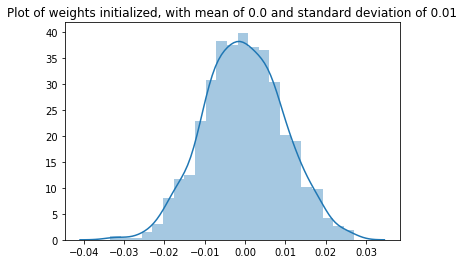

In [14]:
# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

Text(0.5, 1.0, 'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

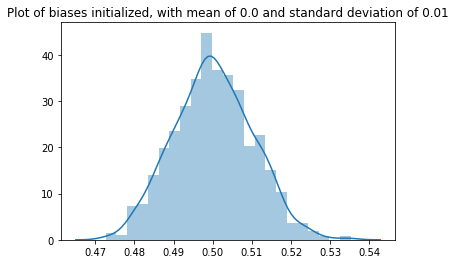

In [15]:
# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [19]:
def get_siamese_model(input_shape):
    """
        Model architecture
    """
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(1,1), activation='relu', strides=1, padding="same", input_shape=input_shape,
                     use_bias = True, kernel_initializer=initialize_weights, bias_initializer=initialize_bias))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', strides=1, padding="same", input_shape=input_shape,
                     use_bias = True, kernel_initializer=initialize_weights, bias_initializer=initialize_bias))
    # model.add(MaxPooling2D())
    #model.add(Conv2D(128,kernel_size=(1,1), activation='relu', strides=1, padding="same", input_shape=input_shape,
     #                use_bias = True, kernel_initializer='random_uniform', bias_initializer='zeros'))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='random_uniform',bias_initializer=initialize_bias))

    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer='zeros')(L1_distance)

     # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

    # return the model
    return siamese_net
    
model = get_siamese_model((2, 30, 1))
model.summary()
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 2, 30, 1)     0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2, 30, 1)     0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         3954816     input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 4096)         0           sequential_1[1][0]         

In [150]:
class TripletNet(Model):
    def __init__(self, shape=(2, 30, 1), dimensions=128):
        super(TripletNet, self).__init__()
        self.model = self.build_triplets_model(shape, dimensions)
        self.model.compile(
            #loss=tfa.losses.TripletSemiHardLoss(),
            loss = triplet_loss,
            optimizer=tfa.optimizers.RectifiedAdam(0.001),
            metrics=['accuracy']
            #tfa.metrics.MultiLabelConfusionMatrix(num_classes=2)
        )
        self.fit = self.model.fit
        self.fit_generator = self.model.fit_generator
        self.predict = self.model.predict
        self.evaluate = self.model.evaluate
        self.summary = self.model.summary
        
        
    def build_triplets_model(self, shape, dimensions):
        net = self.build_embedding(shape, dimensions)
     
        anchor_input = Input(shape=shape, name='anchor')
        positive_input = Input(shape=shape, name='positive')
        negative_input = Input(shape=shape, name='negative')

        # Get the embedded values
        encoded_a = net(anchor_input)
        encoded_p = net(positive_input)
        encoded_n = net(negative_input)
        
        # Get the differences
        L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
        d1 = L1_layer([encoded_a, encoded_p])
        d2 = L1_layer([encoded_a, encoded_n])

        # Normalize the differences
        L2_layer = Lambda(lambda tensors:tf.norm(tensors))
        n1 = L2_layer(d1)
        n2 = L2_layer(d2)

        # Compare
        #out = Activation('sigmoid')(tf.subtract(n2, n1))
        # Add a dense layer with a sigmoid unit to generate the similarity score
           # Add a customized layer to compute the absolute difference between the encodings
        
        L1_distance = L1_layer([n2, n1])
        
        prediction = Dense(1,bias_initializer='zeros')(d1)

        triplet_net = Model(inputs=[anchor_input, positive_input, negative_input],\
                            outputs=[d1])
        return triplet_net

    def build_embedding(self, input_shape, dimensions):
        inp = Input(shape=input_shape)
     
        out = Conv2D(32, kernel_size=(1,1), activation='relu', strides=1, padding="same", input_shape=input_shape,
                   use_bias = True, kernel_initializer=initialize_weights, bias_initializer=initialize_bias)(inp)
        out = MaxPooling2D()(out)
        out = Conv2D(64, kernel_size=(3,3), activation='relu', strides=1, padding="same",
                   use_bias = True, kernel_initializer=initialize_weights, bias_initializer=initialize_bias)(out)
        out = Flatten()(out)
        out = Dense(4096, kernel_regularizer=l2(1e-3), kernel_initializer='random_uniform',
                        bias_initializer=initialize_bias)(out)
        
        L1_layer = Lambda(lambda tensors:tf.math.l2_normalize(tensors, axis=1))
        out = L1_layer(out)
        
        return Model(inputs=inp, outputs=out)

triplet_model = TripletNet(shape=(2, 30, 1), dimensions=128)
triplet_model.summary()
triplet_model.model.metrics_names

Model: "model_69"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             (None, 2, 30, 1)     0                                            
__________________________________________________________________________________________________
positive (InputLayer)           (None, 2, 30, 1)     0                                            
__________________________________________________________________________________________________
model_68 (Model)                (None, 4096)         3954816     anchor[0][0]                     
                                                                 positive[0][0]                   
__________________________________________________________________________________________________
lambda_53 (Lambda)              multiple             0           model_68[1][0]            

['loss', 'accuracy']

In [133]:
import tensorflow as tf
import tensorflow_addons as tfa
train,test = tf.keras.datasets.mnist.load_data()
x_train, y_train = train
x_train = x_train[..., tf.newaxis] / 255.0

print(y_train.shape)
print(y_train)

# TFA layers and activations
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3),
                         activation=tfa.activations.gelu),
  tfa.layers.GroupNormalization(groups=5, axis=3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation='softmax')
])

# TFA optimizers, losses and metrics
model.compile(
    optimizer=tfa.optimizers.RectifiedAdam(0.001),
    loss=tfa.losses.TripletSemiHardLoss(),
    metrics=[tfa.metrics.MultiLabelConfusionMatrix(num_classes=10)])

#history = model.fit(x_train, y_train, epochs=10)

(60000,)
[5 0 4 ... 5 6 8]


### Training Triplet Net

In [134]:
def get_triplet_batch(batch_size, positive_samples, negative_samples, anchor):
    n_examples_p, d, w, h = positive_samples.shape
    n_examples_n = negative_samples.shape[0]
    triplets = [np.zeros((batch_size, w, h, 1)) for i in range(3)]
    
    # initialize vector for the targets
    targets = np.ones((batch_size,3))
    targets[:,2] = 0
    
    for i in range(batch_size):
        idx_p = rng.randint(0, n_examples_p)
        idx_n = rng.randint(0, n_examples_n)
        triplets[0][i,:,:,:] = anchor.reshape(w, h, 1)
        triplets[1][i,:,:,:] = positive_samples[idx_p].reshape(w, h, 1)
        triplets[2][i,:,:,:] = negative_samples[idx_n].reshape(w, h, 1)
    return [triplets[0], triplets[1], triplets[2]], [targets[:,0], targets[:,1], targets[:,2]]

def triplet_generator():
    while True:
        inputs, targets = get_triplet_batch(batch_size, pos_train, neg_train, \
                                                      spoof_ground_truth.spoof_step1_truth1)
        yield [inputs, targets], None

def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    ### START CODE HERE ### (≈ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    ### END CODE HERE ###
    
    return loss

In [135]:
evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 20000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1

In [136]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_triplet_batch(batch_size, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
    #(inp, tar) = triplet_generator()
    loss = triplet_model.model.train_on_batch(inputs, targets)
    print(loss)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
      #  val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        triplet_model.model.save_weights(os.path.join(model_path, 'weights_triplet.{}.h5'.format(i)))
       # if val_acc >= best:
        #    print("Current best: {0}, previous best: {1}".format(val_acc, best))
         #   best = val_acc

Starting training process!
-------------------------------------
[4.0215235, 0.2, 0.54365605, 0.0, 0.0, 0.0, 0.0]
[3.7987356, 0.2, 0.100871325, 0.22000976, 0.0, 0.0, 0.0]
[4.1176863, 0.2, 0.454387, 0.18545757, 0.0, 0.0, 0.0]
[4.058267, 0.2, 0.3691703, 0.21126872, 0.0, 0.0, 0.0]
[4.1057134, 0.2, 0.4451118, 0.1827865, 0.0, 0.0, 0.0]
[3.6397138, 0.2, 0.0, 0.1619119, 0.0, 0.0, 0.0]
[4.588362, 0.2, 0.93418384, 0.17932743, 0.0, 0.0, 0.0]
[4.470667, 0.2, 0.7940304, 0.20532255, 0.0, 0.0, 0.0]
[4.0568743, 0.2, 0.3759399, 0.21359515, 0.0, 0.0, 0.0]
[3.8655818, 0.2, 0.15140098, 0.25114763, 0.0, 0.0, 0.0]

 ------------- 

Time for 10 iterations: 0.056649649143218996 mins
Train Loss: [3.8655818, 0.2, 0.15140098, 0.25114763, 0.0, 0.0, 0.0]
[3.7248116, 0.2, 0.06328815, 0.203244, 0.0, 0.0, 0.0]
[4.2120852, 0.2, 0.5148415, 0.24412891, 0.0, 0.0, 0.0]
[3.6368356, 0.2, 6.219745e-05, 0.18919963, 0.0, 0.0, 0.0]
[3.6674953, 0.2, 0.0, 0.2258829, 0.0, 0.0, 0.0]
[4.392164, 0.2, 0.7264741, 0.23048313, 0.0, 0.0,

[2.638907, 0.2, 0.35027063, 0.22099112, 0.0, 0.0, 0.0]
[2.4738574, 0.2, 0.21247841, 0.20709321, 0.0, 0.0, 0.0]
[2.5001044, 0.2, 0.27754742, 0.18158527, 0.0, 0.0, 0.0]
[2.519256, 0.2, 0.29091477, 0.20062952, 0.0, 0.0, 0.0]
[2.3016052, 0.2, 0.085127205, 0.20195304, 0.0, 0.0, 0.0]
[2.405062, 0.2, 0.2062153, 0.19746819, 0.0, 0.0, 0.0]
[2.4031854, 0.2, 0.21112786, 0.20377608, 0.0, 0.0, 0.0]
[2.3036566, 0.2, 0.12340661, 0.2050173, 0.0, 0.0, 0.0]
[2.3774505, 0.2, 0.21490566, 0.20032047, 0.0, 0.0, 0.0]

 ------------- 

Time for 130 iterations: 0.4039338151613871 mins
Train Loss: [2.3774505, 0.2, 0.21490566, 0.20032047, 0.0, 0.0, 0.0]
[2.4093583, 0.2, 0.25761825, 0.20246238, 0.0, 0.0, 0.0]
[2.324897, 0.2, 0.18709092, 0.20140564, 0.0, 0.0, 0.0]
[2.3103642, 0.2, 0.18822035, 0.19857004, 0.0, 0.0, 0.0]
[2.2672443, 0.2, 0.16667339, 0.18976386, 0.0, 0.0, 0.0]
[2.3039749, 0.2, 0.20454776, 0.2013357, 0.0, 0.0, 0.0]
[2.2618046, 0.2, 0.16932712, 0.20704941, 0.0, 0.0, 0.0]
[2.4786, 0.2, 0.17386031, 0.431

[1.3440964, 0.2, 0.19521049, 0.20340474, 0.0, 0.0, 0.0]
[1.3621731, 0.2, 0.2234657, 0.19857313, 0.0, 0.0, 0.0]
[1.2905024, 0.2, 0.2414443, 0.11424354, 0.0, 0.0, 0.0]
[1.3279808, 0.2, 0.20785585, 0.19061221, 0.0, 0.0, 0.0]
[1.1331419, 0.2, 0.16274214, 0.046160206, 0.0, 0.0, 0.0]
[1.2747831, 0.2, 0.15775245, 0.1980337, 0.0, 0.0, 0.0]
[1.6202551, 0.2, 0.5028603, 0.2036058, 0.0, 0.0, 0.0]
[1.3207333, 0.2, 0.21378043, 0.19830786, 0.0, 0.0, 0.0]

 ------------- 

Time for 250 iterations: 0.6974980274836222 mins
Train Loss: [1.3207333, 0.2, 0.21378043, 0.19830786, 0.0, 0.0, 0.0]
[1.1091628, 0.2, 0.18696591, 0.018665157, 0.0, 0.0, 0.0]
[1.2871387, 0.2, 0.18924755, 0.19943851, 0.0, 0.0, 0.0]
[1.3086746, 0.2, 0.22330013, 0.19196154, 0.0, 0.0, 0.0]
[1.3625609, 0.2, 0.2836721, 0.1904772, 0.0, 0.0, 0.0]
[1.0608015, 0.2, 0.0, 0.17735599, 0.0, 0.0, 0.0]
[1.3999594, 0.2, 0.3101918, 0.21125518, 0.0, 0.0, 0.0]
[1.1002821, 0.2, 0.02157447, 0.20508975, 0.0, 0.0, 0.0]
[1.3561381, 0.2, 0.2906056, 0.19679333

[0.9141607, 0.2, 0.19245996, 0.19364151, 0.0, 0.0, 0.0]
[1.0065511, 0.2, 0.28263468, 0.19809815, 0.0, 0.0, 0.0]
[0.9070618, 0.2, 0.1754394, 0.2080094, 0.0, 0.0, 0.0]
[0.9048803, 0.2, 0.17185144, 0.2116199, 0.0, 0.0, 0.0]
[0.8886236, 0.2, 0.17026787, 0.19915597, 0.0, 0.0, 0.0]
[0.87266624, 0.2, 0.15218282, 0.20346922, 0.0, 0.0, 0.0]
[0.85676444, 0.2, 0.14136864, 0.20054685, 0.0, 0.0, 0.0]
[0.92406464, 0.2, 0.21157046, 0.19981371, 0.0, 0.0, 0.0]
[0.7935913, 0.2, 0.07796343, 0.2050911, 0.0, 0.0, 0.0]

 ------------- 

Time for 370 iterations: 1.0940728465716043 mins
Train Loss: [0.7935913, 0.2, 0.07796343, 0.2050911, 0.0, 0.0, 0.0]
[0.9153111, 0.2, 0.2107161, 0.19617505, 0.0, 0.0, 0.0]
[0.89834523, 0.2, 0.19331107, 0.19871606, 0.0, 0.0, 0.0]
[1.2359575, 0.2, 0.5309823, 0.20074199, 0.0, 0.0, 0.0]
[0.8409854, 0.2, 0.14113137, 0.1977599, 0.0, 0.0, 0.0]
[0.7798408, 0.2, 0.20708716, 0.07273384, 0.0, 0.0, 0.0]
[0.95189625, 0.2, 0.24131578, 0.21251792, 0.0, 0.0, 0.0]
[0.8915707, 0.2, 0.19542442,

[0.7497049, 0.2, 0.20062733, 0.19814324, 0.0, 0.0, 0.0]
[0.7515633, 0.2, 0.19990583, 0.20171855, 0.0, 0.0, 0.0]
[0.85100335, 0.2, 0.30064246, 0.20142023, 0.0, 0.0, 0.0]
[0.7488576, 0.2, 0.20019788, 0.20070218, 0.0, 0.0, 0.0]
[0.701979, 0.2, 0.15073444, 0.20426668, 0.0, 0.0, 0.0]
[0.71445763, 0.2, 0.19338207, 0.17509384, 0.0, 0.0, 0.0]
[0.72714627, 0.2, 0.18363614, 0.19849093, 0.0, 0.0, 0.0]
[0.75383544, 0.2, 0.20861432, 0.20111153, 0.0, 0.0, 0.0]
[0.7330781, 0.2, 0.19012271, 0.1997238, 0.0, 0.0, 0.0]
[0.72898644, 0.2, 0.18572615, 0.20089781, 0.0, 0.0, 0.0]

 ------------- 

Time for 490 iterations: 1.4616038004557292 mins
Train Loss: [0.72898644, 0.2, 0.18572615, 0.20089781, 0.0, 0.0, 0.0]
[0.7131897, 0.2, 0.17334005, 0.19835894, 0.0, 0.0, 0.0]
[0.7349971, 0.2, 0.19325759, 0.2011334, 0.0, 0.0, 0.0]
[0.8201569, 0.2, 0.27788305, 0.2025667, 0.0, 0.0, 0.0]
[0.72244513, 0.2, 0.18228742, 0.20135053, 0.0, 0.0, 0.0]
[0.74375516, 0.2, 0.20423329, 0.2016379, 0.0, 0.0, 0.0]
[0.71047515, 0.2, 0.17

[0.64040726, 0.2, 0.1679466, 0.19841106, 0.0, 0.0, 0.0]
[0.683992, 0.2, 0.20331134, 0.20702264, 0.0, 0.0, 0.0]
[0.67978084, 0.2, 0.20876694, 0.1977578, 0.0, 0.0, 0.0]
[0.6086227, 0.2, 0.13491637, 0.20086733, 0.0, 0.0, 0.0]
[0.6709843, 0.2, 0.2004613, 0.19811091, 0.0, 0.0, 0.0]
[0.6775727, 0.2, 0.20563813, 0.19995832, 0.0, 0.0, 0.0]
[0.84840536, 0.2, 0.37914687, 0.19773243, 0.0, 0.0, 0.0]
[0.61981773, 0.2, 0.14610167, 0.20266494, 0.0, 0.0, 0.0]
[0.5409706, 0.2, 0.06952573, 0.20086756, 0.0, 0.0, 0.0]
[0.681891, 0.2, 0.21424548, 0.19755183, 0.0, 0.0, 0.0]

 ------------- 

Time for 610 iterations: 1.7846378127733866 mins
Train Loss: [0.681891, 0.2, 0.21424548, 0.19755183, 0.0, 0.0, 0.0]
[0.6283345, 0.2, 0.15680858, 0.20189285, 0.0, 0.0, 0.0]
[0.688934, 0.2, 0.21130699, 0.20844215, 0.0, 0.0, 0.0]
[0.6075757, 0.2, 0.1376662, 0.20115647, 0.0, 0.0, 0.0]
[0.6744387, 0.2, 0.20795819, 0.19815496, 0.0, 0.0, 0.0]
[0.48904014, 0.2, 0.024946094, 0.19619119, 0.0, 0.0, 0.0]
[0.65441346, 0.2, 0.1815228

[0.66421217, 0.2, 0.21662605, 0.19841024, 0.0, 0.0, 0.0]
[0.643297, 0.2, 0.19457774, 0.19971833, 0.0, 0.0, 0.0]
[0.7036659, 0.2, 0.25626674, 0.19859575, 0.0, 0.0, 0.0]
[0.68138033, 0.2, 0.23520014, 0.19759847, 0.0, 0.0, 0.0]
[0.66511095, 0.2, 0.20800513, 0.20875916, 0.0, 0.0, 0.0]
[0.6565922, 0.2, 0.21406056, 0.19443367, 0.0, 0.0, 0.0]
[0.6318637, 0.2, 0.18468614, 0.19934012, 0.0, 0.0, 0.0]
[0.6495688, 0.2, 0.20661777, 0.19538385, 0.0, 0.0, 0.0]
[0.68106806, 0.2, 0.23323311, 0.20054747, 0.0, 0.0, 0.0]
[0.8549712, 0.2, 0.17392233, 0.4340498, 0.0, 0.0, 0.0]

 ------------- 

Time for 730 iterations: 2.067779461542765 mins
Train Loss: [0.8549712, 0.2, 0.17392233, 0.4340498, 0.0, 0.0, 0.0]
[0.6492809, 0.2, 0.2000704, 0.20251843, 0.0, 0.0, 0.0]
[0.6494608, 0.2, 0.20246658, 0.20059018, 0.0, 0.0, 0.0]
[0.64285076, 0.2, 0.19488728, 0.20183635, 0.0, 0.0, 0.0]
[0.62809354, 0.2, 0.18443054, 0.19780365, 0.0, 0.0, 0.0]
[0.62710744, 0.2, 0.18363348, 0.19787222, 0.0, 0.0, 0.0]
[0.64727974, 0.2, 0.201

[0.69247615, 0.2, 0.23892745, 0.22750042, 0.0, 0.0, 0.0]
[0.62848306, 0.2, 0.20299438, 0.19950174, 0.0, 0.0, 0.0]
[0.6250212, 0.2, 0.19882214, 0.20028415, 0.0, 0.0, 0.0]
[0.61411035, 0.2, 0.187455, 0.20082046, 0.0, 0.0, 0.0]
[0.60847104, 0.2, 0.16248438, 0.22023772, 0.0, 0.0, 0.0]
[0.60551614, 0.2, 0.18180822, 0.19806132, 0.0, 0.0, 0.0]
[0.60537285, 0.2, 0.1786708, 0.20116222, 0.0, 0.0, 0.0]
[0.41277578, 0.2, 0.1873461, 0.0, 0.0, 0.0, 0.0]
[0.64971894, 0.2, 0.22350168, 0.20090166, 0.0, 0.0, 0.0]
[0.6355506, 0.2, 0.21047634, 0.19988337, 0.0, 0.0, 0.0]

 ------------- 

Time for 850 iterations: 2.3826946139335634 mins
Train Loss: [0.6355506, 0.2, 0.21047634, 0.19988337, 0.0, 0.0, 0.0]
[0.6475218, 0.2, 0.19555143, 0.2269073, 0.0, 0.0, 0.0]
[0.6176771, 0.2, 0.19232658, 0.20040925, 0.0, 0.0, 0.0]
[0.62790394, 0.2, 0.20214412, 0.20093456, 0.0, 0.0, 0.0]
[0.579783, 0.2, 0.1564655, 0.19861026, 0.0, 0.0, 0.0]
[0.62839985, 0.2, 0.19885148, 0.20495678, 0.0, 0.0, 0.0]
[0.6644728, 0.2, 0.2392319, 0

[0.5757704, 0.2, 0.15573218, 0.1932627, 0.0, 0.0, 0.0]
[0.61964744, 0.2, 0.19800723, 0.19524981, 0.0, 0.0, 0.0]
[0.6625687, 0.2, 0.23728381, 0.19926009, 0.0, 0.0, 0.0]
[0.60511917, 0.2, 0.18066224, 0.19878112, 0.0, 0.0, 0.0]
[0.630007, 0.2, 0.2025591, 0.20210664, 0.0, 0.0, 0.0]
[0.5825319, 0.2, 0.15597075, 0.20154382, 0.0, 0.0, 0.0]
[0.6135032, 0.2, 0.18497288, 0.20383123, 0.0, 0.0, 0.0]
[0.5873594, 0.2, 0.16507529, 0.19789048, 0.0, 0.0, 0.0]
[0.6338127, 0.2, 0.21636382, 0.19335483, 0.0, 0.0, 0.0]
[0.6276893, 0.2, 0.20236322, 0.20152037, 0.0, 0.0, 0.0]

 ------------- 

Time for 970 iterations: 2.7660839478174846 mins
Train Loss: [0.6276893, 0.2, 0.20236322, 0.20152037, 0.0, 0.0, 0.0]
[0.66155976, 0.2, 0.23706472, 0.20096922, 0.0, 0.0, 0.0]
[0.6093754, 0.2, 0.18652508, 0.19959633, 0.0, 0.0, 0.0]
[0.62500614, 0.2, 0.19479762, 0.20721999, 0.0, 0.0, 0.0]
[0.6268079, 0.2, 0.2035791, 0.20050153, 0.0, 0.0, 0.0]
[0.62189287, 0.2, 0.19809234, 0.20132765, 0.0, 0.0, 0.0]
[0.63849247, 0.2, 0.2147

[0.6354564, 0.2, 0.19911331, 0.20250918, 0.0, 0.0, 0.0]
[0.625028, 0.2, 0.19712351, 0.19340494, 0.0, 0.0, 0.0]
[0.67366886, 0.2, 0.23354577, 0.20494805, 0.0, 0.0, 0.0]
[0.76361156, 0.2, 0.31209236, 0.21568829, 0.0, 0.0, 0.0]
[0.43224669, 0.2, 0.19585508, 0.0, 0.0, 0.0, 0.0]
[0.65204483, 0.2, 0.19911982, 0.2160146, 0.0, 0.0, 0.0]
[0.66437745, 0.2, 0.21189645, 0.21512009, 0.0, 0.0, 0.0]
[0.5618693, 0.2, 0.118248835, 0.20588112, 0.0, 0.0, 0.0]
[0.6239035, 0.2, 0.1748395, 0.21100947, 0.0, 0.0, 0.0]
[0.6318669, 0.2, 0.1934659, 0.20007016, 0.0, 0.0, 0.0]

 ------------- 

Time for 1090 iterations: 3.089081664880117 mins
Train Loss: [0.6318669, 0.2, 0.1934659, 0.20007016, 0.0, 0.0, 0.0]
[0.6517506, 0.2, 0.21070445, 0.20248465, 0.0, 0.0, 0.0]
[0.645823, 0.2, 0.20165166, 0.20544289, 0.0, 0.0, 0.0]
[0.6477858, 0.2, 0.21994264, 0.18900342, 0.0, 0.0, 0.0]
[0.61985636, 0.2, 0.18021545, 0.20076218, 0.0, 0.0, 0.0]
[0.5887212, 0.2, 0.16170473, 0.18814848, 0.0, 0.0, 0.0]
[0.5124169, 0.2, 0.06351283, 0.

[0.6418685, 0.2, 0.19147135, 0.21313494, 0.0, 0.0, 0.0]
[0.7759784, 0.2, 0.33325064, 0.2049408, 0.0, 0.0, 0.0]
[0.59186316, 0.2, 0.1607601, 0.19300844, 0.0, 0.0, 0.0]
[0.45526075, 0.2, 0.0, 0.21702437, 0.0, 0.0, 0.0]
[0.70852315, 0.2, 0.27512136, 0.19519316, 0.0, 0.0, 0.0]
[0.615066, 0.2, 0.17386857, 0.20313828, 0.0, 0.0, 0.0]
[0.6469164, 0.2, 0.20907983, 0.20001608, 0.0, 0.0, 0.0]
[0.60539156, 0.2, 0.36788258, 0.0, 0.0, 0.0, 0.0]
[0.72076535, 0.2, 0.26426178, 0.21939504, 0.0, 0.0, 0.0]
[0.46373984, 0.2, 0.03296078, 0.19410287, 0.0, 0.0, 0.0]

 ------------- 

Time for 1210 iterations: 3.444418998559316 mins
Train Loss: [0.46373984, 0.2, 0.03296078, 0.19410287, 0.0, 0.0, 0.0]
[0.634711, 0.2, 0.18388687, 0.21455911, 0.0, 0.0, 0.0]
[0.5367739, 0.2, 0.09492302, 0.20601897, 0.0, 0.0, 0.0]
[0.731933, 0.2, 0.26167995, 0.23481828, 0.0, 0.0, 0.0]
[0.638284, 0.2, 0.19610615, 0.20717093, 0.0, 0.0, 0.0]
[0.70252407, 0.2, 0.2598138, 0.20809177, 0.0, 0.0, 0.0]
[0.61019087, 0.2, 0.19843918, 0.177502

[0.4523754, 0.2, 0.1634034, 0.07403814, 0.0, 0.0, 0.0]
[0.60409224, 0.2, 0.19973437, 0.18941553, 0.0, 0.0, 0.0]
[0.61266124, 0.2, 0.1955733, 0.20208281, 0.0, 0.0, 0.0]
[0.64411724, 0.2, 0.2246856, 0.20433141, 0.0, 0.0, 0.0]
[0.43822795, 0.2, 0.031907544, 0.19110669, 0.0, 0.0, 0.0]
[0.53861743, 0.2, 0.117369756, 0.20572793, 0.0, 0.0, 0.0]
[0.508499, 0.2, 0.096290395, 0.19607562, 0.0, 0.0, 0.0]
[0.80560213, 0.2, 0.3523154, 0.23630993, 0.0, 0.0, 0.0]
[0.5858303, 0.2, 0.16161907, 0.20633444, 0.0, 0.0, 0.0]
[0.8383538, 0.2, 0.4330426, 0.18642056, 0.0, 0.0, 0.0]

 ------------- 

Time for 1330 iterations: 3.7979649662971497 mins
Train Loss: [0.8383538, 0.2, 0.4330426, 0.18642056, 0.0, 0.0, 0.0]
[0.5265274, 0.2, 0.11015926, 0.1964336, 0.0, 0.0, 0.0]
[0.40413257, 0.2, 0.0, 0.18308513, 0.0, 0.0, 0.0]
[0.5673752, 0.2, 0.14242388, 0.20278502, 0.0, 0.0, 0.0]
[0.4248587, 0.2, 0.0, 0.20156297, 0.0, 0.0, 0.0]
[0.42529842, 0.2, 0.0, 0.20093244, 0.0, 0.0, 0.0]
[0.5432322, 0.2, 0.1544466, 0.16342822, 0.

[0.70370877, 0.2, 0.22247711, 0.22127295, 0.0, 0.0, 0.0]
[0.6837698, 0.2, 0.21992324, 0.20416039, 0.0, 0.0, 0.0]
[0.6483647, 0.2, 0.19202398, 0.19705813, 0.0, 0.0, 0.0]
[0.5311916, 0.2, 0.08905707, 0.18331686, 0.0, 0.0, 0.0]
[0.7664692, 0.2, 0.28774893, 0.22006184, 0.0, 0.0, 0.0]
[0.6575724, 0.2, 0.19816433, 0.20095783, 0.0, 0.0, 0.0]
[0.6760859, 0.2, 0.23012775, 0.1877576, 0.0, 0.0, 0.0]
[0.60861677, 0.2, 0.19164331, 0.1590506, 0.0, 0.0, 0.0]
[0.6720311, 0.2, 0.18553402, 0.22877346, 0.0, 0.0, 0.0]

 ------------- 

Time for 1450 iterations: 4.135095763206482 mins
Train Loss: [0.6720311, 0.2, 0.18553402, 0.22877346, 0.0, 0.0, 0.0]
[0.43224984, 0.2, 0.17470938, 0.0, 0.0, 0.0, 0.0]
[0.6419879, 0.2, 0.18460305, 0.20002705, 0.0, 0.0, 0.0]
[0.5847739, 0.2, 0.15538946, 0.17222188, 0.0, 0.0, 0.0]
[0.64029306, 0.2, 0.16473405, 0.21857485, 0.0, 0.0, 0.0]
[0.6505024, 0.2, 0.18670106, 0.2070299, 0.0, 0.0, 0.0]
[0.65469855, 0.2, 0.19622, 0.201941, 0.0, 0.0, 0.0]
[0.7003551, 0.2, 0.25166482, 0.1924

[0.5951501, 0.2, 0.16683045, 0.19454457, 0.0, 0.0, 0.0]
[0.7206416, 0.2, 0.25161192, 0.2351177, 0.0, 0.0, 0.0]
[0.47698388, 0.2, 0.044798583, 0.19840512, 0.0, 0.0, 0.0]
[0.63090885, 0.2, 0.196093, 0.200976, 0.0, 0.0, 0.0]
[0.7162279, 0.2, 0.28154856, 0.2007827, 0.0, 0.0, 0.0]
[0.6865221, 0.2, 0.25380632, 0.19891952, 0.0, 0.0, 0.0]
[0.67546815, 0.2, 0.24367103, 0.19822054, 0.0, 0.0, 0.0]
[0.7143212, 0.2, 0.28078267, 0.20024063, 0.0, 0.0, 0.0]
[0.65163344, 0.2, 0.21887785, 0.19974242, 0.0, 0.0, 0.0]
[0.6576372, 0.2, 0.20438164, 0.22062996, 0.0, 0.0, 0.0]

 ------------- 

Time for 1570 iterations: 4.4698360125223795 mins
Train Loss: [0.6576372, 0.2, 0.20438164, 0.22062996, 0.0, 0.0, 0.0]
[0.43266758, 0.2, 0.0, 0.20045897, 0.0, 0.0, 0.0]
[0.6622426, 0.2, 0.22618803, 0.20423645, 0.0, 0.0, 0.0]
[0.43069354, 0.2, 0.0, 0.1992618, 0.0, 0.0, 0.0]
[0.67168283, 0.2, 0.22820514, 0.21242093, 0.0, 0.0, 0.0]
[0.54270375, 0.2, 0.11121646, 0.20079389, 0.0, 0.0, 0.0]
[0.76262796, 0.2, 0.32717216, 0.2049

[0.65468484, 0.2, 0.20059817, 0.20493929, 0.0, 0.0, 0.0]
[0.64792097, 0.2, 0.19988512, 0.19953856, 0.0, 0.0, 0.0]
[0.5407552, 0.2, 0.09695663, 0.1959605, 0.0, 0.0, 0.0]
[0.65432614, 0.2, 0.20825347, 0.19886713, 0.0, 0.0, 0.0]
[0.63808954, 0.2, 0.19490267, 0.19661205, 0.0, 0.0, 0.0]
[0.6555434, 0.2, 0.20773819, 0.20186007, 0.0, 0.0, 0.0]
[0.64541256, 0.2, 0.19847117, 0.20163561, 0.0, 0.0, 0.0]
[0.611902, 0.2, 0.16758661, 0.199646, 0.0, 0.0, 0.0]
[0.6632581, 0.2, 0.22095574, 0.19826418, 0.0, 0.0, 0.0]
[0.64392424, 0.2, 0.20137683, 0.19913201, 0.0, 0.0, 0.0]

 ------------- 

Time for 1690 iterations: 4.7617237647374475 mins
Train Loss: [0.64392424, 0.2, 0.20137683, 0.19913201, 0.0, 0.0, 0.0]
[0.6433458, 0.2, 0.19929513, 0.20125438, 0.0, 0.0, 0.0]
[0.6392771, 0.2, 0.19825391, 0.19884437, 0.0, 0.0, 0.0]
[0.53643715, 0.2, 0.09336467, 0.20150368, 0.0, 0.0, 0.0]
[0.62130994, 0.2, 0.17983517, 0.20047118, 0.0, 0.0, 0.0]
[0.6549491, 0.2, 0.21227928, 0.20222928, 0.0, 0.0, 0.0]
[0.66817254, 0.2, 0

[0.6184725, 0.2, 0.19924814, 0.19975096, 0.0, 0.0, 0.0]
[0.62202144, 0.2, 0.20018482, 0.20226932, 0.0, 0.0, 0.0]
[0.61283964, 0.2, 0.19792682, 0.19525406, 0.0, 0.0, 0.0]
[0.62431616, 0.2, 0.19159107, 0.21298157, 0.0, 0.0, 0.0]
[0.62080747, 0.2, 0.20189533, 0.19910872, 0.0, 0.0, 0.0]
[0.5867893, 0.2, 0.20422858, 0.16271764, 0.0, 0.0, 0.0]
[0.6386477, 0.2, 0.21978076, 0.19896089, 0.0, 0.0, 0.0]
[0.6146926, 0.2, 0.19331065, 0.20143643, 0.0, 0.0, 0.0]
[0.6136214, 0.2, 0.19368652, 0.19997334, 0.0, 0.0, 0.0]

 ------------- 

Time for 1810 iterations: 5.074516979853312 mins
Train Loss: [0.6136214, 0.2, 0.19368652, 0.19997334, 0.0, 0.0, 0.0]
[0.62256247, 0.2, 0.20152766, 0.20107591, 0.0, 0.0, 0.0]
[0.6231924, 0.2, 0.20157339, 0.20168875, 0.0, 0.0, 0.0]
[0.620625, 0.2, 0.20055762, 0.20018777, 0.0, 0.0, 0.0]
[0.6242874, 0.2, 0.19593401, 0.2085438, 0.0, 0.0, 0.0]
[0.5937183, 0.2, 0.17437953, 0.19961779, 0.0, 0.0, 0.0]
[0.6271675, 0.2, 0.20331396, 0.20423114, 0.0, 0.0, 0.0]
[0.622792, 0.2, 0.2037

[0.6213808, 0.2, 0.19825506, 0.20426548, 0.0, 0.0, 0.0]
[0.6285229, 0.2, 0.2114681, 0.19832872, 0.0, 0.0, 0.0]
[0.61316425, 0.2, 0.19154856, 0.2030327, 0.0, 0.0, 0.0]
[0.6443155, 0.2, 0.22305042, 0.2028282, 0.0, 0.0, 0.0]
[0.63289803, 0.2, 0.21194646, 0.20267043, 0.0, 0.0, 0.0]
[0.6128807, 0.2, 0.19491512, 0.19984944, 0.0, 0.0, 0.0]
[0.62010694, 0.2, 0.20336504, 0.19879094, 0.0, 0.0, 0.0]
[0.6241998, 0.2, 0.20499799, 0.20142008, 0.0, 0.0, 0.0]
[0.61793953, 0.2, 0.19926307, 0.20106754, 0.0, 0.0, 0.0]
[0.59360296, 0.2, 0.17980805, 0.19636011, 0.0, 0.0, 0.0]

 ------------- 

Time for 1930 iterations: 5.455243380864461 mins
Train Loss: [0.59360296, 0.2, 0.17980805, 0.19636011, 0.0, 0.0, 0.0]
[0.62151337, 0.2, 0.21342286, 0.19081576, 0.0, 0.0, 0.0]
[0.45678163, 0.2, 0.03849715, 0.20116991, 0.0, 0.0, 0.0]
[0.6309039, 0.2, 0.20338391, 0.21049796, 0.0, 0.0, 0.0]
[0.616231, 0.2, 0.199391, 0.19990341, 0.0, 0.0, 0.0]
[0.6104649, 0.2, 0.19470811, 0.19889978, 0.0, 0.0, 0.0]
[0.5796283, 0.2, 0.1698

[0.60233384, 0.2, 0.18798952, 0.187385, 0.0, 0.0, 0.0]
[0.682605, 0.2, 0.19975004, 0.25609708, 0.0, 0.0, 0.0]
[0.6409165, 0.2, 0.19735242, 0.21702468, 0.0, 0.0, 0.0]
[0.54496104, 0.2, 0.11641704, 0.2022289, 0.0, 0.0, 0.0]
[0.61076903, 0.2, 0.19841371, 0.1862576, 0.0, 0.0, 0.0]
[0.62876177, 0.2, 0.19517268, 0.20770542, 0.0, 0.0, 0.0]
[0.62419176, 0.2, 0.19890487, 0.19962081, 0.0, 0.0, 0.0]
[0.6125085, 0.2, 0.19815248, 0.18891034, 0.0, 0.0, 0.0]
[0.66225594, 0.2, 0.23245119, 0.2045801, 0.0, 0.0, 0.0]

 ------------- 

Time for 2050 iterations: 5.790868516763052 mins
Train Loss: [0.66225594, 0.2, 0.23245119, 0.2045801, 0.0, 0.0, 0.0]
[0.608354, 0.2, 0.19324537, 0.19012162, 0.0, 0.0, 0.0]
[0.64842635, 0.2, 0.20170124, 0.22197363, 0.0, 0.0, 0.0]
[0.6272919, 0.2, 0.20515819, 0.19762596, 0.0, 0.0, 0.0]
[0.6471702, 0.2, 0.21711773, 0.20579037, 0.0, 0.0, 0.0]
[0.59459966, 0.2, 0.18127543, 0.18931283, 0.0, 0.0, 0.0]
[0.7395308, 0.2, 0.30709794, 0.20866944, 0.0, 0.0, 0.0]
[0.57868654, 0.2, 0.2092

[0.6275418, 0.2, 0.20587856, 0.20687345, 0.0, 0.0, 0.0]
[0.61279994, 0.2, 0.19670264, 0.2013736, 0.0, 0.0, 0.0]
[0.7260202, 0.2, 0.2878238, 0.22353043, 0.0, 0.0, 0.0]
[0.64027345, 0.2, 0.22701907, 0.19865705, 0.0, 0.0, 0.0]
[0.5985919, 0.2, 0.18168806, 0.20237686, 0.0, 0.0, 0.0]
[0.4779672, 0.2, 0.067644306, 0.19587103, 0.0, 0.0, 0.0]
[0.606357, 0.2, 0.19993038, 0.19205073, 0.0, 0.0, 0.0]
[0.5897276, 0.2, 0.1749628, 0.20046104, 0.0, 0.0, 0.0]
[0.61370033, 0.2, 0.20573558, 0.19372085, 0.0, 0.0, 0.0]

 ------------- 

Time for 2170 iterations: 6.129820346832275 mins
Train Loss: [0.61370033, 0.2, 0.20573558, 0.19372085, 0.0, 0.0, 0.0]
[0.48754928, 0.2, 0.07065877, 0.202706, 0.0, 0.0, 0.0]
[0.6234571, 0.2, 0.21802844, 0.19129084, 0.0, 0.0, 0.0]
[0.6573736, 0.2, 0.24434316, 0.19892746, 0.0, 0.0, 0.0]
[0.7521683, 0.2, 0.34374413, 0.19435458, 0.0, 0.0, 0.0]
[0.65905523, 0.2, 0.2206351, 0.22438872, 0.0, 0.0, 0.0]
[0.621964, 0.2, 0.2175747, 0.19040805, 0.0, 0.0, 0.0]
[0.6385988, 0.2, 0.2225952,

[0.6132716, 0.2, 0.18641958, 0.20112143, 0.0, 0.0, 0.0]
[0.6046744, 0.2, 0.19678877, 0.18229358, 0.0, 0.0, 0.0]
[0.6344831, 0.2, 0.20985435, 0.19917694, 0.0, 0.0, 0.0]
[0.6164122, 0.2, 0.1930729, 0.1980357, 0.0, 0.0, 0.0]
[0.6237355, 0.2, 0.19977067, 0.19881599, 0.0, 0.0, 0.0]
[0.59723467, 0.2, 0.16956426, 0.2026877, 0.0, 0.0, 0.0]
[0.6175358, 0.2, 0.19327007, 0.19946072, 0.0, 0.0, 0.0]
[0.6771897, 0.2, 0.25260952, 0.19996068, 0.0, 0.0, 0.0]
[0.6291272, 0.2, 0.2036862, 0.20101091, 0.0, 0.0, 0.0]

 ------------- 

Time for 2290 iterations: 6.437220815817515 mins
Train Loss: [0.6291272, 0.2, 0.2036862, 0.20101091, 0.0, 0.0, 0.0]
[0.6016745, 0.2, 0.17678331, 0.20065472, 0.0, 0.0, 0.0]
[0.6529202, 0.2, 0.22730672, 0.20157829, 0.0, 0.0, 0.0]
[0.62297875, 0.2, 0.20127904, 0.19786716, 0.0, 0.0, 0.0]
[0.62288064, 0.2, 0.19930609, 0.19994834, 0.0, 0.0, 0.0]
[0.6302669, 0.2, 0.20780331, 0.19904624, 0.0, 0.0, 0.0]
[0.6055413, 0.2, 0.18262112, 0.19971502, 0.0, 0.0, 0.0]
[0.6204551, 0.2, 0.19849907

[0.6145515, 0.2, 0.20050225, 0.19055755, 0.0, 0.0, 0.0]
[0.6351919, 0.2, 0.20902884, 0.2026325, 0.0, 0.0, 0.0]
[0.666541, 0.2, 0.24266154, 0.20033489, 0.0, 0.0, 0.0]
[0.6485278, 0.2, 0.22452712, 0.20048325, 0.0, 0.0, 0.0]
[0.6176106, 0.2, 0.20062695, 0.19351232, 0.0, 0.0, 0.0]
[0.6232385, 0.2, 0.19875763, 0.20107287, 0.0, 0.0, 0.0]
[0.6852326, 0.2, 0.17773294, 0.28416666, 0.0, 0.0, 0.0]
[0.61416996, 0.2, 0.19128536, 0.1996435, 0.0, 0.0, 0.0]
[0.5815108, 0.2, 0.174538, 0.1838295, 0.0, 0.0, 0.0]
[0.7108009, 0.2, 0.281474, 0.20626093, 0.0, 0.0, 0.0]

 ------------- 

Time for 2410 iterations: 6.719737048943838 mins
Train Loss: [0.7108009, 0.2, 0.281474, 0.20626093, 0.0, 0.0, 0.0]
[0.7393785, 0.2, 0.31725508, 0.199153, 0.0, 0.0, 0.0]
[0.63093156, 0.2, 0.20669147, 0.20135973, 0.0, 0.0, 0.0]
[0.85775626, 0.2, 0.4421612, 0.19279963, 0.0, 0.0, 0.0]
[0.61458004, 0.2, 0.19461794, 0.19723272, 0.0, 0.0, 0.0]
[0.6441264, 0.2, 0.22235219, 0.19907095, 0.0, 0.0, 0.0]
[0.56189626, 0.2, 0.14272566, 0.19

[0.59972835, 0.2, 0.20225185, 0.1814604, 0.0, 0.0, 0.0]
[0.627292, 0.2, 0.20996307, 0.20141746, 0.0, 0.0, 0.0]
[0.5137433, 0.2, 0.09578845, 0.20215407, 0.0, 0.0, 0.0]
[0.6181525, 0.2, 0.19798131, 0.20447218, 0.0, 0.0, 0.0]
[0.6161888, 0.2, 0.19970992, 0.20087576, 0.0, 0.0, 0.0]
[0.6452984, 0.2, 0.21541628, 0.21437314, 0.0, 0.0, 0.0]
[0.44629616, 0.2, 0.043074705, 0.18781143, 0.0, 0.0, 0.0]
[0.6016603, 0.2, 0.18030971, 0.20600769, 0.0, 0.0, 0.0]
[0.6117303, 0.2, 0.19787498, 0.19857451, 0.0, 0.0, 0.0]

 ------------- 

Time for 2530 iterations: 7.020567333698272 mins
Train Loss: [0.6117303, 0.2, 0.19787498, 0.19857451, 0.0, 0.0, 0.0]
[0.5841375, 0.2, 0.1780939, 0.1908064, 0.0, 0.0, 0.0]
[0.651735, 0.2, 0.24100128, 0.19554424, 0.0, 0.0, 0.0]
[0.657815, 0.2, 0.2060086, 0.23666577, 0.0, 0.0, 0.0]
[0.8587913, 0.2, 0.4264527, 0.21724707, 0.0, 0.0, 0.0]
[0.56707644, 0.2, 0.17318785, 0.17887169, 0.0, 0.0, 0.0]
[0.6242092, 0.2, 0.21406583, 0.19520275, 0.0, 0.0, 0.0]
[0.6392631, 0.2, 0.21850093, 

[0.5665793, 0.2, 0.15007335, 0.2043089, 0.0, 0.0, 0.0]
[0.53000087, 0.2, 0.11700029, 0.20086697, 0.0, 0.0, 0.0]
[0.62468916, 0.2, 0.2101419, 0.20246018, 0.0, 0.0, 0.0]
[0.6711408, 0.2, 0.25703195, 0.20206328, 0.0, 0.0, 0.0]
[0.54166913, 0.2, 0.12466496, 0.2050024, 0.0, 0.0, 0.0]
[0.6684541, 0.2, 0.23626578, 0.22022861, 0.0, 0.0, 0.0]
[0.6095705, 0.2, 0.20242718, 0.19521736, 0.0, 0.0, 0.0]
[0.5976274, 0.2, 0.19546136, 0.19026469, 0.0, 0.0, 0.0]
[0.61233866, 0.2, 0.21752074, 0.18293363, 0.0, 0.0, 0.0]

 ------------- 

Time for 2650 iterations: 7.337293795744578 mins
Train Loss: [0.61233866, 0.2, 0.21752074, 0.18293363, 0.0, 0.0, 0.0]
[0.6092631, 0.2, 0.1964955, 0.20089561, 0.0, 0.0, 0.0]
[0.55740577, 0.2, 0.120559365, 0.22498548, 0.0, 0.0, 0.0]
[0.6103677, 0.2, 0.1972799, 0.20122845, 0.0, 0.0, 0.0]
[0.63342613, 0.2, 0.21834481, 0.20321947, 0.0, 0.0, 0.0]
[0.6569901, 0.2, 0.25180346, 0.19332288, 0.0, 0.0, 0.0]
[0.6139943, 0.2, 0.2029927, 0.19913617, 0.0, 0.0, 0.0]
[0.57793117, 0.2, 0.180

[0.633555, 0.2, 0.21636385, 0.19681671, 0.0, 0.0, 0.0]
[0.61852056, 0.2, 0.20275477, 0.19543812, 0.0, 0.0, 0.0]
[0.6587168, 0.2, 0.23159207, 0.2068543, 0.0, 0.0, 0.0]
[0.86252004, 0.2, 0.1987829, 0.4435287, 0.0, 0.0, 0.0]
[0.641904, 0.2, 0.22359478, 0.19817974, 0.0, 0.0, 0.0]
[0.6745756, 0.2, 0.25378257, 0.20072284, 0.0, 0.0, 0.0]
[0.7983504, 0.2, 0.3775813, 0.20074101, 0.0, 0.0, 0.0]
[0.6254086, 0.2, 0.20891404, 0.19651183, 0.0, 0.0, 0.0]
[0.61761624, 0.2, 0.19684952, 0.20080924, 0.0, 0.0, 0.0]
[0.60188574, 0.2, 0.18187106, 0.20007013, 0.0, 0.0, 0.0]

 ------------- 

Time for 2770 iterations: 7.675153879324595 mins
Train Loss: [0.60188574, 0.2, 0.18187106, 0.20007013, 0.0, 0.0, 0.0]
[0.5769577, 0.2, 0.15855893, 0.19846189, 0.0, 0.0, 0.0]
[0.6230647, 0.2, 0.20836474, 0.19477826, 0.0, 0.0, 0.0]
[0.52112913, 0.2, 0.1641358, 0.1370932, 0.0, 0.0, 0.0]
[0.63216287, 0.2, 0.21163225, 0.20066687, 0.0, 0.0, 0.0]
[0.62901235, 0.2, 0.21184507, 0.19734456, 0.0, 0.0, 0.0]
[0.6491524, 0.2, 0.228989

[0.65398043, 0.2, 0.24136469, 0.19874018, 0.0, 0.0, 0.0]
[0.652999, 0.2, 0.22612086, 0.21279415, 0.0, 0.0, 0.0]
[0.59624135, 0.2, 0.20808777, 0.1738413, 0.0, 0.0, 0.0]
[0.6198375, 0.2, 0.20397486, 0.20131019, 0.0, 0.0, 0.0]
[0.47483483, 0.2, 0.060792968, 0.19924627, 0.0, 0.0, 0.0]
[0.6485138, 0.2, 0.23003435, 0.20344162, 0.0, 0.0, 0.0]
[0.62004834, 0.2, 0.2073985, 0.1973805, 0.0, 0.0, 0.0]
[0.6194184, 0.2, 0.20708913, 0.19684526, 0.0, 0.0, 0.0]
[0.62364614, 0.2, 0.2094477, 0.19851737, 0.0, 0.0, 0.0]

 ------------- 

Time for 2890 iterations: 7.954184997081756 mins
Train Loss: [0.62364614, 0.2, 0.2094477, 0.19851737, 0.0, 0.0, 0.0]
[0.6251211, 0.2, 0.21023764, 0.1990254, 0.0, 0.0, 0.0]
[0.44403672, 0.2, 0.061054025, 0.16697021, 0.0, 0.0, 0.0]
[0.40861616, 0.2, 0.0, 0.19245173, 0.0, 0.0, 0.0]
[0.62456524, 0.2, 0.20481215, 0.2034495, 0.0, 0.0, 0.0]
[0.77696973, 0.2, 0.19989488, 0.36064887, 0.0, 0.0, 0.0]
[0.6281737, 0.2, 0.21250446, 0.19854663, 0.0, 0.0, 0.0]
[0.54985386, 0.2, 0.12888253

[0.63843745, 0.2, 0.22039789, 0.19354326, 0.0, 0.0, 0.0]
[0.65470487, 0.2, 0.22353277, 0.20673129, 0.0, 0.0, 0.0]
[0.5444971, 0.2, 0.115104206, 0.20503145, 0.0, 0.0, 0.0]
[0.65019363, 0.2, 0.22091973, 0.20501776, 0.0, 0.0, 0.0]
[0.6009518, 0.2, 0.1651578, 0.2116574, 0.0, 0.0, 0.0]
[0.60620505, 0.2, 0.18355478, 0.19862509, 0.0, 0.0, 0.0]
[0.649182, 0.2, 0.205416, 0.21985048, 0.0, 0.0, 0.0]
[0.581895, 0.2, 0.15241927, 0.20567834, 0.0, 0.0, 0.0]
[0.5553789, 0.2, 0.1311158, 0.20059066, 0.0, 0.0, 0.0]

 ------------- 

Time for 3010 iterations: 8.217784015337626 mins
Train Loss: [0.5553789, 0.2, 0.1311158, 0.20059066, 0.0, 0.0, 0.0]
[0.5873529, 0.2, 0.16560239, 0.19820435, 0.0, 0.0, 0.0]
[0.45200107, 0.2, 0.027552115, 0.20103078, 0.0, 0.0, 0.0]
[0.58453465, 0.2, 0.16237043, 0.19886413, 0.0, 0.0, 0.0]
[0.62640005, 0.2, 0.2025878, 0.2006047, 0.0, 0.0, 0.0]
[0.4686246, 0.2, 0.04410871, 0.20139979, 0.0, 0.0, 0.0]
[0.6044503, 0.2, 0.17731485, 0.20410216, 0.0, 0.0, 0.0]
[0.6033024, 0.2, 0.1762752

[0.5751331, 0.2, 0.16083817, 0.19129553, 0.0, 0.0, 0.0]
[0.94951755, 0.2, 0.51985973, 0.20653649, 0.0, 0.0, 0.0]
[0.7604651, 0.2, 0.33710352, 0.20017585, 0.0, 0.0, 0.0]
[0.62872034, 0.2, 0.20536995, 0.2000913, 0.0, 0.0, 0.0]
[0.6273355, 0.2, 0.20162503, 0.20238037, 0.0, 0.0, 0.0]
[0.62471586, 0.2, 0.2003315, 0.20100266, 0.0, 0.0, 0.0]
[0.6633283, 0.2, 0.23301971, 0.20691338, 0.0, 0.0, 0.0]
[0.54017454, 0.2, 0.12169887, 0.19512221, 0.0, 0.0, 0.0]
[0.6990247, 0.2, 0.26795635, 0.20785972, 0.0, 0.0, 0.0]

 ------------- 

Time for 3130 iterations: 8.480295864741008 mins
Train Loss: [0.6990247, 0.2, 0.26795635, 0.20785972, 0.0, 0.0, 0.0]
[0.6221531, 0.2, 0.19501537, 0.20413123, 0.0, 0.0, 0.0]
[0.6343311, 0.2, 0.20101784, 0.21050528, 0.0, 0.0, 0.0]
[0.5647805, 0.2, 0.16913278, 0.17303278, 0.0, 0.0, 0.0]
[0.6031822, 0.2, 0.1869875, 0.1937375, 0.0, 0.0, 0.0]
[0.7258614, 0.2, 0.29898548, 0.20457539, 0.0, 0.0, 0.0]
[0.60852724, 0.2, 0.18834665, 0.19803603, 0.0, 0.0, 0.0]
[0.59823936, 0.2, 0.1737

[0.6261917, 0.2, 0.16867481, 0.2391522, 0.0, 0.0, 0.0]
[0.67237276, 0.2, 0.23673476, 0.21615346, 0.0, 0.0, 0.0]
[0.61999434, 0.2, 0.21286474, 0.18602252, 0.0, 0.0, 0.0]
[0.61651564, 0.2, 0.18600507, 0.2075002, 0.0, 0.0, 0.0]
[0.63702977, 0.2, 0.19450423, 0.21753973, 0.0, 0.0, 0.0]
[0.6440491, 0.2, 0.19837876, 0.21878964, 0.0, 0.0, 0.0]
[0.6585154, 0.2, 0.21166268, 0.21827239, 0.0, 0.0, 0.0]
[0.6400367, 0.2, 0.21793629, 0.19209716, 0.0, 0.0, 0.0]
[0.60555375, 0.2, 0.17167918, 0.20274916, 0.0, 0.0, 0.0]
[0.6256367, 0.2, 0.18890426, 0.20480523, 0.0, 0.0, 0.0]

 ------------- 

Time for 3250 iterations: 8.74337377945582 mins
Train Loss: [0.6256367, 0.2, 0.18890426, 0.20480523, 0.0, 0.0, 0.0]
[0.6639068, 0.2, 0.24440804, 0.18708916, 0.0, 0.0, 0.0]
[0.72848886, 0.2, 0.30070072, 0.19517854, 0.0, 0.0, 0.0]
[0.6056987, 0.2, 0.17083324, 0.20231152, 0.0, 0.0, 0.0]
[0.5994904, 0.2, 0.19619347, 0.17101833, 0.0, 0.0, 0.0]
[0.64717853, 0.2, 0.21555214, 0.1998154, 0.0, 0.0, 0.0]
[0.61515313, 0.2, 0.19

[0.5853622, 0.2, 0.16706963, 0.20167197, 0.0, 0.0, 0.0]
[0.6149114, 0.2, 0.20624186, 0.19198221, 0.0, 0.0, 0.0]
[0.62394214, 0.2, 0.20546365, 0.20172782, 0.0, 0.0, 0.0]
[0.593481, 0.2, 0.16974272, 0.20692812, 0.0, 0.0, 0.0]
[0.62988174, 0.2, 0.21350709, 0.19950102, 0.0, 0.0, 0.0]
[0.61862355, 0.2, 0.2036235, 0.1980688, 0.0, 0.0, 0.0]
[0.58793914, 0.2, 0.18866375, 0.18229294, 0.0, 0.0, 0.0]
[0.6542997, 0.2, 0.23046769, 0.20679176, 0.0, 0.0, 0.0]
[0.5130618, 0.2, 0.08568618, 0.21029282, 0.0, 0.0, 0.0]
[0.6562904, 0.2, 0.23387615, 0.20528719, 0.0, 0.0, 0.0]

 ------------- 

Time for 3370 iterations: 9.06237647930781 mins
Train Loss: [0.6562904, 0.2, 0.23387615, 0.20528719, 0.0, 0.0, 0.0]
[0.6469507, 0.2, 0.19956416, 0.23023725, 0.0, 0.0, 0.0]
[0.62561786, 0.2, 0.21039507, 0.19806819, 0.0, 0.0, 0.0]
[0.6465718, 0.2, 0.20402454, 0.22539015, 0.0, 0.0, 0.0]
[0.61556715, 0.2, 0.19546893, 0.20295283, 0.0, 0.0, 0.0]
[0.5351079, 0.2, 0.120507404, 0.19747084, 0.0, 0.0, 0.0]
[0.70469004, 0.2, 0.20

[0.54403496, 0.2, 0.13039817, 0.19844829, 0.0, 0.0, 0.0]
[0.60826415, 0.2, 0.1741966, 0.21886425, 0.0, 0.0, 0.0]
[0.5640123, 0.2, 0.16522926, 0.18356271, 0.0, 0.0, 0.0]
[0.60437626, 0.2, 0.19526266, 0.1938722, 0.0, 0.0, 0.0]
[0.6003973, 0.2, 0.18991242, 0.19523056, 0.0, 0.0, 0.0]
[0.61284, 0.2, 0.20300306, 0.19456851, 0.0, 0.0, 0.0]
[0.7213076, 0.2, 0.14733125, 0.35870087, 0.0, 0.0, 0.0]
[0.5824829, 0.2, 0.19795716, 0.16924374, 0.0, 0.0, 0.0]
[0.5277208, 0.2, 0.21644929, 0.09596737, 0.0, 0.0, 0.0]
[0.72252065, 0.2, 0.31436163, 0.1928241, 0.0, 0.0, 0.0]

 ------------- 

Time for 3490 iterations: 9.37938064734141 mins
Train Loss: [0.72252065, 0.2, 0.31436163, 0.1928241, 0.0, 0.0, 0.0]
[0.61540097, 0.2, 0.2050997, 0.19496036, 0.0, 0.0, 0.0]
[0.60238445, 0.2, 0.18650216, 0.20054565, 0.0, 0.0, 0.0]
[0.5833354, 0.2, 0.16298607, 0.20502606, 0.0, 0.0, 0.0]
[0.6079179, 0.2, 0.20901142, 0.18359303, 0.0, 0.0, 0.0]
[0.6921733, 0.2, 0.25766638, 0.21919595, 0.0, 0.0, 0.0]
[0.5942832, 0.2, 0.1900378

[0.59683245, 0.2, 0.18313399, 0.19853295, 0.0, 0.0, 0.0]
[0.55102694, 0.2, 0.13608733, 0.19983655, 0.0, 0.0, 0.0]
[0.6157925, 0.2, 0.19984217, 0.2009092, 0.0, 0.0, 0.0]
[0.6500655, 0.2, 0.23869395, 0.19638999, 0.0, 0.0, 0.0]
[0.64263165, 0.2, 0.22521684, 0.20249316, 0.0, 0.0, 0.0]
[0.6239315, 0.2, 0.18982969, 0.21924184, 0.0, 0.0, 0.0]
[0.6228497, 0.2, 0.20921837, 0.19883612, 0.0, 0.0, 0.0]
[0.7207433, 0.2, 0.1952203, 0.3107924, 0.0, 0.0, 0.0]
[0.62649274, 0.2, 0.21607451, 0.19506626, 0.0, 0.0, 0.0]
[0.6217385, 0.2, 0.20168886, 0.2031676, 0.0, 0.0, 0.0]

 ------------- 

Time for 3610 iterations: 9.731080611546835 mins
Train Loss: [0.6217385, 0.2, 0.20168886, 0.2031676, 0.0, 0.0, 0.0]
[0.6248602, 0.2, 0.20455444, 0.20133336, 0.0, 0.0, 0.0]
[0.6361093, 0.2, 0.21506892, 0.19971204, 0.0, 0.0, 0.0]
[0.6282085, 0.2, 0.20688303, 0.19761509, 0.0, 0.0, 0.0]
[0.6039547, 0.2, 0.17684451, 0.20117551, 0.0, 0.0, 0.0]
[0.61935997, 0.2, 0.19088598, 0.2006005, 0.0, 0.0, 0.0]
[0.62402177, 0.2, 0.198372

[0.5430787, 0.2, 0.13345738, 0.19404465, 0.0, 0.0, 0.0]
[0.630063, 0.2, 0.20887202, 0.20547378, 0.0, 0.0, 0.0]
[0.5785611, 0.2, 0.16326633, 0.1994633, 0.0, 0.0, 0.0]
[0.66714406, 0.2, 0.27595392, 0.17522441, 0.0, 0.0, 0.0]
[0.56550443, 0.2, 0.15389273, 0.19552529, 0.0, 0.0, 0.0]
[0.561102, 0.2, 0.0, 0.34488815, 0.0, 0.0, 0.0]
[0.65393853, 0.2, 0.23090151, 0.20661749, 0.0, 0.0, 0.0]
[0.61354816, 0.2, 0.19704479, 0.19972926, 0.0, 0.0, 0.0]
[0.6501563, 0.2, 0.22461037, 0.20833652, 0.0, 0.0, 0.0]
[0.71750355, 0.2, 0.27387536, 0.22595179, 0.0, 0.0, 0.0]

 ------------- 

Time for 3730 iterations: 10.06083023150762 mins
Train Loss: [0.71750355, 0.2, 0.27387536, 0.22595179, 0.0, 0.0, 0.0]
[0.6029927, 0.2, 0.18570574, 0.19910556, 0.0, 0.0, 0.0]
[0.70641816, 0.2, 0.2924317, 0.19531658, 0.0, 0.0, 0.0]
[0.62060344, 0.2, 0.20645517, 0.19507366, 0.0, 0.0, 0.0]
[0.64873564, 0.2, 0.22647789, 0.20283417, 0.0, 0.0, 0.0]
[0.60171235, 0.2, 0.17810294, 0.20393386, 0.0, 0.0, 0.0]
[0.5074221, 0.2, 0.0877038

[0.6390274, 0.2, 0.22196445, 0.1869276, 0.0, 0.0, 0.0]
[0.6077702, 0.2, 0.17824349, 0.19989158, 0.0, 0.0, 0.0]
[0.58257985, 0.2, 0.15055272, 0.20287965, 0.0, 0.0, 0.0]
[0.59039366, 0.2, 0.15998358, 0.20170672, 0.0, 0.0, 0.0]
[0.63159406, 0.2, 0.19893907, 0.20437214, 0.0, 0.0, 0.0]
[0.61008185, 0.2, 0.18304066, 0.19916643, 0.0, 0.0, 0.0]
[0.6328163, 0.2, 0.19463965, 0.2107045, 0.0, 0.0, 0.0]
[0.6447034, 0.2, 0.21841277, 0.1992106, 0.0, 0.0, 0.0]
[0.6621266, 0.2, 0.23989576, 0.1955391, 0.0, 0.0, 0.0]
[0.6516409, 0.2, 0.2248263, 0.20050105, 0.0, 0.0, 0.0]

 ------------- 

Time for 3850 iterations: 10.355941732724508 mins
Train Loss: [0.6516409, 0.2, 0.2248263, 0.20050105, 0.0, 0.0, 0.0]
[0.6067498, 0.2, 0.18589932, 0.19490446, 0.0, 0.0, 0.0]
[0.62605774, 0.2, 0.20215198, 0.19832076, 0.0, 0.0, 0.0]
[0.4235278, 0.2, 0.0, 0.1982947, 0.0, 0.0, 0.0]
[0.6830428, 0.2, 0.25370014, 0.20445177, 0.0, 0.0, 0.0]
[0.5321599, 0.2, 0.112979844, 0.19460793, 0.0, 0.0, 0.0]
[0.41805762, 0.2, 0.0, 0.1937805

[1.0808651, 0.2, 0.6718838, 0.19472873, 0.0, 0.0, 0.0]
[0.41152865, 0.2, 0.0, 0.19737916, 0.0, 0.0, 0.0]
[0.620388, 0.2, 0.20128095, 0.20502006, 0.0, 0.0, 0.0]
[0.63294095, 0.2, 0.22062488, 0.1982633, 0.0, 0.0, 0.0]
[0.6597663, 0.2, 0.24856646, 0.19716373, 0.0, 0.0, 0.0]
[0.6243161, 0.2, 0.20087764, 0.2094061, 0.0, 0.0, 0.0]
[0.62004066, 0.2, 0.20694074, 0.19906554, 0.0, 0.0, 0.0]
[0.605755, 0.2, 0.18956648, 0.20214613, 0.0, 0.0, 0.0]
[0.6234612, 0.2, 0.20844126, 0.20096813, 0.0, 0.0, 0.0]
[0.59537584, 0.2, 0.18238486, 0.19892952, 0.0, 0.0, 0.0]

 ------------- 

Time for 3970 iterations: 10.629107296466827 mins
Train Loss: [0.59537584, 0.2, 0.18238486, 0.19892952, 0.0, 0.0, 0.0]
[0.6176596, 0.2, 0.20284922, 0.2007431, 0.0, 0.0, 0.0]
[0.8273823, 0.2, 0.41340292, 0.19990934, 0.0, 0.0, 0.0]
[0.611654, 0.2, 0.19794323, 0.19962469, 0.0, 0.0, 0.0]
[0.6028304, 0.2, 0.18842703, 0.20027795, 0.0, 0.0, 0.0]
[0.58008105, 0.2, 0.16764301, 0.19826107, 0.0, 0.0, 0.0]
[0.6159729, 0.2, 0.20093705, 0.2

[0.6129743, 0.2, 0.20308349, 0.19940434, 0.0, 0.0, 0.0]
[0.5958728, 0.2, 0.18763629, 0.19779718, 0.0, 0.0, 0.0]
[0.60885626, 0.2, 0.19891734, 0.19954227, 0.0, 0.0, 0.0]
[0.6070442, 0.2, 0.1967702, 0.1999199, 0.0, 0.0, 0.0]
[0.6148294, 0.2, 0.20510483, 0.19941321, 0.0, 0.0, 0.0]
[0.61047226, 0.2, 0.20027675, 0.19992653, 0.0, 0.0, 0.0]
[0.6073144, 0.2, 0.19754519, 0.19954312, 0.0, 0.0, 0.0]
[0.5976519, 0.2, 0.18761277, 0.19985572, 0.0, 0.0, 0.0]
[0.60914385, 0.2, 0.19883025, 0.2001726, 0.0, 0.0, 0.0]

 ------------- 

Time for 4090 iterations: 10.905387083689371 mins
Train Loss: [0.60914385, 0.2, 0.19883025, 0.2001726, 0.0, 0.0, 0.0]
[0.6141722, 0.2, 0.20385866, 0.20021445, 0.0, 0.0, 0.0]
[0.6115851, 0.2, 0.20103681, 0.20049159, 0.0, 0.0, 0.0]
[0.66002065, 0.2, 0.20383096, 0.24617603, 0.0, 0.0, 0.0]
[0.60758895, 0.2, 0.19887887, 0.19860521, 0.0, 0.0, 0.0]
[0.6238216, 0.2, 0.21462229, 0.1988261, 0.0, 0.0, 0.0]
[0.61408097, 0.2, 0.20335795, 0.19997868, 0.0, 0.0, 0.0]
[0.6082098, 0.2, 0.198

[0.68036634, 0.2, 0.26227137, 0.20376806, 0.0, 0.0, 0.0]
[0.60322636, 0.2, 0.1865547, 0.20238651, 0.0, 0.0, 0.0]
[0.5636169, 0.2, 0.14951797, 0.19985396, 0.0, 0.0, 0.0]
[0.44597137, 0.2, 0.024124913, 0.20764212, 0.0, 0.0, 0.0]
[0.5971543, 0.2, 0.18677333, 0.19620699, 0.0, 0.0, 0.0]
[0.6319372, 0.2, 0.21901685, 0.19876987, 0.0, 0.0, 0.0]
[0.52419347, 0.2, 0.1860121, 0.124047846, 0.0, 0.0, 0.0]
[0.7344344, 0.2, 0.31636795, 0.20394628, 0.0, 0.0, 0.0]
[0.6688267, 0.2, 0.25388372, 0.2008386, 0.0, 0.0, 0.0]

 ------------- 

Time for 4210 iterations: 11.167350029945373 mins
Train Loss: [0.6688267, 0.2, 0.25388372, 0.2008386, 0.0, 0.0, 0.0]
[0.6210327, 0.2, 0.19698018, 0.20996222, 0.0, 0.0, 0.0]
[0.5637908, 0.2, 0.14807074, 0.20164384, 0.0, 0.0, 0.0]
[0.6411163, 0.2, 0.2308101, 0.19624479, 0.0, 0.0, 0.0]
[0.753264, 0.2, 0.33961618, 0.19960614, 0.0, 0.0, 0.0]
[0.65078115, 0.2, 0.23635909, 0.2004077, 0.0, 0.0, 0.0]
[0.5121028, 0.2, 0.09024796, 0.20787269, 0.0, 0.0, 0.0]
[0.6213476, 0.2, 0.20409

[0.6453155, 0.2, 0.22752789, 0.19951801, 0.0, 0.0, 0.0]
[0.60800153, 0.2, 0.18999508, 0.20012285, 0.0, 0.0, 0.0]
[0.63116896, 0.2, 0.21643788, 0.19718914, 0.0, 0.0, 0.0]
[0.5930272, 0.2, 0.17534187, 0.20044829, 0.0, 0.0, 0.0]
[0.60396564, 0.2, 0.18573792, 0.2012635, 0.0, 0.0, 0.0]
[0.6190211, 0.2, 0.20160165, 0.20070018, 0.0, 0.0, 0.0]
[0.5324581, 0.2, 0.11657708, 0.19938496, 0.0, 0.0, 0.0]
[0.62430984, 0.2, 0.20772034, 0.20028995, 0.0, 0.0, 0.0]
[0.5889357, 0.2, 0.17436343, 0.19845137, 0.0, 0.0, 0.0]
[0.6088258, 0.2, 0.19183367, 0.20103472, 0.0, 0.0, 0.0]

 ------------- 

Time for 4330 iterations: 11.45246696472168 mins
Train Loss: [0.6088258, 0.2, 0.19183367, 0.20103472, 0.0, 0.0, 0.0]
[0.6138802, 0.2, 0.19994928, 0.19812676, 0.0, 0.0, 0.0]
[0.5500111, 0.2, 0.13637988, 0.1979718, 0.0, 0.0, 0.0]
[0.5749283, 0.2, 0.15958111, 0.1998214, 0.0, 0.0, 0.0]
[0.65884584, 0.2, 0.22637258, 0.21707138, 0.0, 0.0, 0.0]
[0.66138875, 0.2, 0.23878485, 0.2073324, 0.0, 0.0, 0.0]
[0.42236665, 0.2, 0.207

[0.6140561, 0.2, 0.19802395, 0.20117775, 0.0, 0.0, 0.0]
[0.60000455, 0.2, 0.18995644, 0.1950861, 0.0, 0.0, 0.0]
[0.6135142, 0.2, 0.18687741, 0.21163058, 0.0, 0.0, 0.0]
[0.56414324, 0.2, 0.15595113, 0.1931774, 0.0, 0.0, 0.0]
[0.640717, 0.2, 0.20829105, 0.21742326, 0.0, 0.0, 0.0]
[0.58867407, 0.2, 0.17252034, 0.20118815, 0.0, 0.0, 0.0]
[0.63717693, 0.2, 0.22679465, 0.19546726, 0.0, 0.0, 0.0]
[0.6172184, 0.2, 0.20394634, 0.19843462, 0.0, 0.0, 0.0]
[0.6285758, 0.2, 0.21293461, 0.20088916, 0.0, 0.0, 0.0]

 ------------- 

Time for 4450 iterations: 11.768702983856201 mins
Train Loss: [0.6285758, 0.2, 0.21293461, 0.20088916, 0.0, 0.0, 0.0]
[0.61412144, 0.2, 0.19084111, 0.20861995, 0.0, 0.0, 0.0]
[0.41443372, 0.2, 0.0, 0.19986849, 0.0, 0.0, 0.0]
[0.6201457, 0.2, 0.2053994, 0.2002789, 0.0, 0.0, 0.0]
[0.6633564, 0.2, 0.24953705, 0.19945197, 0.0, 0.0, 0.0]
[0.61773425, 0.2, 0.19751592, 0.20595172, 0.0, 0.0, 0.0]
[0.53944486, 0.2, 0.13592969, 0.18934985, 0.0, 0.0, 0.0]
[0.6445322, 0.2, 0.23226161,

[0.6080436, 0.2, 0.1982838, 0.19922124, 0.0, 0.0, 0.0]
[0.61022055, 0.2, 0.20812033, 0.19160244, 0.0, 0.0, 0.0]
[0.6162196, 0.2, 0.19737943, 0.2083796, 0.0, 0.0, 0.0]
[0.5976579, 0.2, 0.18794005, 0.1992943, 0.0, 0.0, 0.0]
[0.6072838, 0.2, 0.20652404, 0.19037014, 0.0, 0.0, 0.0]
[0.58335966, 0.2, 0.17387632, 0.19912647, 0.0, 0.0, 0.0]
[0.5980623, 0.2, 0.18760923, 0.20012608, 0.0, 0.0, 0.0]
[0.59796375, 0.2, 0.18792017, 0.19974263, 0.0, 0.0, 0.0]
[0.60412014, 0.2, 0.19269657, 0.20114921, 0.0, 0.0, 0.0]
[0.68410265, 0.2, 0.27252927, 0.20132747, 0.0, 0.0, 0.0]

 ------------- 

Time for 4570 iterations: 12.036323495705922 mins
Train Loss: [0.68410265, 0.2, 0.27252927, 0.20132747, 0.0, 0.0, 0.0]
[0.62932867, 0.2, 0.21660626, 0.20251198, 0.0, 0.0, 0.0]
[0.6253972, 0.2, 0.21460901, 0.20061454, 0.0, 0.0, 0.0]
[0.59195876, 0.2, 0.18366161, 0.19816361, 0.0, 0.0, 0.0]
[0.5923782, 0.2, 0.18072926, 0.20155482, 0.0, 0.0, 0.0]
[0.6108853, 0.2, 0.20299137, 0.1978378, 0.0, 0.0, 0.0]
[0.5658479, 0.2, 0.1

[0.5981519, 0.2, 0.18787265, 0.20065783, 0.0, 0.0, 0.0]
[0.63453025, 0.2, 0.23571831, 0.18918121, 0.0, 0.0, 0.0]
[0.49887827, 0.2, 0.042675186, 0.24656475, 0.0, 0.0, 0.0]
[0.61431634, 0.2, 0.20302531, 0.2016477, 0.0, 0.0, 0.0]
[0.62021416, 0.2, 0.199393, 0.21117412, 0.0, 0.0, 0.0]
[0.6291653, 0.2, 0.21504232, 0.20447381, 0.0, 0.0, 0.0]
[0.56502414, 0.2, 0.15773459, 0.19764209, 0.0, 0.0, 0.0]
[0.47528586, 0.2, 0.07769972, 0.18793954, 0.0, 0.0, 0.0]
[0.5581534, 0.2, 0.14801788, 0.20047665, 0.0, 0.0, 0.0]
[0.68619585, 0.2, 0.282786, 0.19373278, 0.0, 0.0, 0.0]

 ------------- 

Time for 4690 iterations: 12.302352031071981 mins
Train Loss: [0.68619585, 0.2, 0.282786, 0.19373278, 0.0, 0.0, 0.0]
[0.64416945, 0.2, 0.23257315, 0.20190921, 0.0, 0.0, 0.0]
[0.5101105, 0.2, 0.10367781, 0.19673412, 0.0, 0.0, 0.0]
[0.46407872, 0.2, 0.058163866, 0.19620445, 0.0, 0.0, 0.0]
[0.57961684, 0.2, 0.16643958, 0.20344627, 0.0, 0.0, 0.0]
[0.7678513, 0.2, 0.36096203, 0.19713382, 0.0, 0.0, 0.0]
[0.60349417, 0.2, 

[0.36018428, 0.2, 0.14644958, 0.0, 0.0, 0.0, 0.0]
[0.66792357, 0.2, 0.2298723, 0.22424918, 0.0, 0.0, 0.0]
[0.5948261, 0.2, 0.18540277, 0.195552, 0.0, 0.0, 0.0]
[0.53085876, 0.2, 0.12614533, 0.19077179, 0.0, 0.0, 0.0]
[0.65506417, 0.2, 0.22741559, 0.21363479, 0.0, 0.0, 0.0]
[0.7454694, 0.2, 0.3317587, 0.19963184, 0.0, 0.0, 0.0]
[0.61494386, 0.2, 0.19753058, 0.20328125, 0.0, 0.0, 0.0]
[0.36591133, 0.2, 0.15172419, 0.0, 0.0, 0.0, 0.0]
[0.43213734, 0.2, 0.039078917, 0.17881016, 0.0, 0.0, 0.0]
[0.21431549, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0]

 ------------- 

Time for 4810 iterations: 12.564142982165018 mins
Train Loss: [0.21431549, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.5900105, 0.2, 0.17174792, 0.20388758, 0.0, 0.0, 0.0]
[0.698062, 0.2, 0.22685404, 0.25678983, 0.0, 0.0, 0.0]
[0.5102758, 0.2, 0.116989166, 0.1788266, 0.0, 0.0, 0.0]
[0.41072792, 0.2, 0.0, 0.19622758, 0.0, 0.0, 0.0]
[0.85459787, 0.2, 0.4359634, 0.20409776, 0.0, 0.0, 0.0]
[0.4996691, 0.2, 0.06929157, 0.21582311, 0.0, 0.0, 0.0]
[0.557374, 

[0.63990694, 0.2, 0.22357239, 0.2027946, 0.0, 0.0, 0.0]
[0.5968044, 0.2, 0.18947428, 0.19379684, 0.0, 0.0, 0.0]
[0.61918086, 0.2, 0.2025225, 0.20313704, 0.0, 0.0, 0.0]
[0.4064766, 0.2, 0.0, 0.19297093, 0.0, 0.0, 0.0]
[0.64596677, 0.2, 0.23519996, 0.19727866, 0.0, 0.0, 0.0]
[0.6581575, 0.2, 0.2356673, 0.20901984, 0.0, 0.0, 0.0]
[0.5620087, 0.2, 0.14764792, 0.20090954, 0.0, 0.0, 0.0]
[0.6652128, 0.2, 0.24891163, 0.20287266, 0.0, 0.0, 0.0]
[0.60633475, 0.2, 0.19686146, 0.19606723, 0.0, 0.0, 0.0]
[0.6420021, 0.2, 0.23089364, 0.19772702, 0.0, 0.0, 0.0]

 ------------- 

Time for 4930 iterations: 12.827607381343842 mins
Train Loss: [0.6420021, 0.2, 0.23089364, 0.19772702, 0.0, 0.0, 0.0]
[0.61132824, 0.2, 0.19959357, 0.19838558, 0.0, 0.0, 0.0]
[0.61522114, 0.2, 0.19965428, 0.20225276, 0.0, 0.0, 0.0]
[0.61922985, 0.2, 0.20076895, 0.20518267, 0.0, 0.0, 0.0]
[0.3542622, 0.2, 0.06966395, 0.07135875, 0.0, 0.0, 0.0]
[0.44904026, 0.2, 0.03686529, 0.19894719, 0.0, 0.0, 0.0]
[0.6174896, 0.2, 0.2015045

[0.61984193, 0.2, 0.20859638, 0.19952646, 0.0, 0.0, 0.0]
[0.60541695, 0.2, 0.19261146, 0.20112652, 0.0, 0.0, 0.0]
[0.6073151, 0.2, 0.19638352, 0.19929253, 0.0, 0.0, 0.0]
[0.61476296, 0.2, 0.20292756, 0.20023736, 0.0, 0.0, 0.0]
[0.61928314, 0.2, 0.2075203, 0.20020752, 0.0, 0.0, 0.0]
[0.5770459, 0.2, 0.16677603, 0.19875886, 0.0, 0.0, 0.0]
[0.62186974, 0.2, 0.209558, 0.20084336, 0.0, 0.0, 0.0]
[0.59098035, 0.2, 0.18800153, 0.19155364, 0.0, 0.0, 0.0]
[0.6008879, 0.2, 0.19073221, 0.19877191, 0.0, 0.0, 0.0]
[0.6214714, 0.2, 0.21050413, 0.19962561, 0.0, 0.0, 0.0]

 ------------- 

Time for 5050 iterations: 13.088722316424052 mins
Train Loss: [0.6214714, 0.2, 0.21050413, 0.19962561, 0.0, 0.0, 0.0]
[0.59542805, 0.2, 0.18297562, 0.20115465, 0.0, 0.0, 0.0]
[0.56791335, 0.2, 0.15635604, 0.2003032, 0.0, 0.0, 0.0]
[0.61342245, 0.2, 0.19944395, 0.20276783, 0.0, 0.0, 0.0]
[0.6197112, 0.2, 0.20673129, 0.20181134, 0.0, 0.0, 0.0]
[0.6387093, 0.2, 0.23114337, 0.19643812, 0.0, 0.0, 0.0]
[0.6319739, 0.2, 0.

[0.5919592, 0.2, 0.18369257, 0.19800456, 0.0, 0.0, 0.0]
[0.6258596, 0.2, 0.21416068, 0.2014351, 0.0, 0.0, 0.0]
[0.61548704, 0.2, 0.20042433, 0.20478952, 0.0, 0.0, 0.0]
[0.6201774, 0.2, 0.20884582, 0.20104593, 0.0, 0.0, 0.0]
[0.6113944, 0.2, 0.20173115, 0.19936171, 0.0, 0.0, 0.0]
[0.5904384, 0.2, 0.17536716, 0.20475316, 0.0, 0.0, 0.0]
[0.60919386, 0.2, 0.20126325, 0.19759409, 0.0, 0.0, 0.0]
[0.62064326, 0.2, 0.21019074, 0.20009921, 0.0, 0.0, 0.0]
[0.5871797, 0.2, 0.18495476, 0.19186012, 0.0, 0.0, 0.0]
[0.6098899, 0.2, 0.20309177, 0.19642192, 0.0, 0.0, 0.0]

 ------------- 

Time for 5170 iterations: 13.350778245925904 mins
Train Loss: [0.6098899, 0.2, 0.20309177, 0.19642192, 0.0, 0.0, 0.0]
[0.6580477, 0.2, 0.24739677, 0.200274, 0.0, 0.0, 0.0]
[0.6220529, 0.2, 0.20431289, 0.20736903, 0.0, 0.0, 0.0]
[0.59136975, 0.2, 0.17912441, 0.20188509, 0.0, 0.0, 0.0]
[0.56126493, 0.2, 0.14638276, 0.20453416, 0.0, 0.0, 0.0]
[0.5943925, 0.2, 0.1858332, 0.1982224, 0.0, 0.0, 0.0]
[0.65791816, 0.2, 0.2463

[0.7353005, 0.2, 0.33078986, 0.19401018, 0.0, 0.0, 0.0]
[0.58670604, 0.2, 0.17503251, 0.20119016, 0.0, 0.0, 0.0]
[0.56763816, 0.2, 0.16148987, 0.19568253, 0.0, 0.0, 0.0]
[0.6943932, 0.2, 0.28298065, 0.20096348, 0.0, 0.0, 0.0]
[0.6059433, 0.2, 0.19812554, 0.19738652, 0.0, 0.0, 0.0]
[0.61312854, 0.2, 0.20220982, 0.20050262, 0.0, 0.0, 0.0]
[0.6189264, 0.2, 0.20816855, 0.20035577, 0.0, 0.0, 0.0]
[0.66546994, 0.2, 0.2518098, 0.20327033, 0.0, 0.0, 0.0]
[0.57881176, 0.2, 0.19862603, 0.16980544, 0.0, 0.0, 0.0]
[0.7152036, 0.2, 0.30840242, 0.19642183, 0.0, 0.0, 0.0]

 ------------- 

Time for 5290 iterations: 13.612776732444763 mins
Train Loss: [0.7152036, 0.2, 0.30840242, 0.19642183, 0.0, 0.0, 0.0]
[0.6456036, 0.2, 0.2352001, 0.20002462, 0.0, 0.0, 0.0]
[0.60534763, 0.2, 0.19384655, 0.2011242, 0.0, 0.0, 0.0]
[0.6516958, 0.2, 0.2414413, 0.19988032, 0.0, 0.0, 0.0]
[0.63905144, 0.2, 0.2287145, 0.1999676, 0.0, 0.0, 0.0]
[0.6065339, 0.2, 0.19539407, 0.2007743, 0.0, 0.0, 0.0]
[0.6299012, 0.2, 0.22320

[0.5983098, 0.2, 0.17597488, 0.21335559, 0.0, 0.0, 0.0]
[0.63836306, 0.2, 0.21071291, 0.21867593, 0.0, 0.0, 0.0]
[0.60862863, 0.2, 0.19578442, 0.20387976, 0.0, 0.0, 0.0]
[0.62756014, 0.2, 0.21689984, 0.20170875, 0.0, 0.0, 0.0]
[0.6095492, 0.2, 0.19767761, 0.20293358, 0.0, 0.0, 0.0]
[0.79611707, 0.2, 0.27913022, 0.30806363, 0.0, 0.0, 0.0]
[0.5782687, 0.2, 0.1717042, 0.1976762, 0.0, 0.0, 0.0]
[0.6153373, 0.2, 0.20136225, 0.20509918, 0.0, 0.0, 0.0]
[0.62267196, 0.2, 0.21104085, 0.20276193, 0.0, 0.0, 0.0]
[0.6129344, 0.2, 0.20728208, 0.19678417, 0.0, 0.0, 0.0]

 ------------- 

Time for 5410 iterations: 13.878554280598959 mins
Train Loss: [0.6129344, 0.2, 0.20728208, 0.19678417, 0.0, 0.0, 0.0]
[0.59253347, 0.2, 0.18369865, 0.19996563, 0.0, 0.0, 0.0]
[0.6054655, 0.2, 0.20030317, 0.19628961, 0.0, 0.0, 0.0]
[0.60942507, 0.2, 0.20197909, 0.19856915, 0.0, 0.0, 0.0]
[0.66550064, 0.2, 0.18961766, 0.26700246, 0.0, 0.0, 0.0]
[0.60417384, 0.2, 0.20045127, 0.19484648, 0.0, 0.0, 0.0]
[0.48772293, 0.2,

[0.6571596, 0.2, 0.1856268, 0.26051232, 0.0, 0.0, 0.0]
[0.4977194, 0.2, 0.1039085, 0.18281582, 0.0, 0.0, 0.0]
[0.4273346, 0.2, 0.05228389, 0.16407292, 0.0, 0.0, 0.0]
[0.41586512, 0.2, 0.19841303, 0.006481641, 0.0, 0.0, 0.0]
[0.38987163, 0.2, 0.032177035, 0.14668392, 0.0, 0.0, 0.0]
[1.0186892, 0.2, 0.6013183, 0.20628726, 0.0, 0.0, 0.0]
[0.63008183, 0.2, 0.2017754, 0.2171959, 0.0, 0.0, 0.0]
[0.40898898, 0.2, 0.0, 0.19783944, 0.0, 0.0, 0.0]
[0.6493607, 0.2, 0.2811076, 0.15705697, 0.0, 0.0, 0.0]
[0.7542381, 0.2, 0.33772677, 0.2052754, 0.0, 0.0, 0.0]

 ------------- 

Time for 5530 iterations: 14.145023465156555 mins
Train Loss: [0.7542381, 0.2, 0.33772677, 0.2052754, 0.0, 0.0, 0.0]
[0.59593886, 0.2, 0.1468482, 0.23783687, 0.0, 0.0, 0.0]
[1.9952645, 0.2, 0.58230853, 1.2016627, 0.0, 0.0, 0.0]
[0.6611437, 0.2, 0.24306543, 0.20687458, 0.0, 0.0, 0.0]
[0.53679454, 0.2, 0.17821687, 0.14736548, 0.0, 0.0, 0.0]
[1.2001158, 0.2, 0.56239444, 0.4264212, 0.0, 0.0, 0.0]
[0.7510802, 0.2, 0.35167322, 0.187

[0.57422495, 0.2, 0.16843306, 0.19156504, 0.0, 0.0, 0.0]
[0.659732, 0.2, 0.25838885, 0.1871313, 0.0, 0.0, 0.0]
[1.0014033, 0.2, 0.19760694, 0.5895973, 0.0, 0.0, 0.0]
[0.638732, 0.2, 0.22298115, 0.20161147, 0.0, 0.0, 0.0]
[0.6345522, 0.2, 0.19867185, 0.22177301, 0.0, 0.0, 0.0]
[0.55384916, 0.2, 0.14058238, 0.19917126, 0.0, 0.0, 0.0]
[0.60767925, 0.2, 0.19783768, 0.1957256, 0.0, 0.0, 0.0]
[0.6294706, 0.2, 0.2082639, 0.20705134, 0.0, 0.0, 0.0]
[0.6134572, 0.2, 0.19829687, 0.20095366, 0.0, 0.0, 0.0]
[0.58472633, 0.2, 0.21187979, 0.15858163, 0.0, 0.0, 0.0]

 ------------- 

Time for 5650 iterations: 14.414258813858032 mins
Train Loss: [0.58472633, 0.2, 0.21187979, 0.15858163, 0.0, 0.0, 0.0]
[0.67862433, 0.2, 0.26364642, 0.20064917, 0.0, 0.0, 0.0]
[0.6176363, 0.2, 0.20333822, 0.19990867, 0.0, 0.0, 0.0]
[0.5376306, 0.2, 0.18768008, 0.13550203, 0.0, 0.0, 0.0]
[0.61822116, 0.2, 0.20388694, 0.19982108, 0.0, 0.0, 0.0]
[0.6237486, 0.2, 0.20950131, 0.1996796, 0.0, 0.0, 0.0]
[0.60837036, 0.2, 0.1928

[0.60874075, 0.2, 0.20049258, 0.19655517, 0.0, 0.0, 0.0]
[0.62987757, 0.2, 0.21655355, 0.20165928, 0.0, 0.0, 0.0]
[0.5961612, 0.2, 0.18769301, 0.19683535, 0.0, 0.0, 0.0]
[0.66052127, 0.2, 0.25155342, 0.19736767, 0.0, 0.0, 0.0]
[0.59974957, 0.2, 0.1898892, 0.19829747, 0.0, 0.0, 0.0]
[0.5748147, 0.2, 0.16141337, 0.20187536, 0.0, 0.0, 0.0]
[0.63781416, 0.2, 0.2257362, 0.20058846, 0.0, 0.0, 0.0]
[0.6039009, 0.2, 0.1929204, 0.19952919, 0.0, 0.0, 0.0]
[0.61295134, 0.2, 0.20225014, 0.19928855, 0.0, 0.0, 0.0]
[0.61034566, 0.2, 0.19749309, 0.2014793, 0.0, 0.0, 0.0]

 ------------- 

Time for 5770 iterations: 14.677180580298106 mins
Train Loss: [0.61034566, 0.2, 0.19749309, 0.2014793, 0.0, 0.0, 0.0]
[0.60864025, 0.2, 0.19753149, 0.19977584, 0.0, 0.0, 0.0]
[0.6506472, 0.2, 0.23990239, 0.19945298, 0.0, 0.0, 0.0]
[0.6119387, 0.2, 0.20139708, 0.19929269, 0.0, 0.0, 0.0]
[0.6285569, 0.2, 0.21781424, 0.19953606, 0.0, 0.0, 0.0]
[0.61218333, 0.2, 0.20062712, 0.20039275, 0.0, 0.0, 0.0]
[0.6109384, 0.2, 0.

[0.6012335, 0.2, 0.19361988, 0.1984454, 0.0, 0.0, 0.0]
[0.6130822, 0.2, 0.20146747, 0.20247975, 0.0, 0.0, 0.0]
[0.6264413, 0.2, 0.216341, 0.20099884, 0.0, 0.0, 0.0]
[0.6744371, 0.2, 0.26555917, 0.19981232, 0.0, 0.0, 0.0]
[0.61209685, 0.2, 0.20249778, 0.20056082, 0.0, 0.0, 0.0]
[0.6208185, 0.2, 0.21238106, 0.19941646, 0.0, 0.0, 0.0]
[0.62002885, 0.2, 0.20829096, 0.20272818, 0.0, 0.0, 0.0]
[0.62209815, 0.2, 0.20998941, 0.20310746, 0.0, 0.0, 0.0]
[0.60835946, 0.2, 0.19659634, 0.20276858, 0.0, 0.0, 0.0]

 ------------- 

Time for 5890 iterations: 14.955463377634684 mins
Train Loss: [0.60835946, 0.2, 0.19659634, 0.20276858, 0.0, 0.0, 0.0]
[0.61314225, 0.2, 0.20460652, 0.1995459, 0.0, 0.0, 0.0]
[0.5920692, 0.2, 0.18392132, 0.19916193, 0.0, 0.0, 0.0]
[0.60225916, 0.2, 0.19403414, 0.19923963, 0.0, 0.0, 0.0]
[0.61236215, 0.2, 0.20234302, 0.2010344, 0.0, 0.0, 0.0]
[0.63544554, 0.2, 0.1999787, 0.22648479, 0.0, 0.0, 0.0]
[0.6062472, 0.2, 0.19728833, 0.19991408, 0.0, 0.0, 0.0]
[0.6215739, 0.2, 0.20

[0.42511696, 0.2, 0.012558019, 0.2011416, 0.0, 0.0, 0.0]
[0.6119781, 0.2, 0.2045943, 0.1959374, 0.0, 0.0, 0.0]
[0.63053674, 0.2, 0.22012435, 0.19892715, 0.0, 0.0, 0.0]
[0.6197163, 0.2, 0.20569421, 0.20249668, 0.0, 0.0, 0.0]
[0.62326646, 0.2, 0.21960872, 0.19209023, 0.0, 0.0, 0.0]
[0.5949115, 0.2, 0.18983738, 0.19346537, 0.0, 0.0, 0.0]
[0.6271076, 0.2, 0.21912782, 0.1963294, 0.0, 0.0, 0.0]
[0.6213043, 0.2, 0.21092094, 0.19869569, 0.0, 0.0, 0.0]
[0.60862064, 0.2, 0.19602086, 0.20088258, 0.0, 0.0, 0.0]

 ------------- 

Time for 6010 iterations: 15.213528064886729 mins
Train Loss: [0.60862064, 0.2, 0.19602086, 0.20088258, 0.0, 0.0, 0.0]
[0.6134113, 0.2, 0.20619424, 0.19547583, 0.0, 0.0, 0.0]
[0.65868425, 0.2, 0.2281878, 0.21873593, 0.0, 0.0, 0.0]
[0.59401745, 0.2, 0.19202225, 0.19022618, 0.0, 0.0, 0.0]
[0.5746764, 0.2, 0.24244283, 0.120458044, 0.0, 0.0, 0.0]
[0.6291311, 0.2, 0.21009934, 0.20725004, 0.0, 0.0, 0.0]
[0.6460913, 0.2, 0.23427048, 0.20003739, 0.0, 0.0, 0.0]
[0.44749695, 0.2, 0.

[0.60884947, 0.2, 0.19601324, 0.19655776, 0.0, 0.0, 0.0]
[0.62774634, 0.2, 0.20629635, 0.205209, 0.0, 0.0, 0.0]
[0.5249062, 0.2, 0.116418146, 0.19228701, 0.0, 0.0, 0.0]
[0.6051256, 0.2, 0.19017476, 0.19878836, 0.0, 0.0, 0.0]
[0.61197823, 0.2, 0.19434604, 0.20150854, 0.0, 0.0, 0.0]
[0.6130517, 0.2, 0.19680397, 0.20016469, 0.0, 0.0, 0.0]
[0.67813015, 0.2, 0.26474506, 0.1973443, 0.0, 0.0, 0.0]
[0.6022888, 0.2, 0.2026492, 0.18364817, 0.0, 0.0, 0.0]
[0.71244574, 0.2, 0.29279914, 0.20369881, 0.0, 0.0, 0.0]

 ------------- 

Time for 6130 iterations: 15.472387810548147 mins
Train Loss: [0.71244574, 0.2, 0.29279914, 0.20369881, 0.0, 0.0, 0.0]
[0.41664836, 0.2, 0.0, 0.20074928, 0.0, 0.0, 0.0]
[0.6151853, 0.2, 0.1988401, 0.20049523, 0.0, 0.0, 0.0]
[0.65567803, 0.2, 0.23999026, 0.19988744, 0.0, 0.0, 0.0]
[0.4995991, 0.2, 0.07520059, 0.20865098, 0.0, 0.0, 0.0]
[0.6133951, 0.2, 0.19679333, 0.20090334, 0.0, 0.0, 0.0]
[0.6507474, 0.2, 0.23476386, 0.20033534, 0.0, 0.0, 0.0]
[0.56090754, 0.2, 0.1637654

[0.61689156, 0.2, 0.20428157, 0.198493, 0.0, 0.0, 0.0]
[0.64983976, 0.2, 0.23878124, 0.19697437, 0.0, 0.0, 0.0]
[0.6181959, 0.2, 0.20305549, 0.20109144, 0.0, 0.0, 0.0]
[0.63281, 0.2, 0.22080636, 0.19799185, 0.0, 0.0, 0.0]
[0.67692184, 0.2, 0.23338246, 0.22956584, 0.0, 0.0, 0.0]
[0.62812346, 0.2, 0.21377392, 0.20042802, 0.0, 0.0, 0.0]
[0.6173534, 0.2, 0.20411122, 0.19937234, 0.0, 0.0, 0.0]
[0.60204065, 0.2, 0.18785505, 0.20036681, 0.0, 0.0, 0.0]
[0.59779024, 0.2, 0.18863994, 0.19538195, 0.0, 0.0, 0.0]

 ------------- 

Time for 6250 iterations: 15.729501247406006 mins
Train Loss: [0.59779024, 0.2, 0.18863994, 0.19538195, 0.0, 0.0, 0.0]
[0.60478175, 0.2, 0.19017176, 0.2008912, 0.0, 0.0, 0.0]
[0.6395367, 0.2, 0.22578476, 0.20008114, 0.0, 0.0, 0.0]
[0.6227017, 0.2, 0.20917824, 0.19990335, 0.0, 0.0, 0.0]
[0.61067855, 0.2, 0.1932013, 0.20390859, 0.0, 0.0, 0.0]
[0.616416, 0.2, 0.20363939, 0.19926043, 0.0, 0.0, 0.0]
[0.61832786, 0.2, 0.20312852, 0.20173611, 0.0, 0.0, 0.0]
[0.6187183, 0.2, 0.20

[0.55191433, 0.2, 0.1450814, 0.19714443, 0.0, 0.0, 0.0]
[0.6014411, 0.2, 0.19526841, 0.19650652, 0.0, 0.0, 0.0]
[0.60824466, 0.2, 0.19841914, 0.20018259, 0.0, 0.0, 0.0]
[0.6083244, 0.2, 0.19847332, 0.20023178, 0.0, 0.0, 0.0]
[0.61766565, 0.2, 0.2076508, 0.20041956, 0.0, 0.0, 0.0]
[0.6139727, 0.2, 0.2045204, 0.19988374, 0.0, 0.0, 0.0]
[0.5786496, 0.2, 0.20422941, 0.16487989, 0.0, 0.0, 0.0]
[0.6020563, 0.2, 0.18786637, 0.20467158, 0.0, 0.0, 0.0]
[0.61191326, 0.2, 0.19633442, 0.20608163, 0.0, 0.0, 0.0]
[0.6030732, 0.2, 0.16710182, 0.22649708, 0.0, 0.0, 0.0]

 ------------- 

Time for 6370 iterations: 15.987953146298727 mins
Train Loss: [0.6030732, 0.2, 0.16710182, 0.22649708, 0.0, 0.0, 0.0]
[0.60852885, 0.2, 0.19933647, 0.1997498, 0.0, 0.0, 0.0]
[0.60977304, 0.2, 0.19954127, 0.20082104, 0.0, 0.0, 0.0]
[0.6119414, 0.2, 0.20387867, 0.19868457, 0.0, 0.0, 0.0]
[0.57688904, 0.2, 0.20289537, 0.1646517, 0.0, 0.0, 0.0]
[0.5857127, 0.2, 0.17658998, 0.19980204, 0.0, 0.0, 0.0]
[0.62373936, 0.2, 0.21

[0.60401225, 0.2, 0.19425766, 0.20084815, 0.0, 0.0, 0.0]
[0.65943575, 0.2, 0.2416582, 0.20888329, 0.0, 0.0, 0.0]
[0.63111746, 0.2, 0.22416283, 0.1980772, 0.0, 0.0, 0.0]
[0.6051, 0.2, 0.19697928, 0.19925834, 0.0, 0.0, 0.0]
[0.64393073, 0.2, 0.23755457, 0.19752786, 0.0, 0.0, 0.0]
[0.6259249, 0.2, 0.20792446, 0.20916903, 0.0, 0.0, 0.0]
[0.60451156, 0.2, 0.19624317, 0.1994552, 0.0, 0.0, 0.0]
[0.5998037, 0.2, 0.19929068, 0.19171825, 0.0, 0.0, 0.0]
[0.6432241, 0.2, 0.22964343, 0.20480093, 0.0, 0.0, 0.0]
[0.6012219, 0.2, 0.19038203, 0.20207846, 0.0, 0.0, 0.0]

 ------------- 

Time for 6490 iterations: 16.252137800057728 mins
Train Loss: [0.6012219, 0.2, 0.19038203, 0.20207846, 0.0, 0.0, 0.0]
[0.6390553, 0.2, 0.23054466, 0.19976631, 0.0, 0.0, 0.0]
[0.6283147, 0.2, 0.21843393, 0.20115493, 0.0, 0.0, 0.0]
[0.6160368, 0.2, 0.20735662, 0.1999785, 0.0, 0.0, 0.0]
[0.6197884, 0.2, 0.20745823, 0.20365253, 0.0, 0.0, 0.0]
[0.6308326, 0.2, 0.21664755, 0.20553137, 0.0, 0.0, 0.0]
[0.5780542, 0.2, 0.1721868

[0.68139625, 0.2, 0.17005482, 0.2006627, 0.0, 0.0, 0.0]
[0.5118835, 0.2, 0.0, 0.20043668, 0.0, 0.0, 0.0]
[0.7319762, 0.2, 0.23929474, 0.18098791, 0.0, 0.0, 0.0]
[0.8625724, 0.2, 0.27135223, 0.28016007, 0.0, 0.0, 0.0]
[0.911767, 0.2, 0.40361732, 0.19911557, 0.0, 0.0, 0.0]
[0.71967125, 0.2, 0.18761168, 0.22532679, 0.0, 0.0, 0.0]
[0.59279263, 0.2, 0.09249225, 0.19595905, 0.0, 0.0, 0.0]
[0.51346654, 0.2, 0.0, 0.21131486, 0.0, 0.0, 0.0]
[0.5780498, 0.2, 0.07409254, 0.20401086, 0.0, 0.0, 0.0]
[0.66305995, 0.2, 0.16780844, 0.19730945, 0.0, 0.0, 0.0]

 ------------- 

Time for 6610 iterations: 16.520662649472555 mins
Train Loss: [0.66305995, 0.2, 0.16780844, 0.19730945, 0.0, 0.0, 0.0]
[0.6942586, 0.2, 0.19988, 0.19836374, 0.0, 0.0, 0.0]
[0.7076165, 0.2, 0.21458511, 0.19891961, 0.0, 0.0, 0.0]
[0.7212607, 0.2, 0.19791722, 0.23123887, 0.0, 0.0, 0.0]
[0.60759026, 0.2, 0.126699, 0.19089659, 0.0, 0.0, 0.0]
[0.6482443, 0.2, 0.20710139, 0.15326864, 0.0, 0.0, 0.0]
[0.5464779, 0.2, 0.048913017, 0.211666

[0.56881607, 0.2, 0.13333473, 0.18514653, 0.0, 0.0, 0.0]
[0.77424836, 0.2, 0.31605673, 0.20729181, 0.0, 0.0, 0.0]
[0.6789788, 0.2, 0.22939423, 0.19839324, 0.0, 0.0, 0.0]
[0.51823467, 0.2, 0.07254042, 0.19446404, 0.0, 0.0, 0.0]
[0.60899353, 0.2, 0.15636694, 0.20137571, 0.0, 0.0, 0.0]
[0.66666704, 0.2, 0.21372049, 0.20174867, 0.0, 0.0, 0.0]
[0.77241516, 0.2, 0.3438156, 0.1776788, 0.0, 0.0, 0.0]
[0.5861604, 0.2, 0.13776176, 0.19769475, 0.0, 0.0, 0.0]
[0.68882287, 0.2, 0.23593199, 0.20248263, 0.0, 0.0, 0.0]
[0.6561064, 0.2, 0.19775672, 0.20845142, 0.0, 0.0, 0.0]

 ------------- 

Time for 6730 iterations: 16.781567482153573 mins
Train Loss: [0.6561064, 0.2, 0.19775672, 0.20845142, 0.0, 0.0, 0.0]
[0.64505124, 0.2, 0.1959568, 0.19983083, 0.0, 0.0, 0.0]
[0.6625793, 0.2, 0.21269597, 0.20137776, 0.0, 0.0, 0.0]
[0.42851877, 0.2, 0.18093774, 0.0, 0.0, 0.0, 0.0]
[0.68610317, 0.2, 0.2335028, 0.20601171, 0.0, 0.0, 0.0]
[0.7070181, 0.2, 0.24817167, 0.21333723, 0.0, 0.0, 0.0]
[0.8525905, 0.2, 0.209159

[0.6468969, 0.2, 0.20798601, 0.19887589, 0.0, 0.0, 0.0]
[0.65350807, 0.2, 0.18195592, 0.23143092, 0.0, 0.0, 0.0]
[0.90929663, 0.2, 0.49474195, 0.17428645, 0.0, 0.0, 0.0]
[0.45420662, 0.2, 0.0, 0.21399689, 0.0, 0.0, 0.0]
[0.67029613, 0.2, 0.18832828, 0.24189253, 0.0, 0.0, 0.0]
[0.39217585, 0.2, 0.0076881945, 0.1445362, 0.0, 0.0, 0.0]
[0.44347322, 0.2, 0.022064198, 0.18124776, 0.0, 0.0, 0.0]
[0.65757453, 0.2, 0.2127103, 0.20426382, 0.0, 0.0, 0.0]
[0.7290567, 0.2, 0.30777144, 0.18046059, 0.0, 0.0, 0.0]
[1.1091679, 0.2, 0.48950464, 0.37869674, 0.0, 0.0, 0.0]

 ------------- 

Time for 6850 iterations: 17.06464111407598 mins
Train Loss: [1.1091679, 0.2, 0.48950464, 0.37869674, 0.0, 0.0, 0.0]
[0.3956818, 0.2, 0.15505715, 0.0, 0.0, 0.0, 0.0]
[0.38238728, 0.2, 0.0, 0.14193735, 0.0, 0.0, 0.0]
[0.43141833, 0.2, 0.0, 0.19104241, 0.0, 0.0, 0.0]
[0.607109, 0.2, 0.18407643, 0.18268949, 0.0, 0.0, 0.0]
[1.0766962, 0.2, 0.65620893, 0.18019712, 0.0, 0.0, 0.0]
[0.6967032, 0.2, 0.2450985, 0.21158288, 0.0,

[0.62935287, 0.2, 0.20312327, 0.19884133, 0.0, 0.0, 0.0]
[0.6292802, 0.2, 0.20731506, 0.19475295, 0.0, 0.0, 0.0]
[0.63745517, 0.2, 0.2094801, 0.20106106, 0.0, 0.0, 0.0]
[0.6329311, 0.2, 0.20878062, 0.19759542, 0.0, 0.0, 0.0]
[0.62867033, 0.2, 0.21109727, 0.19138493, 0.0, 0.0, 0.0]
[0.6122575, 0.2, 0.18448693, 0.20198432, 0.0, 0.0, 0.0]
[0.60946745, 0.2, 0.18436061, 0.199724, 0.0, 0.0, 0.0]
[0.6114691, 0.2, 0.18746513, 0.19898267, 0.0, 0.0, 0.0]
[0.62085646, 0.2, 0.19692396, 0.19922695, 0.0, 0.0, 0.0]

 ------------- 

Time for 6970 iterations: 17.328612518310546 mins
Train Loss: [0.62085646, 0.2, 0.19692396, 0.19922695, 0.0, 0.0, 0.0]
[0.6123079, 0.2, 0.19357477, 0.19429794, 0.0, 0.0, 0.0]
[0.6222113, 0.2, 0.19368666, 0.20432395, 0.0, 0.0, 0.0]
[0.61812586, 0.2, 0.20160513, 0.1925386, 0.0, 0.0, 0.0]
[0.627728, 0.2, 0.20181073, 0.20213696, 0.0, 0.0, 0.0]
[0.62134755, 0.2, 0.20475143, 0.19301349, 0.0, 0.0, 0.0]
[0.6245568, 0.2, 0.20154402, 0.1996048, 0.0, 0.0, 0.0]
[1.0472386, 0.2, 0.605

[0.5422669, 0.2, 0.1771441, 0.15123475, 0.0, 0.0, 0.0]
[0.6145101, 0.2, 0.1984953, 0.20199434, 0.0, 0.0, 0.0]
[0.6114181, 0.2, 0.19768344, 0.19955818, 0.0, 0.0, 0.0]
[0.6217039, 0.2, 0.20626459, 0.20113717, 0.0, 0.0, 0.0]
[0.57467234, 0.2, 0.16129306, 0.19898298, 0.0, 0.0, 0.0]
[0.62489724, 0.2, 0.20304215, 0.20748612, 0.0, 0.0, 0.0]
[0.51766884, 0.2, 0.10514161, 0.19818865, 0.0, 0.0, 0.0]
[0.69086665, 0.2, 0.22756031, 0.24883148, 0.0, 0.0, 0.0]
[0.6214816, 0.2, 0.20517592, 0.20183922, 0.0, 0.0, 0.0]

 ------------- 

Time for 7090 iterations: 17.587710213661193 mins
Train Loss: [0.6214816, 0.2, 0.20517592, 0.20183922, 0.0, 0.0, 0.0]
[0.62974375, 0.2, 0.21574467, 0.19948924, 0.0, 0.0, 0.0]
[0.66194147, 0.2, 0.24793673, 0.19947134, 0.0, 0.0, 0.0]
[0.61073905, 0.2, 0.19628885, 0.19998994, 0.0, 0.0, 0.0]
[0.6082396, 0.2, 0.19319452, 0.20066346, 0.0, 0.0, 0.0]
[0.6043472, 0.2, 0.19101633, 0.19904196, 0.0, 0.0, 0.0]
[0.62706363, 0.2, 0.2137415, 0.19912551, 0.0, 0.0, 0.0]
[0.61252826, 0.2, 0

[0.6092947, 0.2, 0.19425377, 0.19746687, 0.0, 0.0, 0.0]
[0.6313695, 0.2, 0.20749088, 0.20634913, 0.0, 0.0, 0.0]
[0.6888996, 0.2, 0.27392483, 0.19749036, 0.0, 0.0, 0.0]
[0.6079883, 0.2, 0.19545467, 0.19512013, 0.0, 0.0, 0.0]
[0.66796935, 0.2, 0.24699378, 0.20363304, 0.0, 0.0, 0.0]
[0.6271017, 0.2, 0.21126413, 0.19857237, 0.0, 0.0, 0.0]
[0.5721385, 0.2, 0.15513095, 0.1998226, 0.0, 0.0, 0.0]
[0.59815896, 0.2, 0.18348007, 0.19757359, 0.0, 0.0, 0.0]
[0.60532373, 0.2, 0.18644197, 0.20185623, 0.0, 0.0, 0.0]

 ------------- 

Time for 7210 iterations: 17.850393430391946 mins
Train Loss: [0.60532373, 0.2, 0.18644197, 0.20185623, 0.0, 0.0, 0.0]
[0.46190935, 0.2, 0.06643484, 0.17852764, 0.0, 0.0, 0.0]
[0.6136812, 0.2, 0.1973037, 0.19943349, 0.0, 0.0, 0.0]
[0.6521672, 0.2, 0.23108405, 0.20414588, 0.0, 0.0, 0.0]
[0.61688054, 0.2, 0.20213878, 0.197821, 0.0, 0.0, 0.0]
[0.65293425, 0.2, 0.23275042, 0.20328428, 0.0, 0.0, 0.0]
[0.6002794, 0.2, 0.18580131, 0.197602, 0.0, 0.0, 0.0]
[0.48578805, 0.2, 0.077

[0.5794676, 0.2, 0.1717749, 0.19430536, 0.0, 0.0, 0.0]
[0.6110967, 0.2, 0.19895545, 0.19877844, 0.0, 0.0, 0.0]
[0.8330348, 0.2, 0.42165956, 0.19803953, 0.0, 0.0, 0.0]
[1.1364787, 0.2, 0.27906698, 0.64412147, 0.0, 0.0, 0.0]
[0.58981836, 0.2, 0.1831939, 0.19342765, 0.0, 0.0, 0.0]
[0.61599535, 0.2, 0.21308887, 0.1897715, 0.0, 0.0, 0.0]
[0.5980814, 0.2, 0.18977037, 0.1952175, 0.0, 0.0, 0.0]
[0.7737101, 0.2, 0.3590973, 0.20154777, 0.0, 0.0, 0.0]
[0.6411212, 0.2, 0.23491567, 0.19316678, 0.0, 0.0, 0.0]

 ------------- 

Time for 7330 iterations: 18.113530683517457 mins
Train Loss: [0.6411212, 0.2, 0.23491567, 0.19316678, 0.0, 0.0, 0.0]
[0.587942, 0.2, 0.17410658, 0.20079635, 0.0, 0.0, 0.0]
[0.6635621, 0.2, 0.25146902, 0.19903615, 0.0, 0.0, 0.0]
[0.4476483, 0.2, 0.16181478, 0.07276541, 0.0, 0.0, 0.0]
[0.6235726, 0.2, 0.21210955, 0.19834052, 0.0, 0.0, 0.0]
[0.5309964, 0.2, 0.111940205, 0.205884, 0.0, 0.0, 0.0]
[0.6229909, 0.2, 0.21119341, 0.19857723, 0.0, 0.0, 0.0]
[0.62988573, 0.2, 0.21624036,

[0.7661996, 0.2, 0.35361195, 0.20033312, 0.0, 0.0, 0.0]
[0.72701246, 0.2, 0.31801298, 0.19675648, 0.0, 0.0, 0.0]
[0.7308835, 0.2, 0.27138487, 0.2472769, 0.0, 0.0, 0.0]
[0.51532304, 0.2, 0.08262007, 0.22052589, 0.0, 0.0, 0.0]
[0.41856623, 0.2, 0.0, 0.20642501, 0.0, 0.0, 0.0]
[0.41125748, 0.2, 0.0051196963, 0.19402723, 0.0, 0.0, 0.0]
[0.64279467, 0.2, 0.23232824, 0.19837373, 0.0, 0.0, 0.0]
[0.6330138, 0.2, 0.22181433, 0.19910587, 0.0, 0.0, 0.0]
[0.52360505, 0.2, 0.077456765, 0.23404019, 0.0, 0.0, 0.0]

 ------------- 

Time for 7450 iterations: 18.377245978514352 mins
Train Loss: [0.52360505, 0.2, 0.077456765, 0.23404019, 0.0, 0.0, 0.0]
[0.50695544, 0.2, 0.094102286, 0.2007258, 0.0, 0.0, 0.0]
[0.655721, 0.2, 0.20802037, 0.23555937, 0.0, 0.0, 0.0]
[0.5611688, 0.2, 0.14532918, 0.20370945, 0.0, 0.0, 0.0]
[0.58106774, 0.2, 0.18236533, 0.18658958, 0.0, 0.0, 0.0]
[0.65939826, 0.2, 0.23284696, 0.21445775, 0.0, 0.0, 0.0]
[0.72399104, 0.2, 0.31123024, 0.20068635, 0.0, 0.0, 0.0]
[0.41335103, 0.2, 

[0.72822297, 0.2, 0.3180899, 0.19452272, 0.0, 0.0, 0.0]
[0.7318206, 0.2, 0.31219238, 0.20402779, 0.0, 0.0, 0.0]
[0.5222835, 0.2, 0.12441383, 0.18230647, 0.0, 0.0, 0.0]
[0.6192906, 0.2, 0.20355774, 0.20017391, 0.0, 0.0, 0.0]
[0.6167573, 0.2, 0.1891805, 0.21202639, 0.0, 0.0, 0.0]
[0.6378075, 0.2, 0.19327977, 0.2289898, 0.0, 0.0, 0.0]
[0.57932633, 0.2, 0.16275719, 0.20104733, 0.0, 0.0, 0.0]
[0.641408, 0.2, 0.23072475, 0.19517817, 0.0, 0.0, 0.0]
[0.64688116, 0.2, 0.22904266, 0.20235094, 0.0, 0.0, 0.0]

 ------------- 

Time for 7570 iterations: 18.638797481854755 mins
Train Loss: [0.64688116, 0.2, 0.22904266, 0.20235094, 0.0, 0.0, 0.0]
[0.6459928, 0.2, 0.22481, 0.20571946, 0.0, 0.0, 0.0]
[0.7328206, 0.2, 0.3188585, 0.19853294, 0.0, 0.0, 0.0]
[0.6095797, 0.2, 0.2008333, 0.19336388, 0.0, 0.0, 0.0]
[0.7522232, 0.2, 0.3372965, 0.19959103, 0.0, 0.0, 0.0]
[0.72473675, 0.2, 0.30910963, 0.20037614, 0.0, 0.0, 0.0]
[0.50441355, 0.2, 0.09273966, 0.1965226, 0.0, 0.0, 0.0]
[0.5149487, 0.2, 0.12045595, 

[0.6800681, 0.2, 0.27416798, 0.19161502, 0.0, 0.0, 0.0]
[0.5103488, 0.2, 0.095717475, 0.20035854, 0.0, 0.0, 0.0]
[0.59111357, 0.2, 0.22840117, 0.1484509, 0.0, 0.0, 0.0]
[0.6274695, 0.2, 0.21438178, 0.19882141, 0.0, 0.0, 0.0]
[0.60981345, 0.2, 0.19667889, 0.1988653, 0.0, 0.0, 0.0]
[0.7039505, 0.2, 0.29699713, 0.19268355, 0.0, 0.0, 0.0]
[0.6189142, 0.2, 0.2106732, 0.1939735, 0.0, 0.0, 0.0]
[0.61453635, 0.2, 0.2042954, 0.19597612, 0.0, 0.0, 0.0]
[0.60738885, 0.2, 0.19241047, 0.200718, 0.0, 0.0, 0.0]

 ------------- 

Time for 7690 iterations: 18.89764321645101 mins
Train Loss: [0.60738885, 0.2, 0.19241047, 0.200718, 0.0, 0.0, 0.0]
[0.6480373, 0.2, 0.23340325, 0.20038003, 0.0, 0.0, 0.0]
[0.620688, 0.2, 0.20722713, 0.19922946, 0.0, 0.0, 0.0]
[0.6039395, 0.2, 0.18667407, 0.20305575, 0.0, 0.0, 0.0]
[0.51146257, 0.2, 0.099105336, 0.1981686, 0.0, 0.0, 0.0]
[0.62259966, 0.2, 0.2115724, 0.19686079, 0.0, 0.0, 0.0]
[0.61201036, 0.2, 0.19832876, 0.1995388, 0.0, 0.0, 0.0]
[0.6346274, 0.2, 0.21829244,

[0.614116, 0.2, 0.18693241, 0.21458644, 0.0, 0.0, 0.0]
[0.6098769, 0.2, 0.20145041, 0.19583832, 0.0, 0.0, 0.0]
[0.8495757, 0.2, 0.42706496, 0.20993364, 0.0, 0.0, 0.0]
[0.6123682, 0.2, 0.21706493, 0.18273513, 0.0, 0.0, 0.0]
[0.6863799, 0.2, 0.2757476, 0.19807385, 0.0, 0.0, 0.0]
[0.60630137, 0.2, 0.19907165, 0.1947059, 0.0, 0.0, 0.0]
[0.6473895, 0.2, 0.22563884, 0.20925535, 0.0, 0.0, 0.0]
[0.58738315, 0.2, 0.16961195, 0.20530264, 0.0, 0.0, 0.0]
[0.71299005, 0.2, 0.30419293, 0.19635224, 0.0, 0.0, 0.0]

 ------------- 

Time for 7810 iterations: 19.15674834648768 mins
Train Loss: [0.71299005, 0.2, 0.30419293, 0.19635224, 0.0, 0.0, 0.0]
[0.6255004, 0.2, 0.22357929, 0.1894929, 0.0, 0.0, 0.0]
[0.5258676, 0.2, 0.11709463, 0.19635795, 0.0, 0.0, 0.0]
[0.60285956, 0.2, 0.18975267, 0.20070781, 0.0, 0.0, 0.0]
[0.5972271, 0.2, 0.18670887, 0.1981385, 0.0, 0.0, 0.0]
[0.60587233, 0.2, 0.19548059, 0.19803046, 0.0, 0.0, 0.0]
[0.61637187, 0.2, 0.20266613, 0.20136465, 0.0, 0.0, 0.0]
[0.65358835, 0.2, 0.239

[0.92495537, 0.2, 0.51486576, 0.19841436, 0.0, 0.0, 0.0]
[0.65883476, 0.2, 0.26874864, 0.1782857, 0.0, 0.0, 0.0]
[0.6252263, 0.2, 0.21316953, 0.2001106, 0.0, 0.0, 0.0]
[0.48488185, 0.2, 0.07520655, 0.19758525, 0.0, 0.0, 0.0]
[0.37735295, 0.2, 0.0, 0.16511787, 0.0, 0.0, 0.0]
[0.7341527, 0.2, 0.29628313, 0.22549535, 0.0, 0.0, 0.0]
[1.1604689, 0.2, 0.7358592, 0.21210921, 0.0, 0.0, 0.0]
[0.4628115, 0.2, 0.0, 0.25017634, 0.0, 0.0, 0.0]
[0.92704165, 0.2, 0.5784895, 0.13578127, 0.0, 0.0, 0.0]

 ------------- 

Time for 7930 iterations: 19.417707494894664 mins
Train Loss: [0.92704165, 0.2, 0.5784895, 0.13578127, 0.0, 0.0, 0.0]
[0.5983035, 0.2, 0.20460688, 0.18078014, 0.0, 0.0, 0.0]
[1.3681631, 0.2, 0.99797106, 0.15711479, 0.0, 0.0, 0.0]
[0.42217892, 0.2, 0.0, 0.20893577, 0.0, 0.0, 0.0]
[0.4146595, 0.2, 0.0, 0.20122917, 0.0, 0.0, 0.0]
[0.6171491, 0.2, 0.22831748, 0.17520297, 0.0, 0.0, 0.0]
[0.662256, 0.2, 0.2546812, 0.193743, 0.0, 0.0, 0.0]
[0.63215584, 0.2, 0.2182895, 0.19983177, 0.0, 0.0, 0.0

[0.6103153, 0.2, 0.19694048, 0.1992192, 0.0, 0.0, 0.0]
[0.59817916, 0.2, 0.18447833, 0.1995832, 0.0, 0.0, 0.0]
[0.6172284, 0.2, 0.19894041, 0.20420787, 0.0, 0.0, 0.0]
[0.57739776, 0.2, 0.15925102, 0.20410593, 0.0, 0.0, 0.0]
[0.61666065, 0.2, 0.20213528, 0.20052592, 0.0, 0.0, 0.0]
[0.49893725, 0.2, 0.2040019, 0.08097833, 0.0, 0.0, 0.0]
[0.61646944, 0.2, 0.20296532, 0.19957574, 0.0, 0.0, 0.0]
[1.1892178, 0.2, 0.776696, 0.19861905, 0.0, 0.0, 0.0]
[0.6309817, 0.2, 0.21653953, 0.20054625, 0.0, 0.0, 0.0]

 ------------- 

Time for 8050 iterations: 19.678432714939117 mins
Train Loss: [0.6309817, 0.2, 0.21653953, 0.20054625, 0.0, 0.0, 0.0]
[0.61118555, 0.2, 0.19872169, 0.1985083, 0.0, 0.0, 0.0]
[0.63592345, 0.2, 0.22301905, 0.19884397, 0.0, 0.0, 0.0]
[0.61566234, 0.2, 0.20154953, 0.19991863, 0.0, 0.0, 0.0]
[0.6222385, 0.2, 0.20746289, 0.20043032, 0.0, 0.0, 0.0]
[0.5509683, 0.2, 0.13449642, 0.20196834, 0.0, 0.0, 0.0]
[0.6283621, 0.2, 0.2110303, 0.2026658, 0.0, 0.0, 0.0]
[0.5932535, 0.2, 0.17850

[0.5618122, 0.2, 0.14924124, 0.20018058, 0.0, 0.0, 0.0]
[0.60857004, 0.2, 0.19551401, 0.20072381, 0.0, 0.0, 0.0]
[0.6059806, 0.2, 0.19905405, 0.19464768, 0.0, 0.0, 0.0]
[0.59846175, 0.2, 0.1674541, 0.21877886, 0.0, 0.0, 0.0]
[0.6153411, 0.2, 0.2115238, 0.19164212, 0.0, 0.0, 0.0]
[0.5972874, 0.2, 0.1792476, 0.20591317, 0.0, 0.0, 0.0]
[0.6008519, 0.2, 0.20990996, 0.1788558, 0.0, 0.0, 0.0]
[0.6296797, 0.2, 0.21637946, 0.20124857, 0.0, 0.0, 0.0]
[0.6025185, 0.2, 0.18837875, 0.20211998, 0.0, 0.0, 0.0]
[0.609511, 0.2, 0.1973205, 0.20020239, 0.0, 0.0, 0.0]

 ------------- 

Time for 8170 iterations: 19.948808364073436 mins
Train Loss: [0.609511, 0.2, 0.1973205, 0.20020239, 0.0, 0.0, 0.0]
[0.58823425, 0.2, 0.17631185, 0.19996385, 0.0, 0.0, 0.0]
[0.6032125, 0.2, 0.19153564, 0.19974716, 0.0, 0.0, 0.0]
[0.5849944, 0.2, 0.17118332, 0.20190933, 0.0, 0.0, 0.0]
[0.65560794, 0.2, 0.24384202, 0.19989184, 0.0, 0.0, 0.0]
[0.612496, 0.2, 0.19911526, 0.20153269, 0.0, 0.0, 0.0]
[0.5453509, 0.2, 0.13169982, 

[0.61203337, 0.2, 0.19963798, 0.19548, 0.0, 0.0, 0.0]
[0.6844106, 0.2, 0.26491663, 0.20257159, 0.0, 0.0, 0.0]
[0.37870425, 0.2, 0.16177298, 0.0, 0.0, 0.0, 0.0]
[0.581243, 0.2, 0.1611298, 0.20316932, 0.0, 0.0, 0.0]
[0.661536, 0.2, 0.24745882, 0.19712265, 0.0, 0.0, 0.0]
[0.4134451, 0.2, 0.0, 0.19647877, 0.0, 0.0, 0.0]
[0.6159838, 0.2, 0.2, 0.19900723, 0.0, 0.0, 0.0]
[0.6295768, 0.2, 0.21280393, 0.19978917, 0.0, 0.0, 0.0]
[0.6189885, 0.2, 0.20294566, 0.19905536, 0.0, 0.0, 0.0]
[0.6065639, 0.2, 0.18954383, 0.20003442, 0.0, 0.0, 0.0]

 ------------- 

Time for 8290 iterations: 20.211356381575268 mins
Train Loss: [0.6065639, 0.2, 0.18954383, 0.20003442, 0.0, 0.0, 0.0]
[0.6347401, 0.2, 0.21825689, 0.19950433, 0.0, 0.0, 0.0]
[0.6242886, 0.2, 0.2067457, 0.20057544, 0.0, 0.0, 0.0]
[0.64040524, 0.2, 0.22244075, 0.2010127, 0.0, 0.0, 0.0]
[0.60742706, 0.2, 0.20006917, 0.19042869, 0.0, 0.0, 0.0]
[0.55425763, 0.2, 0.137913, 0.19944146, 0.0, 0.0, 0.0]
[0.65209645, 0.2, 0.23685135, 0.19837071, 0.0, 0.0

[0.6217598, 0.2, 0.19674054, 0.19828756, 0.0, 0.0, 0.0]
[0.5171372, 0.2, 0.088340245, 0.20092219, 0.0, 0.0, 0.0]
[0.48126215, 0.2, 0.04017809, 0.21087083, 0.0, 0.0, 0.0]
[0.5570224, 0.2, 0.144474, 0.17796494, 0.0, 0.0, 0.0]
[0.4454923, 0.2, 0.0, 0.20477147, 0.0, 0.0, 0.0]
[0.5418219, 0.2, 0.08718471, 0.20772114, 0.0, 0.0, 0.0]
[0.5774599, 0.2, 0.1860486, 0.13729228, 0.0, 0.0, 0.0]
[0.48953676, 0.2, 0.0, 0.2276263, 0.0, 0.0, 0.0]
[2.5937216, 0.2, 2.0951355, 0.23003602, 0.0, 0.0, 0.0]
[0.5737087, 0.2, 0.0, 0.30785137, 0.0, 0.0, 0.0]

 ------------- 

Time for 8410 iterations: 20.476642413934073 mins
Train Loss: [0.5737087, 0.2, 0.0, 0.30785137, 0.0, 0.0, 0.0]
[0.46107072, 0.2, 0.03297186, 0.16417599, 0.0, 0.0, 0.0]
[0.7446131, 0.2, 0.31487203, 0.16597874, 0.0, 0.0, 0.0]
[1.0297492, 0.2, 0.5320052, 0.23274878, 0.0, 0.0, 0.0]
[0.67129374, 0.2, 0.20198257, 0.20254628, 0.0, 0.0, 0.0]
[0.70313925, 0.2, 0.2339333, 0.19975315, 0.0, 0.0, 0.0]
[0.603871, 0.2, 0.13303728, 0.19819103, 0.0, 0.0, 0.0

[0.62367547, 0.2, 0.19822097, 0.19261806, 0.0, 0.0, 0.0]
[0.6327379, 0.2, 0.20139924, 0.19790821, 0.0, 0.0, 0.0]
[0.59729016, 0.2, 0.17821406, 0.18513894, 0.0, 0.0, 0.0]
[0.6343228, 0.2, 0.1911286, 0.20857716, 0.0, 0.0, 0.0]
[0.6262684, 0.2, 0.19680957, 0.19440363, 0.0, 0.0, 0.0]
[0.6366398, 0.2, 0.20070106, 0.20061062, 0.0, 0.0, 0.0]
[0.6714832, 0.2, 0.2341417, 0.2020653, 0.0, 0.0, 0.0]
[0.69057953, 0.2, 0.25361067, 0.20229237, 0.0, 0.0, 0.0]
[0.69271475, 0.2, 0.25963533, 0.19970533, 0.0, 0.0, 0.0]
[0.6442692, 0.2, 0.21038543, 0.20225294, 0.0, 0.0, 0.0]

 ------------- 

Time for 8530 iterations: 20.738043280442557 mins
Train Loss: [0.6442692, 0.2, 0.21038543, 0.20225294, 0.0, 0.0, 0.0]
[0.6449375, 0.2, 0.21298093, 0.20193149, 0.0, 0.0, 0.0]
[0.6106391, 0.2, 0.1860986, 0.1959848, 0.0, 0.0, 0.0]
[0.45709273, 0.2, 0.030339852, 0.19924347, 0.0, 0.0, 0.0]
[0.6803808, 0.2, 0.196416, 0.25692198, 0.0, 0.0, 0.0]
[0.6269936, 0.2, 0.19989648, 0.20023012, 0.0, 0.0, 0.0]
[0.42925924, 0.2, 0.0, 0.

[0.5927397, 0.2, 0.15091763, 0.1980318, 0.0, 0.0, 0.0]
[0.6377534, 0.2, 0.20165884, 0.19275598, 0.0, 0.0, 0.0]
[0.6759259, 0.2, 0.2336539, 0.19923182, 0.0, 0.0, 0.0]
[0.6496357, 0.2, 0.2052622, 0.20201293, 0.0, 0.0, 0.0]
[0.63990825, 0.2, 0.19706336, 0.20116712, 0.0, 0.0, 0.0]
[0.6473561, 0.2, 0.20732334, 0.19904079, 0.0, 0.0, 0.0]
[0.6530012, 0.2, 0.21336241, 0.19939856, 0.0, 0.0, 0.0]
[0.6255578, 0.2, 0.1831386, 0.20296228, 0.0, 0.0, 0.0]
[0.44127938, 0.2, 0.20258133, 0.0, 0.0, 0.0, 0.0]
[0.5957016, 0.2, 0.15774737, 0.2000693, 0.0, 0.0, 0.0]

 ------------- 

Time for 8650 iterations: 21.00134491523107 mins
Train Loss: [0.5957016, 0.2, 0.15774737, 0.2000693, 0.0, 0.0, 0.0]
[0.6242058, 0.2, 0.18797354, 0.19914444, 0.0, 0.0, 0.0]
[0.62097937, 0.2, 0.18714611, 0.19757293, 0.0, 0.0, 0.0]
[0.6227811, 0.2, 0.1879777, 0.19931237, 0.0, 0.0, 0.0]
[0.62837076, 0.2, 0.19400704, 0.19959456, 0.0, 0.0, 0.0]
[0.6204552, 0.2, 0.19043225, 0.19595271, 0.0, 0.0, 0.0]
[0.70301014, 0.2, 0.26897708, 0.200

[0.62440145, 0.2, 0.20565838, 0.19955795, 0.0, 0.0, 0.0]
[0.6134942, 0.2, 0.19340554, 0.20073259, 0.0, 0.0, 0.0]
[0.5995551, 0.2, 0.17796865, 0.20208494, 0.0, 0.0, 0.0]
[0.6288326, 0.2, 0.20879959, 0.20036082, 0.0, 0.0, 0.0]
[0.69525456, 0.2, 0.27660564, 0.19885144, 0.0, 0.0, 0.0]
[0.7518151, 0.2, 0.33176744, 0.20024925, 0.0, 0.0, 0.0]
[0.63003206, 0.2, 0.21164411, 0.1989396, 0.0, 0.0, 0.0]
[0.6282753, 0.2, 0.20772523, 0.201375, 0.0, 0.0, 0.0]
[0.937784, 0.2, 0.51972, 0.19911069, 0.0, 0.0, 0.0]
[0.46921453, 0.2, 0.053722758, 0.19643486, 0.0, 0.0, 0.0]

 ------------- 

Time for 8770 iterations: 21.263565214474998 mins
Train Loss: [0.46921453, 0.2, 0.053722758, 0.19643486, 0.0, 0.0, 0.0]
[0.6241336, 0.2, 0.20320356, 0.20116435, 0.0, 0.0, 0.0]
[0.60758394, 0.2, 0.18637955, 0.20059063, 0.0, 0.0, 0.0]
[0.5765309, 0.2, 0.15406863, 0.2008739, 0.0, 0.0, 0.0]
[0.57808644, 0.2, 0.15499888, 0.20044245, 0.0, 0.0, 0.0]
[0.8253849, 0.2, 0.39385253, 0.20780323, 0.0, 0.0, 0.0]
[0.63423234, 0.2, 0.210

[0.60962105, 0.2, 0.19342329, 0.20026144, 0.0, 0.0, 0.0]
[0.61760193, 0.2, 0.20169812, 0.20034112, 0.0, 0.0, 0.0]
[0.594203, 0.2, 0.1801062, 0.19885176, 0.0, 0.0, 0.0]
[0.6155743, 0.2, 0.19832028, 0.20226082, 0.0, 0.0, 0.0]
[0.6086904, 0.2, 0.19539386, 0.19852464, 0.0, 0.0, 0.0]
[0.60835826, 0.2, 0.19368623, 0.20008612, 0.0, 0.0, 0.0]
[0.6019531, 0.2, 0.18934475, 0.19818076, 0.0, 0.0, 0.0]
[0.6226856, 0.2, 0.20562106, 0.2027745, 0.0, 0.0, 0.0]
[0.6104861, 0.2, 0.19687282, 0.19944733, 0.0, 0.0, 0.0]
[0.62175566, 0.2, 0.20490752, 0.20279408, 0.0, 0.0, 0.0]

 ------------- 

Time for 8890 iterations: 21.529914228121438 mins
Train Loss: [0.62175566, 0.2, 0.20490752, 0.20279408, 0.0, 0.0, 0.0]
[0.6138666, 0.2, 0.20013416, 0.19978398, 0.0, 0.0, 0.0]
[0.6166453, 0.2, 0.20409052, 0.1987113, 0.0, 0.0, 0.0]
[0.6145776, 0.2, 0.2000512, 0.20079276, 0.0, 0.0, 0.0]
[0.61122274, 0.2, 0.19589952, 0.20170377, 0.0, 0.0, 0.0]
[0.6174291, 0.2, 0.20346601, 0.20043758, 0.0, 0.0, 0.0]
[0.6098409, 0.2, 0.1999

[0.59780806, 0.2, 0.21350925, 0.14636281, 0.0, 0.0, 0.0]
[0.47272962, 0.2, 0.0, 0.23268452, 0.0, 0.0, 0.0]
[0.7035803, 0.2, 0.20460755, 0.25771105, 0.0, 0.0, 0.0]
[0.66414255, 0.2, 0.2477262, 0.1744146, 0.0, 0.0, 0.0]
[0.81625086, 0.2, 0.52711064, 0.046171546, 0.0, 0.0, 0.0]
[0.3738845, 0.2, 0.0070597976, 0.122368835, 0.0, 0.0, 0.0]
[0.89375395, 0.2, 0.49922365, 0.14762363, 0.0, 0.0, 0.0]
[1.6803093, 0.2, 1.2945254, 0.13453402, 0.0, 0.0, 0.0]
[1.8486367, 0.2, 0.0, 1.5933132, 0.0, 0.0, 0.0]
[0.7101975, 0.2, 0.29688802, 0.15067756, 0.0, 0.0, 0.0]

 ------------- 

Time for 9010 iterations: 21.795231465498606 mins
Train Loss: [0.7101975, 0.2, 0.29688802, 0.15067756, 0.0, 0.0, 0.0]
[0.66344106, 0.2, 0.18188082, 0.20253694, 0.0, 0.0, 0.0]
[1.2251635, 0.2, 0.7376883, 0.18873763, 0.0, 0.0, 0.0]
[0.76647365, 0.2, 0.2394291, 0.20883982, 0.0, 0.0, 0.0]
[1.1110522, 0.2, 0.5515584, 0.22445971, 0.0, 0.0, 0.0]
[0.75104535, 0.2, 0.19413757, 0.20826383, 0.0, 0.0, 0.0]
[0.7847575, 0.2, 0.23022276, 0.19

[0.61425465, 0.2, 0.19198309, 0.20032021, 0.0, 0.0, 0.0]
[0.62222546, 0.2, 0.20023237, 0.19916466, 0.0, 0.0, 0.0]
[0.6205785, 0.2, 0.19973096, 0.19736546, 0.0, 0.0, 0.0]
[0.63254225, 0.2, 0.20815158, 0.20062822, 0.0, 0.0, 0.0]
[0.6174779, 0.2, 0.1938105, 0.20001413, 0.0, 0.0, 0.0]
[0.61882097, 0.2, 0.19246331, 0.20308356, 0.0, 0.0, 0.0]
[0.62977564, 0.2, 0.20688857, 0.20016685, 0.0, 0.0, 0.0]
[0.6248173, 0.2, 0.20230013, 0.20041299, 0.0, 0.0, 0.0]
[0.6055902, 0.2, 0.20574336, 0.1783784, 0.0, 0.0, 0.0]
[0.62735677, 0.2, 0.20667382, 0.19970931, 0.0, 0.0, 0.0]

 ------------- 

Time for 9130 iterations: 22.056604115168252 mins
Train Loss: [0.62735677, 0.2, 0.20667382, 0.19970931, 0.0, 0.0, 0.0]
[0.6365905, 0.2, 0.21601008, 0.19995499, 0.0, 0.0, 0.0]
[0.6091531, 0.2, 0.1904953, 0.19828399, 0.0, 0.0, 0.0]
[0.63195467, 0.2, 0.21200556, 0.1997547, 0.0, 0.0, 0.0]
[0.616076, 0.2, 0.19777206, 0.19828342, 0.0, 0.0, 0.0]
[0.6192857, 0.2, 0.20136955, 0.1980631, 0.0, 0.0, 0.0]
[0.6456639, 0.2, 0.204

[0.6130819, 0.2, 0.19780496, 0.2004065, 0.0, 0.0, 0.0]
[0.60966855, 0.2, 0.19502741, 0.1998866, 0.0, 0.0, 0.0]
[0.6145967, 0.2, 0.20011197, 0.19984958, 0.0, 0.0, 0.0]
[0.62562275, 0.2, 0.21073565, 0.20037225, 0.0, 0.0, 0.0]
[0.62388605, 0.2, 0.20985915, 0.19965999, 0.0, 0.0, 0.0]
[0.615782, 0.2, 0.20096275, 0.20061137, 0.0, 0.0, 0.0]
[0.62126505, 0.2, 0.2071856, 0.20002483, 0.0, 0.0, 0.0]
[0.61302876, 0.2, 0.19916134, 0.19996041, 0.0, 0.0, 0.0]
[0.63864344, 0.2, 0.2245498, 0.2003234, 0.0, 0.0, 0.0]
[0.614238, 0.2, 0.19917943, 0.20143971, 0.0, 0.0, 0.0]

 ------------- 

Time for 9250 iterations: 22.320721364021303 mins
Train Loss: [0.614238, 0.2, 0.19917943, 0.20143971, 0.0, 0.0, 0.0]
[0.6173262, 0.2, 0.20361522, 0.20023344, 0.0, 0.0, 0.0]
[0.61297786, 0.2, 0.1997483, 0.19989024, 0.0, 0.0, 0.0]
[0.61509466, 0.2, 0.20230189, 0.19958341, 0.0, 0.0, 0.0]
[0.6117254, 0.2, 0.19807549, 0.20056525, 0.0, 0.0, 0.0]
[0.59410137, 0.2, 0.18013054, 0.20100474, 0.0, 0.0, 0.0]
[0.61662996, 0.2, 0.2038

[0.5814611, 0.2, 0.1708413, 0.20057264, 0.0, 0.0, 0.0]
[0.6360204, 0.2, 0.22654964, 0.19935095, 0.0, 0.0, 0.0]
[0.6034993, 0.2, 0.21663566, 0.17667492, 0.0, 0.0, 0.0]
[0.6115019, 0.2, 0.20412146, 0.19707707, 0.0, 0.0, 0.0]
[0.5843346, 0.2, 0.1761074, 0.19779958, 0.0, 0.0, 0.0]
[0.61749816, 0.2, 0.20661768, 0.2003156, 0.0, 0.0, 0.0]
[0.61719775, 0.2, 0.20691288, 0.19961101, 0.0, 0.0, 0.0]
[0.65451473, 0.2, 0.2044952, 0.23924646, 0.0, 0.0, 0.0]
[0.6091759, 0.2, 0.19843838, 0.19993317, 0.0, 0.0, 0.0]
[0.6033, 0.2, 0.18751621, 0.20491035, 0.0, 0.0, 0.0]

 ------------- 

Time for 9370 iterations: 22.58625417947769 mins
Train Loss: [0.6033, 0.2, 0.18751621, 0.20491035, 0.0, 0.0, 0.0]
[0.6002586, 0.2, 0.18996526, 0.19930728, 0.0, 0.0, 0.0]
[0.6052876, 0.2, 0.19621548, 0.19793397, 0.0, 0.0, 0.0]
[0.6148006, 0.2, 0.19938259, 0.20414509, 0.0, 0.0, 0.0]
[0.60676074, 0.2, 0.19618854, 0.19917235, 0.0, 0.0, 0.0]
[0.6243069, 0.2, 0.2083444, 0.20443343, 0.0, 0.0, 0.0]
[0.57356787, 0.2, 0.16289888, 0.

[0.57799864, 0.2, 0.16487423, 0.20015202, 0.0, 0.0, 0.0]
[0.59321594, 0.2, 0.18154965, 0.19847283, 0.0, 0.0, 0.0]
[0.59826064, 0.2, 0.18340223, 0.20143351, 0.0, 0.0, 0.0]
[0.68012726, 0.2, 0.2641448, 0.20231685, 0.0, 0.0, 0.0]
[0.6206749, 0.2, 0.1895008, 0.217394, 0.0, 0.0, 0.0]
[0.4882894, 0.2, 0.07675161, 0.19763766, 0.0, 0.0, 0.0]
[0.6110228, 0.2, 0.19013116, 0.2067638, 0.0, 0.0, 0.0]
[0.64852136, 0.2, 0.2315098, 0.20268875, 0.0, 0.0, 0.0]
[0.6122608, 0.2, 0.19673544, 0.20104396, 0.0, 0.0, 0.0]
[0.6250296, 0.2, 0.21004046, 0.20033373, 0.0, 0.0, 0.0]

 ------------- 

Time for 9490 iterations: 22.846753799915312 mins
Train Loss: [0.6250296, 0.2, 0.21004046, 0.20033373, 0.0, 0.0, 0.0]
[0.6190974, 0.2, 0.20508459, 0.19918159, 0.0, 0.0, 0.0]
[0.62505805, 0.2, 0.20326157, 0.20682852, 0.0, 0.0, 0.0]
[0.55583483, 0.2, 0.1400917, 0.20069598, 0.0, 0.0, 0.0]
[0.61551946, 0.2, 0.19982623, 0.2005367, 0.0, 0.0, 0.0]
[0.6088338, 0.2, 0.19098845, 0.20264487, 0.0, 0.0, 0.0]
[0.6181932, 0.2, 0.19668

[0.52456033, 0.2, 0.10894253, 0.1993947, 0.0, 0.0, 0.0]
[0.6026603, 0.2, 0.1956009, 0.19056685, 0.0, 0.0, 0.0]
[0.57331216, 0.2, 0.14978096, 0.20686033, 0.0, 0.0, 0.0]
[0.6235449, 0.2, 0.20820193, 0.19851567, 0.0, 0.0, 0.0]
[0.7266459, 0.2, 0.2795311, 0.23020095, 0.0, 0.0, 0.0]
[0.5617155, 0.2, 0.13700971, 0.20813698, 0.0, 0.0, 0.0]
[0.40900853, 0.2, 0.1925967, 0.0, 0.0, 0.0, 0.0]
[0.5801136, 0.2, 0.1676199, 0.19622236, 0.0, 0.0, 0.0]
[0.5872641, 0.2, 0.18975922, 0.18123497, 0.0, 0.0, 0.0]
[0.4980354, 0.2, 0.08775576, 0.19400178, 0.0, 0.0, 0.0]

 ------------- 

Time for 9610 iterations: 23.107040480772653 mins
Train Loss: [0.4980354, 0.2, 0.08775576, 0.19400178, 0.0, 0.0, 0.0]
[0.6545043, 0.2, 0.22851406, 0.20954509, 0.0, 0.0, 0.0]
[1.2003262, 0.2, 0.7617825, 0.2219443, 0.0, 0.0, 0.0]
[0.48415697, 0.2, 0.06259479, 0.20536584, 0.0, 0.0, 0.0]
[0.6178, 0.2, 0.18132755, 0.22014065, 0.0, 0.0, 0.0]
[0.6829519, 0.2, 0.2652353, 0.20103174, 0.0, 0.0, 0.0]
[0.59182495, 0.2, 0.1969008, 0.1777484

[0.60449183, 0.2, 0.18494436, 0.1997654, 0.0, 0.0, 0.0]
[0.6092266, 0.2, 0.18969586, 0.199778, 0.0, 0.0, 0.0]
[0.62164015, 0.2, 0.19917677, 0.2027991, 0.0, 0.0, 0.0]
[0.6149095, 0.2, 0.19616458, 0.19925079, 0.0, 0.0, 0.0]
[0.5906707, 0.2, 0.17186265, 0.19952236, 0.0, 0.0, 0.0]
[0.6279425, 0.2, 0.19723794, 0.21157958, 0.0, 0.0, 0.0]
[0.72641003, 0.2, 0.30700454, 0.20047835, 0.0, 0.0, 0.0]
[0.6071202, 0.2, 0.19332674, 0.19525443, 0.0, 0.0, 0.0]
[0.5796401, 0.2, 0.16115277, 0.2003214, 0.0, 0.0, 0.0]
[0.6156633, 0.2, 0.20524207, 0.19257638, 0.0, 0.0, 0.0]

 ------------- 

Time for 9730 iterations: 23.36837468147278 mins
Train Loss: [0.6156633, 0.2, 0.20524207, 0.19257638, 0.0, 0.0, 0.0]
[0.62708324, 0.2, 0.20940033, 0.20009561, 0.0, 0.0, 0.0]
[0.591048, 0.2, 0.17171696, 0.20199242, 0.0, 0.0, 0.0]
[0.5894497, 0.2, 0.17213874, 0.2002356, 0.0, 0.0, 0.0]
[0.6157751, 0.2, 0.19696027, 0.2019376, 0.0, 0.0, 0.0]
[0.62936616, 0.2, 0.21455222, 0.19807202, 0.0, 0.0, 0.0]
[0.63921136, 0.2, 0.22445655

[0.6048023, 0.2, 0.18708082, 0.19940831, 0.0, 0.0, 0.0]
[0.6125915, 0.2, 0.19239229, 0.20011355, 0.0, 0.0, 0.0]
[0.6241067, 0.2, 0.20150241, 0.20159446, 0.0, 0.0, 0.0]
[0.6145033, 0.2, 0.19258635, 0.20080866, 0.0, 0.0, 0.0]
[0.6197016, 0.2, 0.19866385, 0.20050818, 0.0, 0.0, 0.0]
[0.6223953, 0.2, 0.20220621, 0.20071484, 0.0, 0.0, 0.0]
[0.65612006, 0.2, 0.23653394, 0.2014228, 0.0, 0.0, 0.0]
[0.61823463, 0.2, 0.20181523, 0.19962241, 0.0, 0.0, 0.0]
[0.5869814, 0.2, 0.19389209, 0.17754799, 0.0, 0.0, 0.0]
[0.6259796, 0.2, 0.21190816, 0.19958359, 0.0, 0.0, 0.0]

 ------------- 

Time for 9850 iterations: 23.629635047912597 mins
Train Loss: [0.6259796, 0.2, 0.21190816, 0.19958359, 0.0, 0.0, 0.0]
[0.61640567, 0.2, 0.20368181, 0.19908398, 0.0, 0.0, 0.0]
[0.5883593, 0.2, 0.17743334, 0.19794622, 0.0, 0.0, 0.0]
[0.6162539, 0.2, 0.20240673, 0.20136984, 0.0, 0.0, 0.0]
[0.6044024, 0.2, 0.19438392, 0.19793062, 0.0, 0.0, 0.0]
[0.6217501, 0.2, 0.21214816, 0.19781473, 0.0, 0.0, 0.0]
[0.5766648, 0.2, 0.165

[0.64078265, 0.2, 0.2403762, 0.19103304, 0.0, 0.0, 0.0]
[0.45053574, 0.2, 0.039060473, 0.20212175, 0.0, 0.0, 0.0]
[0.66921705, 0.2, 0.2581691, 0.20169215, 0.0, 0.0, 0.0]
[0.6199779, 0.2, 0.21036565, 0.20026329, 0.0, 0.0, 0.0]
[0.6210174, 0.2, 0.21536507, 0.1963094, 0.0, 0.0, 0.0]
[0.6482727, 0.2, 0.23700401, 0.20193198, 0.0, 0.0, 0.0]
[0.6617469, 0.2, 0.25288713, 0.19952764, 0.0, 0.0, 0.0]
[0.6814603, 0.2, 0.2641014, 0.20804384, 0.0, 0.0, 0.0]
[0.689088, 0.2, 0.2840296, 0.19577816, 0.0, 0.0, 0.0]

 ------------- 

Time for 9970 iterations: 23.89209896326065 mins
Train Loss: [0.689088, 0.2, 0.2840296, 0.19577816, 0.0, 0.0, 0.0]
[0.6173707, 0.2, 0.20785452, 0.20028284, 0.0, 0.0, 0.0]
[0.71259016, 0.2, 0.20244722, 0.3009369, 0.0, 0.0, 0.0]
[0.6131372, 0.2, 0.20433831, 0.19960105, 0.0, 0.0, 0.0]
[0.7266979, 0.2, 0.31799132, 0.19949704, 0.0, 0.0, 0.0]
[0.49624306, 0.2, 0.08573199, 0.20128912, 0.0, 0.0, 0.0]
[0.54706043, 0.2, 0.14367065, 0.19413105, 0.0, 0.0, 0.0]
[0.61221, 0.2, 0.20296308, 

[0.61463094, 0.2, 0.18396255, 0.19682722, 0.0, 0.0, 0.0]
[0.5572404, 0.2, 0.15592967, 0.16852508, 0.0, 0.0, 0.0]
[0.6496423, 0.2, 0.20585668, 0.21205036, 0.0, 0.0, 0.0]
[0.93457067, 0.2, 0.38251263, 0.3212811, 0.0, 0.0, 0.0]
[0.6281599, 0.2, 0.194581, 0.20369023, 0.0, 0.0, 0.0]
[0.73099184, 0.2, 0.2992317, 0.20267507, 0.0, 0.0, 0.0]
[0.40409303, 0.2, 0.06344871, 0.11225032, 0.0, 0.0, 0.0]
[0.7550535, 0.2, 0.3320607, 0.19523974, 0.0, 0.0, 0.0]
[0.5799706, 0.2, 0.14122629, 0.2116623, 0.0, 0.0, 0.0]

 ------------- 

Time for 10090 iterations: 24.154229946931203 mins
Train Loss: [0.5799706, 0.2, 0.14122629, 0.2116623, 0.0, 0.0, 0.0]
[0.90787303, 0.2, 0.37433258, 0.30706263, 0.0, 0.0, 0.0]
[0.4277482, 0.2, 0.0, 0.2017969, 0.0, 0.0, 0.0]
[0.74095166, 0.2, 0.2804007, 0.23508705, 0.0, 0.0, 0.0]
[0.7132501, 0.2, 0.28491983, 0.20332642, 0.0, 0.0, 0.0]
[0.5037495, 0.2, 0.072329715, 0.20682174, 0.0, 0.0, 0.0]
[0.6885491, 0.2, 0.26742393, 0.19695708, 0.0, 0.0, 0.0]
[0.78400314, 0.2, 0.36069056, 0.

[0.6301751, 0.2, 0.21607809, 0.1990791, 0.0, 0.0, 0.0]
[0.6198269, 0.2, 0.205213, 0.19970763, 0.0, 0.0, 0.0]
[0.6120956, 0.2, 0.20088948, 0.1964092, 0.0, 0.0, 0.0]
[0.61025065, 0.2, 0.18910751, 0.20645279, 0.0, 0.0, 0.0]
[0.6055813, 0.2, 0.19131455, 0.19968133, 0.0, 0.0, 0.0]
[0.63237065, 0.2, 0.21593556, 0.20195118, 0.0, 0.0, 0.0]
[0.61417943, 0.2, 0.20021433, 0.19958073, 0.0, 0.0, 0.0]
[0.61338544, 0.2, 0.20018254, 0.19891533, 0.0, 0.0, 0.0]
[0.61986834, 0.2, 0.2045659, 0.20110908, 0.0, 0.0, 0.0]

 ------------- 

Time for 10210 iterations: 24.423251314957938 mins
Train Loss: [0.61986834, 0.2, 0.2045659, 0.20110908, 0.0, 0.0, 0.0]
[0.60721594, 0.2, 0.19200945, 0.20110482, 0.0, 0.0, 0.0]
[0.59086174, 0.2, 0.1764602, 0.2003879, 0.0, 0.0, 0.0]
[0.619063, 0.2, 0.20323336, 0.20190328, 0.0, 0.0, 0.0]
[0.61869276, 0.2, 0.20440246, 0.2004478, 0.0, 0.0, 0.0]
[0.64428496, 0.2, 0.23326571, 0.19725867, 0.0, 0.0, 0.0]
[0.6207433, 0.2, 0.20673952, 0.20032027, 0.0, 0.0, 0.0]
[0.6184151, 0.2, 0.2045

[0.6274194, 0.2, 0.21747273, 0.20003867, 0.0, 0.0, 0.0]
[0.581263, 0.2, 0.17533365, 0.19596618, 0.0, 0.0, 0.0]
[0.65346456, 0.2, 0.24447179, 0.19897108, 0.0, 0.0, 0.0]
[0.59423286, 0.2, 0.18468073, 0.1994802, 0.0, 0.0, 0.0]
[0.6299189, 0.2, 0.21825488, 0.20154822, 0.0, 0.0, 0.0]
[0.6208762, 0.2, 0.21035998, 0.20037116, 0.0, 0.0, 0.0]
[0.6429062, 0.2, 0.23481092, 0.19793263, 0.0, 0.0, 0.0]
[0.63031155, 0.2, 0.21582735, 0.20431165, 0.0, 0.0, 0.0]
[0.6095261, 0.2, 0.20011179, 0.1992422, 0.0, 0.0, 0.0]

 ------------- 

Time for 10330 iterations: 24.68728329737981 mins
Train Loss: [0.6095261, 0.2, 0.20011179, 0.1992422, 0.0, 0.0, 0.0]
[0.6059262, 0.2, 0.19574538, 0.20001566, 0.0, 0.0, 0.0]
[0.60022, 0.2, 0.19041544, 0.1996538, 0.0, 0.0, 0.0]
[0.6165342, 0.2, 0.20668678, 0.19971696, 0.0, 0.0, 0.0]
[0.61293197, 0.2, 0.20123853, 0.2015884, 0.0, 0.0, 0.0]
[0.6211927, 0.2, 0.21028161, 0.20083547, 0.0, 0.0, 0.0]
[0.6108501, 0.2, 0.20003971, 0.20077127, 0.0, 0.0, 0.0]
[0.62598157, 0.2, 0.21439852

[0.5411876, 0.2, 0.1280647, 0.19978182, 0.0, 0.0, 0.0]
[0.59295857, 0.2, 0.20052776, 0.17918316, 0.0, 0.0, 0.0]
[0.6407243, 0.2, 0.22822273, 0.19933602, 0.0, 0.0, 0.0]
[0.6027182, 0.2, 0.19136392, 0.19827588, 0.0, 0.0, 0.0]
[0.6157678, 0.2, 0.20018704, 0.20259102, 0.0, 0.0, 0.0]
[0.72091174, 0.2, 0.30643678, 0.20157847, 0.0, 0.0, 0.0]
[0.5539679, 0.2, 0.14537916, 0.19580537, 0.0, 0.0, 0.0]
[0.6180281, 0.2, 0.20350952, 0.20183721, 0.0, 0.0, 0.0]
[0.61816525, 0.2, 0.20641695, 0.1991704, 0.0, 0.0, 0.0]
[0.6321477, 0.2, 0.20426378, 0.21540913, 0.0, 0.0, 0.0]

 ------------- 

Time for 10450 iterations: 24.952262930075328 mins
Train Loss: [0.6321477, 0.2, 0.20426378, 0.21540913, 0.0, 0.0, 0.0]
[0.6514716, 0.2, 0.20685579, 0.23224461, 0.0, 0.0, 0.0]
[0.6171109, 0.2, 0.19322047, 0.2116289, 0.0, 0.0, 0.0]
[0.62142545, 0.2, 0.20885909, 0.20041047, 0.0, 0.0, 0.0]
[0.5588603, 0.2, 0.14798, 0.19882406, 0.0, 0.0, 0.0]
[0.64927566, 0.2, 0.24460149, 0.19270515, 0.0, 0.0, 0.0]
[0.627471, 0.2, 0.218001

[0.6049534, 0.2, 0.19837457, 0.19740607, 0.0, 0.0, 0.0]
[0.60488635, 0.2, 0.19587712, 0.1998605, 0.0, 0.0, 0.0]
[0.6347891, 0.2, 0.22693796, 0.19872716, 0.0, 0.0, 0.0]
[0.61167735, 0.2, 0.20152503, 0.20105238, 0.0, 0.0, 0.0]
[0.62030894, 0.2, 0.21263006, 0.19860114, 0.0, 0.0, 0.0]
[0.60685533, 0.2, 0.19968566, 0.19811125, 0.0, 0.0, 0.0]
[0.63439065, 0.2, 0.19749726, 0.22785133, 0.0, 0.0, 0.0]
[0.61258435, 0.2, 0.20407958, 0.19947842, 0.0, 0.0, 0.0]
[0.632027, 0.2, 0.22125, 0.20175813, 0.0, 0.0, 0.0]
[0.6018632, 0.2, 0.19237362, 0.20047562, 0.0, 0.0, 0.0]

 ------------- 

Time for 10570 iterations: 25.21229686339696 mins
Train Loss: [0.6018632, 0.2, 0.19237362, 0.20047562, 0.0, 0.0, 0.0]
[0.6231438, 0.2, 0.21074271, 0.20338324, 0.0, 0.0, 0.0]
[0.60789573, 0.2, 0.19909473, 0.1997818, 0.0, 0.0, 0.0]
[0.6197874, 0.2, 0.21121627, 0.19955146, 0.0, 0.0, 0.0]
[0.6053998, 0.2, 0.19627148, 0.20011497, 0.0, 0.0, 0.0]
[0.61731356, 0.2, 0.20644443, 0.20186344, 0.0, 0.0, 0.0]
[0.60478544, 0.2, 0.19

[0.77273536, 0.2, 0.36376572, 0.19905786, 0.0, 0.0, 0.0]
[0.40383577, 0.2, 0.0, 0.19392143, 0.0, 0.0, 0.0]
[0.5758277, 0.2, 0.17587566, 0.19003016, 0.0, 0.0, 0.0]
[0.6195687, 0.2, 0.21052356, 0.19909905, 0.0, 0.0, 0.0]
[0.5915061, 0.2, 0.19385341, 0.18768188, 0.0, 0.0, 0.0]
[0.5915162, 0.2, 0.18266504, 0.19883925, 0.0, 0.0, 0.0]
[0.6135378, 0.2, 0.1995135, 0.20396858, 0.0, 0.0, 0.0]
[0.6177982, 0.2, 0.20495796, 0.20274375, 0.0, 0.0, 0.0]
[0.59533197, 0.2, 0.18473569, 0.2004648, 0.0, 0.0, 0.0]
[0.7718345, 0.2, 0.17513004, 0.3865432, 0.0, 0.0, 0.0]

 ------------- 

Time for 10690 iterations: 25.47215853134791 mins
Train Loss: [0.7718345, 0.2, 0.17513004, 0.3865432, 0.0, 0.0, 0.0]
[0.61178416, 0.2, 0.20205997, 0.1995654, 0.0, 0.0, 0.0]
[0.61284417, 0.2, 0.2035191, 0.19915894, 0.0, 0.0, 0.0]
[0.61206776, 0.2, 0.20054819, 0.20134087, 0.0, 0.0, 0.0]
[0.6132225, 0.2, 0.20496312, 0.19806619, 0.0, 0.0, 0.0]
[0.63780206, 0.2, 0.22748095, 0.20011431, 0.0, 0.0, 0.0]
[0.56614596, 0.2, 0.15636793, 

[0.5721425, 0.2, 0.17071915, 0.18968241, 0.0, 0.0, 0.0]
[0.70107454, 0.2, 0.28904086, 0.20028785, 0.0, 0.0, 0.0]
[0.61150736, 0.2, 0.19841915, 0.20135437, 0.0, 0.0, 0.0]
[0.55901027, 0.2, 0.14771523, 0.19957809, 0.0, 0.0, 0.0]
[0.5959216, 0.2, 0.1985089, 0.18571495, 0.0, 0.0, 0.0]
[0.63870686, 0.2, 0.22932719, 0.19770573, 0.0, 0.0, 0.0]
[0.5846168, 0.2, 0.20393054, 0.16904594, 0.0, 0.0, 0.0]
[0.6096809, 0.2, 0.19705239, 0.20099103, 0.0, 0.0, 0.0]
[0.6140126, 0.2, 0.20065048, 0.2017257, 0.0, 0.0, 0.0]
[0.611662, 0.2, 0.1988955, 0.20113397, 0.0, 0.0, 0.0]

 ------------- 

Time for 10810 iterations: 25.731880764166515 mins
Train Loss: [0.611662, 0.2, 0.1988955, 0.20113397, 0.0, 0.0, 0.0]
[0.5703024, 0.2, 0.20814735, 0.15053149, 0.0, 0.0, 0.0]
[0.61096483, 0.2, 0.19921231, 0.20012033, 0.0, 0.0, 0.0]
[0.6021694, 0.2, 0.18632293, 0.20420322, 0.0, 0.0, 0.0]
[0.6107313, 0.2, 0.19869977, 0.20037301, 0.0, 0.0, 0.0]
[0.62660336, 0.2, 0.21593048, 0.1989992, 0.0, 0.0, 0.0]
[0.60389143, 0.2, 0.1921

[0.55331564, 0.2, 0.15733093, 0.18451951, 0.0, 0.0, 0.0]
[0.62506217, 0.2, 0.20469762, 0.20887397, 0.0, 0.0, 0.0]
[0.4807628, 0.2, 0.08336186, 0.18588996, 0.0, 0.0, 0.0]
[0.6076796, 0.2, 0.19099562, 0.2051427, 0.0, 0.0, 0.0]
[0.683511, 0.2, 0.2672157, 0.2047252, 0.0, 0.0, 0.0]
[0.6968598, 0.2, 0.27354568, 0.21171337, 0.0, 0.0, 0.0]
[0.6122856, 0.2, 0.1956363, 0.20502625, 0.0, 0.0, 0.0]
[0.57658035, 0.2, 0.16577193, 0.19916302, 0.0, 0.0, 0.0]
[0.6079463, 0.2, 0.1952116, 0.20106944, 0.0, 0.0, 0.0]
[0.5413294, 0.2, 0.13283363, 0.19681405, 0.0, 0.0, 0.0]

 ------------- 

Time for 10930 iterations: 25.99524244864782 mins
Train Loss: [0.5413294, 0.2, 0.13283363, 0.19681405, 0.0, 0.0, 0.0]
[0.5762842, 0.2, 0.16180576, 0.20277888, 0.0, 0.0, 0.0]
[0.68072635, 0.2, 0.2709887, 0.19800669, 0.0, 0.0, 0.0]
[0.6150004, 0.2, 0.20613028, 0.19710225, 0.0, 0.0, 0.0]
[0.6077433, 0.2, 0.0, 0.39593476, 0.0, 0.0, 0.0]
[0.5023099, 0.2, 0.08579704, 0.20467749, 0.0, 0.0, 0.0]
[0.9376718, 0.2, 0.5295485, 0.1962

[0.62056607, 0.2, 0.19973162, 0.20016997, 0.0, 0.0, 0.0]
[0.62392545, 0.2, 0.20368469, 0.20029649, 0.0, 0.0, 0.0]
[0.63314855, 0.2, 0.20830621, 0.20545435, 0.0, 0.0, 0.0]
[0.6210253, 0.2, 0.20231158, 0.1997555, 0.0, 0.0, 0.0]
[0.6195781, 0.2, 0.20107207, 0.19992971, 0.0, 0.0, 0.0]
[0.6145485, 0.2, 0.19783537, 0.19849291, 0.0, 0.0, 0.0]
[0.61312556, 0.2, 0.19539529, 0.19989005, 0.0, 0.0, 0.0]
[0.6354986, 0.2, 0.21849287, 0.1996036, 0.0, 0.0, 0.0]
[0.61799014, 0.2, 0.19863312, 0.20245516, 0.0, 0.0, 0.0]
[0.6180896, 0.2, 0.20246017, 0.1992083, 0.0, 0.0, 0.0]

 ------------- 

Time for 11050 iterations: 26.256904363632202 mins
Train Loss: [0.6180896, 0.2, 0.20246017, 0.1992083, 0.0, 0.0, 0.0]
[0.6211164, 0.2, 0.20700562, 0.19810249, 0.0, 0.0, 0.0]
[0.60809326, 0.2, 0.1995246, 0.19288208, 0.0, 0.0, 0.0]
[0.6174765, 0.2, 0.20047256, 0.201541, 0.0, 0.0, 0.0]
[0.6132498, 0.2, 0.19888943, 0.19905196, 0.0, 0.0, 0.0]
[0.6094826, 0.2, 0.1937087, 0.2006489, 0.0, 0.0, 0.0]
[0.61373067, 0.2, 0.198900

[0.642531, 0.2, 0.21827902, 0.1997705, 0.0, 0.0, 0.0]
[0.6250424, 0.2, 0.20012832, 0.20075406, 0.0, 0.0, 0.0]
[0.56597406, 0.2, 0.1362668, 0.20591396, 0.0, 0.0, 0.0]
[0.599716, 0.2, 0.18879034, 0.18754533, 0.0, 0.0, 0.0]
[0.62121403, 0.2, 0.18492326, 0.2133524, 0.0, 0.0, 0.0]
[0.63406694, 0.2, 0.21543284, 0.19616456, 0.0, 0.0, 0.0]
[0.57432944, 0.2, 0.16604185, 0.18630366, 0.0, 0.0, 0.0]
[0.61735237, 0.2, 0.1963375, 0.19950794, 0.0, 0.0, 0.0]
[0.7120448, 0.2, 0.28587604, 0.2051293, 0.0, 0.0, 0.0]
[0.61234266, 0.2, 0.18634807, 0.20542066, 0.0, 0.0, 0.0]

 ------------- 

Time for 11170 iterations: 26.523606065909068 mins
Train Loss: [0.61234266, 0.2, 0.18634807, 0.20542066, 0.0, 0.0, 0.0]
[0.41978812, 0.2, 0.0, 0.19967161, 0.0, 0.0, 0.0]
[0.63803536, 0.2, 0.20565668, 0.21270378, 0.0, 0.0, 0.0]
[0.5672593, 0.2, 0.17331706, 0.17469332, 0.0, 0.0, 0.0]
[0.577634, 0.2, 0.156193, 0.20259203, 0.0, 0.0, 0.0]
[0.62850064, 0.2, 0.21292233, 0.19710213, 0.0, 0.0, 0.0]
[0.50387293, 0.2, 0.06734055, 

[0.61315125, 0.2, 0.18760741, 0.20169254, 0.0, 0.0, 0.0]
[0.6417439, 0.2, 0.16748554, 0.2499586, 0.0, 0.0, 0.0]
[0.61785805, 0.2, 0.19380079, 0.19994755, 0.0, 0.0, 0.0]
[0.5688215, 0.2, 0.14696677, 0.19840182, 0.0, 0.0, 0.0]
[0.6145746, 0.2, 0.19498056, 0.19708297, 0.0, 0.0, 0.0]
[0.6168392, 0.2, 0.19555973, 0.19984077, 0.0, 0.0, 0.0]
[0.6132816, 0.2, 0.1935975, 0.19932608, 0.0, 0.0, 0.0]
[0.611691, 0.2, 0.19340213, 0.19893488, 0.0, 0.0, 0.0]
[0.5694644, 0.2, 0.15251422, 0.1984791, 0.0, 0.0, 0.0]

 ------------- 

Time for 11290 iterations: 26.796078983942667 mins
Train Loss: [0.5694644, 0.2, 0.15251422, 0.1984791, 0.0, 0.0, 0.0]
[0.6771873, 0.2, 0.26817274, 0.19128133, 0.0, 0.0, 0.0]
[0.6095017, 0.2, 0.19184136, 0.20053451, 0.0, 0.0, 0.0]
[0.6262105, 0.2, 0.20849489, 0.20107707, 0.0, 0.0, 0.0]
[0.61742073, 0.2, 0.19978464, 0.20139453, 0.0, 0.0, 0.0]
[0.6087757, 0.2, 0.19289471, 0.19996864, 0.0, 0.0, 0.0]
[0.61137867, 0.2, 0.19647303, 0.19927947, 0.0, 0.0, 0.0]
[0.61563754, 0.2, 0.2010

[0.6202107, 0.2, 0.20188618, 0.19362037, 0.0, 0.0, 0.0]
[0.6956384, 0.2, 0.27260697, 0.1998294, 0.0, 0.0, 0.0]
[0.5858611, 0.2, 0.16375491, 0.20023155, 0.0, 0.0, 0.0]
[0.6462004, 0.2, 0.21635054, 0.20911704, 0.0, 0.0, 0.0]
[0.616846, 0.2, 0.19917642, 0.19791286, 0.0, 0.0, 0.0]
[0.7020038, 0.2, 0.28839597, 0.19468643, 0.0, 0.0, 0.0]
[0.6157432, 0.2, 0.19757998, 0.19997631, 0.0, 0.0, 0.0]
[0.6333747, 0.2, 0.21638337, 0.1994631, 0.0, 0.0, 0.0]
[0.6309761, 0.2, 0.21052311, 0.20353045, 0.0, 0.0, 0.0]

 ------------- 

Time for 11410 iterations: 27.05711724758148 mins
Train Loss: [0.6309761, 0.2, 0.21052311, 0.20353045, 0.0, 0.0, 0.0]
[0.62426484, 0.2, 0.20903066, 0.19887982, 0.0, 0.0, 0.0]
[0.5961247, 0.2, 0.17588526, 0.20442107, 0.0, 0.0, 0.0]
[0.6103704, 0.2, 0.19619486, 0.19885655, 0.0, 0.0, 0.0]
[0.67469573, 0.2, 0.26045394, 0.1993784, 0.0, 0.0, 0.0]
[0.6112541, 0.2, 0.19599934, 0.20080353, 0.0, 0.0, 0.0]
[0.57424855, 0.2, 0.16141783, 0.19873916, 0.0, 0.0, 0.0]
[0.61954105, 0.2, 0.20495

[0.612265, 0.2, 0.2128353, 0.18509576, 0.0, 0.0, 0.0]
[0.63138336, 0.2, 0.26749963, 0.14953889, 0.0, 0.0, 0.0]
[0.49516493, 0.2, 0.0727299, 0.20642221, 0.0, 0.0, 0.0]
[0.4087281, 0.2, 0.0, 0.18877923, 0.0, 0.0, 0.0]
[0.5457332, 0.2, 0.13098776, 0.1898631, 0.0, 0.0, 0.0]
[0.5665413, 0.2, 0.13303316, 0.20378418, 0.0, 0.0, 0.0]
[0.5991931, 0.2, 0.15841821, 0.20705663, 0.0, 0.0, 0.0]
[0.8424206, 0.2, 0.41410604, 0.19185182, 0.0, 0.0, 0.0]
[0.6549238, 0.2, 0.21472195, 0.20232189, 0.0, 0.0, 0.0]

 ------------- 

Time for 11530 iterations: 27.318843400478364 mins
Train Loss: [0.6549238, 0.2, 0.21472195, 0.20232189, 0.0, 0.0, 0.0]
[0.63728535, 0.2, 0.20970127, 0.18943696, 0.0, 0.0, 0.0]
[0.6232672, 0.2, 0.18028924, 0.20543927, 0.0, 0.0, 0.0]
[0.52284575, 0.2, 0.07231266, 0.21417192, 0.0, 0.0, 0.0]
[0.43770665, 0.2, 0.0, 0.20281899, 0.0, 0.0, 0.0]
[0.6938402, 0.2, 0.25031006, 0.21022972, 0.0, 0.0, 0.0]
[0.6421397, 0.2, 0.2039134, 0.20650914, 0.0, 0.0, 0.0]
[0.67959124, 0.2, 0.21530166, 0.23409

[0.60460395, 0.2, 0.18980637, 0.2, 0.0, 0.0, 0.0]
[0.5489646, 0.2, 0.13824725, 0.195927, 0.0, 0.0, 0.0]
[0.6251829, 0.2, 0.20283231, 0.20757267, 0.0, 0.0, 0.0]
[0.6568936, 0.2, 0.24249013, 0.19964097, 0.0, 0.0, 0.0]
[0.6522362, 0.2, 0.23904267, 0.198446, 0.0, 0.0, 0.0]
[0.67544395, 0.2, 0.20970467, 0.25101048, 0.0, 0.0, 0.0]
[0.5512732, 0.2, 0.13192502, 0.20466004, 0.0, 0.0, 0.0]
[0.6120436, 0.2, 0.19852379, 0.19887227, 0.0, 0.0, 0.0]
[0.69725615, 0.2, 0.28340143, 0.19924916, 0.0, 0.0, 0.0]

 ------------- 

Time for 11650 iterations: 27.577442797025046 mins
Train Loss: [0.69725615, 0.2, 0.28340143, 0.19924916, 0.0, 0.0, 0.0]
[0.55870235, 0.2, 0.16249393, 0.18164109, 0.0, 0.0, 0.0]
[0.610639, 0.2, 0.19707063, 0.19903935, 0.0, 0.0, 0.0]
[0.71814364, 0.2, 0.21922038, 0.28443342, 0.0, 0.0, 0.0]
[0.60940653, 0.2, 0.19918922, 0.19579291, 0.0, 0.0, 0.0]
[0.5957326, 0.2, 0.18343395, 0.19793335, 0.0, 0.0, 0.0]
[0.6333813, 0.2, 0.22316559, 0.1959035, 0.0, 0.0, 0.0]
[0.67295223, 0.2, 0.25985324,

[0.6211259, 0.2, 0.20899917, 0.20015979, 0.0, 0.0, 0.0]
[0.6103886, 0.2, 0.20137896, 0.19708273, 0.0, 0.0, 0.0]
[0.61655974, 0.2, 0.2077179, 0.19695514, 0.0, 0.0, 0.0]
[0.6011519, 0.2, 0.19810621, 0.19119945, 0.0, 0.0, 0.0]
[0.6528231, 0.2, 0.2415877, 0.19942886, 0.0, 0.0, 0.0]
[0.6020041, 0.2, 0.19080181, 0.19943401, 0.0, 0.0, 0.0]
[0.6058059, 0.2, 0.19224669, 0.20182934, 0.0, 0.0, 0.0]
[0.6071503, 0.2, 0.20124641, 0.19421245, 0.0, 0.0, 0.0]
[0.5729418, 0.2, 0.19569999, 0.16558844, 0.0, 0.0, 0.0]

 ------------- 

Time for 11770 iterations: 27.840419030189516 mins
Train Loss: [0.5729418, 0.2, 0.19569999, 0.16558844, 0.0, 0.0, 0.0]
[0.62714076, 0.2, 0.21499655, 0.20051996, 0.0, 0.0, 0.0]
[0.58101237, 0.2, 0.17064357, 0.19877364, 0.0, 0.0, 0.0]
[0.59116095, 0.2, 0.178717, 0.2008802, 0.0, 0.0, 0.0]
[0.58069843, 0.2, 0.19711876, 0.17204708, 0.0, 0.0, 0.0]
[0.59956133, 0.2, 0.19111954, 0.19692914, 0.0, 0.0, 0.0]
[0.7749411, 0.2, 0.19743806, 0.36600935, 0.0, 0.0, 0.0]
[0.6100143, 0.2, 0.199

[0.40805084, 0.2, 0.0, 0.19750315, 0.0, 0.0, 0.0]
[0.53032684, 0.2, 0.19062981, 0.12917535, 0.0, 0.0, 0.0]
[0.60096246, 0.2, 0.19483055, 0.19561328, 0.0, 0.0, 0.0]
[0.5795018, 0.2, 0.16983205, 0.1991557, 0.0, 0.0, 0.0]
[0.7524121, 0.2, 0.34092796, 0.20096931, 0.0, 0.0, 0.0]
[0.70081836, 0.2, 0.29175958, 0.19854262, 0.0, 0.0, 0.0]
[0.7671194, 0.2, 0.10071872, 0.45586848, 0.0, 0.0, 0.0]
[0.64398044, 0.2, 0.23501813, 0.1984052, 0.0, 0.0, 0.0]
[0.59986556, 0.2, 0.1899107, 0.19935967, 0.0, 0.0, 0.0]
[0.63798404, 0.2, 0.22832227, 0.19902162, 0.0, 0.0, 0.0]

 ------------- 

Time for 11890 iterations: 28.10196991364161 mins
Train Loss: [0.63798404, 0.2, 0.22832227, 0.19902162, 0.0, 0.0, 0.0]
[0.6367321, 0.2, 0.22784182, 0.19820404, 0.0, 0.0, 0.0]
[0.4142442, 0.2, 0.0, 0.20351033, 0.0, 0.0, 0.0]
[0.61690575, 0.2, 0.2048268, 0.20129979, 0.0, 0.0, 0.0]
[1.231993, 0.2, 0.8229555, 0.19821581, 0.0, 0.0, 0.0]
[0.6132756, 0.2, 0.20007063, 0.20238146, 0.0, 0.0, 0.0]
[0.5830591, 0.2, 0.1769177, 0.19527

[0.63268, 0.2, 0.22558036, 0.18871023, 0.0, 0.0, 0.0]
[0.5947516, 0.2, 0.17520344, 0.20205441, 0.0, 0.0, 0.0]
[0.6223759, 0.2, 0.20488827, 0.20072746, 0.0, 0.0, 0.0]
[0.61500126, 0.2, 0.20018859, 0.19864191, 0.0, 0.0, 0.0]
[0.6359788, 0.2, 0.21038097, 0.20989287, 0.0, 0.0, 0.0]
[0.6202554, 0.2, 0.19971083, 0.20520559, 0.0, 0.0, 0.0]
[0.6162853, 0.2, 0.20177382, 0.19946004, 0.0, 0.0, 0.0]
[0.61397654, 0.2, 0.19886847, 0.20028727, 0.0, 0.0, 0.0]
[0.62390536, 0.2, 0.21167694, 0.19759671, 0.0, 0.0, 0.0]

 ------------- 

Time for 12010 iterations: 28.36626389424006 mins
Train Loss: [0.62390536, 0.2, 0.21167694, 0.19759671, 0.0, 0.0, 0.0]
[0.6082588, 0.2, 0.19789898, 0.19589, 0.0, 0.0, 0.0]
[0.6173874, 0.2, 0.20699571, 0.19606683, 0.0, 0.0, 0.0]
[0.6184975, 0.2, 0.20282574, 0.20148449, 0.0, 0.0, 0.0]
[0.6138236, 0.2, 0.20085521, 0.198915, 0.0, 0.0, 0.0]
[0.49680257, 0.2, 0.08038193, 0.20250018, 0.0, 0.0, 0.0]
[0.6098269, 0.2, 0.19567412, 0.20035192, 0.0, 0.0, 0.0]
[0.64485174, 0.2, 0.230977

[0.6254035, 0.2, 0.21386161, 0.20149544, 0.0, 0.0, 0.0]
[0.62601113, 0.2, 0.21576081, 0.20023133, 0.0, 0.0, 0.0]
[0.5941581, 0.2, 0.18727797, 0.19688891, 0.0, 0.0, 0.0]
[0.7252899, 0.2, 0.3162275, 0.19909853, 0.0, 0.0, 0.0]
[0.6130214, 0.2, 0.20349997, 0.19961178, 0.0, 0.0, 0.0]
[0.63356495, 0.2, 0.22216907, 0.20153084, 0.0, 0.0, 0.0]
[0.5907997, 0.2, 0.18150282, 0.19946924, 0.0, 0.0, 0.0]
[0.60701704, 0.2, 0.1973997, 0.1998199, 0.0, 0.0, 0.0]
[0.6133765, 0.2, 0.20438261, 0.19922161, 0.0, 0.0, 0.0]

 ------------- 

Time for 12130 iterations: 28.62907518148422 mins
Train Loss: [0.6133765, 0.2, 0.20438261, 0.19922161, 0.0, 0.0, 0.0]
[0.617847, 0.2, 0.2098717, 0.19822606, 0.0, 0.0, 0.0]
[0.6011152, 0.2, 0.20105192, 0.1903352, 0.0, 0.0, 0.0]
[0.60879135, 0.2, 0.19770287, 0.20137943, 0.0, 0.0, 0.0]
[0.6011745, 0.2, 0.19280452, 0.19867957, 0.0, 0.0, 0.0]
[0.611551, 0.2, 0.20342195, 0.1984562, 0.0, 0.0, 0.0]
[0.6304314, 0.2, 0.21880618, 0.20197025, 0.0, 0.0, 0.0]
[0.6221613, 0.2, 0.21226342,

[0.6070787, 0.2, 0.20113686, 0.19909245, 0.0, 0.0, 0.0]
[0.59924144, 0.2, 0.19515587, 0.19723208, 0.0, 0.0, 0.0]
[0.6073167, 0.2, 0.20001893, 0.20043863, 0.0, 0.0, 0.0]
[0.60121834, 0.2, 0.20201129, 0.19234316, 0.0, 0.0, 0.0]
[0.602846, 0.2, 0.19568844, 0.200289, 0.0, 0.0, 0.0]
[0.6058647, 0.2, 0.19191916, 0.20707296, 0.0, 0.0, 0.0]
[0.61091864, 0.2, 0.19398886, 0.21005456, 0.0, 0.0, 0.0]
[0.61114085, 0.2, 0.20360728, 0.20065951, 0.0, 0.0, 0.0]
[0.60571235, 0.2, 0.19763751, 0.20120393, 0.0, 0.0, 0.0]

 ------------- 

Time for 12250 iterations: 28.889242561658225 mins
Train Loss: [0.60571235, 0.2, 0.19763751, 0.20120393, 0.0, 0.0, 0.0]
[0.6059255, 0.2, 0.20003217, 0.19902736, 0.0, 0.0, 0.0]
[0.6101762, 0.2, 0.20644864, 0.19686781, 0.0, 0.0, 0.0]
[0.5959243, 0.2, 0.18910782, 0.19996437, 0.0, 0.0, 0.0]
[0.61449903, 0.2, 0.20815994, 0.19949445, 0.0, 0.0, 0.0]
[0.46906006, 0.2, 0.06242259, 0.19980305, 0.0, 0.0, 0.0]
[0.6031986, 0.2, 0.19633469, 0.20000407, 0.0, 0.0, 0.0]
[0.60620445, 0.2, 

[0.6355551, 0.2, 0.21221536, 0.21426022, 0.0, 0.0, 0.0]
[0.59616196, 0.2, 0.19192578, 0.1951211, 0.0, 0.0, 0.0]
[0.6101288, 0.2, 0.20381263, 0.197168, 0.0, 0.0, 0.0]
[0.60554326, 0.2, 0.19590208, 0.20046471, 0.0, 0.0, 0.0]
[0.607517, 0.2, 0.1976489, 0.20066798, 0.0, 0.0, 0.0]
[0.6002607, 0.2, 0.1900477, 0.2009944, 0.0, 0.0, 0.0]
[0.60198873, 0.2, 0.19133374, 0.20142129, 0.0, 0.0, 0.0]
[0.61042535, 0.2, 0.20096771, 0.2002137, 0.0, 0.0, 0.0]
[0.6139137, 0.2, 0.20551455, 0.19914883, 0.0, 0.0, 0.0]

 ------------- 

Time for 12370 iterations: 29.14929778178533 mins
Train Loss: [0.6139137, 0.2, 0.20551455, 0.19914883, 0.0, 0.0, 0.0]
[0.6107274, 0.2, 0.2021145, 0.1993632, 0.0, 0.0, 0.0]
[0.61008257, 0.2, 0.20006238, 0.20077468, 0.0, 0.0, 0.0]
[0.6138225, 0.2, 0.2028319, 0.20175263, 0.0, 0.0, 0.0]
[0.6467437, 0.2, 0.23564625, 0.20187089, 0.0, 0.0, 0.0]
[0.63702947, 0.2, 0.22658303, 0.20124477, 0.0, 0.0, 0.0]
[0.58818746, 0.2, 0.17790052, 0.2011137, 0.0, 0.0, 0.0]
[0.6076793, 0.2, 0.19859155, 

[0.6146977, 0.2, 0.19827482, 0.20806205, 0.0, 0.0, 0.0]
[0.40888757, 0.2, 0.20046689, 0.0, 0.0, 0.0, 0.0]
[0.6190938, 0.2, 0.19612344, 0.21448876, 0.0, 0.0, 0.0]
[0.5985639, 0.2, 0.1861343, 0.20389053, 0.0, 0.0, 0.0]
[0.5694668, 0.2, 0.1591323, 0.20173651, 0.0, 0.0, 0.0]
[0.6384484, 0.2, 0.22555584, 0.20423087, 0.0, 0.0, 0.0]
[0.47839707, 0.2, 0.064978465, 0.20470184, 0.0, 0.0, 0.0]
[1.004223, 0.2, 0.58606946, 0.2093653, 0.0, 0.0, 0.0]
[0.58793896, 0.2, 0.18920507, 0.18993804, 0.0, 0.0, 0.0]

 ------------- 

Time for 12490 iterations: 29.410762917995452 mins
Train Loss: [0.58793896, 0.2, 0.18920507, 0.18993804, 0.0, 0.0, 0.0]
[0.6182089, 0.2, 0.19745538, 0.21194388, 0.0, 0.0, 0.0]
[0.6365357, 0.2, 0.21978891, 0.20792288, 0.0, 0.0, 0.0]
[0.6105712, 0.2, 0.20571114, 0.19602188, 0.0, 0.0, 0.0]
[0.6052883, 0.2, 0.19952658, 0.19690683, 0.0, 0.0, 0.0]
[0.5674887, 0.2, 0.1622082, 0.1964078, 0.0, 0.0, 0.0]
[0.59213465, 0.2, 0.20539443, 0.17783828, 0.0, 0.0, 0.0]
[0.635295, 0.2, 0.21326026, 0.

[0.6373969, 0.2, 0.2280441, 0.19897102, 0.0, 0.0, 0.0]
[0.6355821, 0.2, 0.22307627, 0.20216192, 0.0, 0.0, 0.0]
[0.63041514, 0.2, 0.21780293, 0.20230514, 0.0, 0.0, 0.0]
[0.56663495, 0.2, 0.15324289, 0.20312184, 0.0, 0.0, 0.0]
[0.71825314, 0.2, 0.16753216, 0.34048128, 0.0, 0.0, 0.0]
[0.58322215, 0.2, 0.17299642, 0.2000176, 0.0, 0.0, 0.0]
[0.53513885, 0.2, 0.22916925, 0.09578393, 0.0, 0.0, 0.0]
[0.629345, 0.2, 0.22031252, 0.19885667, 0.0, 0.0, 0.0]
[0.6438719, 0.2, 0.23257695, 0.20111965, 0.0, 0.0, 0.0]

 ------------- 

Time for 12610 iterations: 29.672781479358672 mins
Train Loss: [0.6438719, 0.2, 0.23257695, 0.20111965, 0.0, 0.0, 0.0]
[0.6226661, 0.2, 0.20753363, 0.20494956, 0.0, 0.0, 0.0]
[0.6153429, 0.2, 0.20026164, 0.20488596, 0.0, 0.0, 0.0]
[0.61430025, 0.2, 0.20252717, 0.20156288, 0.0, 0.0, 0.0]
[0.6058077, 0.2, 0.1644161, 0.23116708, 0.0, 0.0, 0.0]
[0.6130175, 0.2, 0.20284578, 0.19993779, 0.0, 0.0, 0.0]
[0.61185634, 0.2, 0.20192406, 0.19968775, 0.0, 0.0, 0.0]
[0.59041125, 0.2, 0.

[0.56022185, 0.2, 0.15540424, 0.19256988, 0.0, 0.0, 0.0]
[0.56565577, 0.2, 0.14985512, 0.20350365, 0.0, 0.0, 0.0]
[0.61368483, 0.2, 0.19314924, 0.20818724, 0.0, 0.0, 0.0]
[0.5785664, 0.2, 0.15690547, 0.20926633, 0.0, 0.0, 0.0]
[0.71150523, 0.2, 0.2675096, 0.23155966, 0.0, 0.0, 0.0]
[0.46254873, 0.2, 0.2500894, 0.0, 0.0, 0.0, 0.0]
[0.57959133, 0.2, 0.16888319, 0.19823302, 0.0, 0.0, 0.0]
[0.5602788, 0.2, 0.17534599, 0.17243752, 0.0, 0.0, 0.0]
[1.3245301, 0.2, 0.66388583, 0.44812667, 0.0, 0.0, 0.0]

 ------------- 

Time for 12730 iterations: 29.932804012298583 mins
Train Loss: [1.3245301, 0.2, 0.66388583, 0.44812667, 0.0, 0.0, 0.0]
[0.65075624, 0.2, 0.24520373, 0.19309036, 0.0, 0.0, 0.0]
[0.58063, 0.2, 0.1678268, 0.20036373, 0.0, 0.0, 0.0]
[0.48845038, 0.2, 0.038252085, 0.23776186, 0.0, 0.0, 0.0]
[0.54128826, 0.2, 0.12772937, 0.20110354, 0.0, 0.0, 0.0]
[0.5240629, 0.2, 0.11017824, 0.20140265, 0.0, 0.0, 0.0]
[0.62428176, 0.2, 0.19419968, 0.21755755, 0.0, 0.0, 0.0]
[0.61795205, 0.2, 0.2020

[0.6576454, 0.2, 0.24544528, 0.20080447, 0.0, 0.0, 0.0]
[0.57172745, 0.2, 0.15949349, 0.20086499, 0.0, 0.0, 0.0]
[0.61584055, 0.2, 0.20856869, 0.19592434, 0.0, 0.0, 0.0]
[0.6096295, 0.2, 0.19863567, 0.19966656, 0.0, 0.0, 0.0]
[0.6039908, 0.2, 0.19271642, 0.19996645, 0.0, 0.0, 0.0]
[0.5743012, 0.2, 0.1602857, 0.20272872, 0.0, 0.0, 0.0]
[0.5929331, 0.2, 0.18176347, 0.19990396, 0.0, 0.0, 0.0]
[0.5009248, 0.2, 0.08972776, 0.19995198, 0.0, 0.0, 0.0]
[0.63863677, 0.2, 0.2282265, 0.19918, 0.0, 0.0, 0.0]

 ------------- 

Time for 12850 iterations: 30.193594880898793 mins
Train Loss: [0.63863677, 0.2, 0.2282265, 0.19918, 0.0, 0.0, 0.0]
[0.6229387, 0.2, 0.20869829, 0.20301825, 0.0, 0.0, 0.0]
[0.6021018, 0.2, 0.19096497, 0.19992206, 0.0, 0.0, 0.0]
[0.6117755, 0.2, 0.19950028, 0.20106262, 0.0, 0.0, 0.0]
[0.6136259, 0.2, 0.2038675, 0.198548, 0.0, 0.0, 0.0]
[0.60753655, 0.2, 0.19370049, 0.20262952, 0.0, 0.0, 0.0]
[0.5709388, 0.2, 0.15586305, 0.20387411, 0.0, 0.0, 0.0]
[0.5751106, 0.2, 0.15332136, 0

[0.6124695, 0.2, 0.19148105, 0.20645754, 0.0, 0.0, 0.0]
[0.57827395, 0.2, 0.16158722, 0.20224205, 0.0, 0.0, 0.0]
[0.61999017, 0.2, 0.19867693, 0.2069329, 0.0, 0.0, 0.0]
[0.7610882, 0.2, 0.34226045, 0.20449267, 0.0, 0.0, 0.0]
[0.6384125, 0.2, 0.23114711, 0.19294916, 0.0, 0.0, 0.0]
[0.626677, 0.2, 0.2135143, 0.19884725, 0.0, 0.0, 0.0]
[0.43389526, 0.2, 0.019724876, 0.19984181, 0.0, 0.0, 0.0]
[0.5638891, 0.2, 0.14564443, 0.20390351, 0.0, 0.0, 0.0]
[0.6399197, 0.2, 0.22470306, 0.20085798, 0.0, 0.0, 0.0]

 ------------- 

Time for 12970 iterations: 30.46263267993927 mins
Train Loss: [0.6399197, 0.2, 0.22470306, 0.20085798, 0.0, 0.0, 0.0]
[0.60656357, 0.2, 0.18007895, 0.21210665, 0.0, 0.0, 0.0]
[0.6310126, 0.2, 0.22942752, 0.18718225, 0.0, 0.0, 0.0]
[0.8059532, 0.2, 0.4014962, 0.19003108, 0.0, 0.0, 0.0]
[0.49300843, 0.2, 0.09157492, 0.18698648, 0.0, 0.0, 0.0]
[0.6784645, 0.2, 0.2682101, 0.19580442, 0.0, 0.0, 0.0]
[0.6102161, 0.2, 0.20015854, 0.19560426, 0.0, 0.0, 0.0]
[0.83949685, 0.2, 0.435

[0.592311, 0.2, 0.180162, 0.19899167, 0.0, 0.0, 0.0]
[0.6120183, 0.2, 0.19904579, 0.1998069, 0.0, 0.0, 0.0]
[0.63685197, 0.2, 0.22380358, 0.19987915, 0.0, 0.0, 0.0]
[0.60114324, 0.2, 0.18879446, 0.19918141, 0.0, 0.0, 0.0]
[0.61774683, 0.2, 0.20397274, 0.20061131, 0.0, 0.0, 0.0]
[0.6108018, 0.2, 0.20076388, 0.19688527, 0.0, 0.0, 0.0]
[0.6512381, 0.2, 0.24170633, 0.19639128, 0.0, 0.0, 0.0]
[0.61633074, 0.2, 0.19992769, 0.20327646, 0.0, 0.0, 0.0]
[0.60849446, 0.2, 0.19521496, 0.20016807, 0.0, 0.0, 0.0]

 ------------- 

Time for 13090 iterations: 30.72277748187383 mins
Train Loss: [0.60849446, 0.2, 0.19521496, 0.20016807, 0.0, 0.0, 0.0]
[0.6253917, 0.2, 0.22575676, 0.18654121, 0.0, 0.0, 0.0]
[0.61999184, 0.2, 0.2061252, 0.2007865, 0.0, 0.0, 0.0]
[0.60087824, 0.2, 0.1873416, 0.20047083, 0.0, 0.0, 0.0]
[0.6084351, 0.2, 0.19196755, 0.20341833, 0.0, 0.0, 0.0]
[0.6329659, 0.2, 0.21995234, 0.19998112, 0.0, 0.0, 0.0]
[0.5692342, 0.2, 0.20589732, 0.15032192, 0.0, 0.0, 0.0]
[0.6013879, 0.2, 0.2010

[0.54837734, 0.2, 0.12705016, 0.2104995, 0.0, 0.0, 0.0]
[0.6203252, 0.2, 0.20230606, 0.20721194, 0.0, 0.0, 0.0]
[0.6068872, 0.2, 0.19935195, 0.19674745, 0.0, 0.0, 0.0]
[0.58658344, 0.2, 0.17508379, 0.2007297, 0.0, 0.0, 0.0]
[0.6277066, 0.2, 0.21801844, 0.19893858, 0.0, 0.0, 0.0]
[0.6019672, 0.2, 0.18955079, 0.20168455, 0.0, 0.0, 0.0]
[0.5715338, 0.2, 0.16607669, 0.19474393, 0.0, 0.0, 0.0]
[0.608677, 0.2, 0.1970568, 0.2009238, 0.0, 0.0, 0.0]
[0.5582391, 0.2, 0.14737713, 0.20018135, 0.0, 0.0, 0.0]

 ------------- 

Time for 13210 iterations: 30.98504673242569 mins
Train Loss: [0.5582391, 0.2, 0.14737713, 0.20018135, 0.0, 0.0, 0.0]
[0.62717706, 0.2, 0.21548134, 0.20102641, 0.0, 0.0, 0.0]
[0.6911088, 0.2, 0.2735066, 0.20693775, 0.0, 0.0, 0.0]
[0.4553006, 0.2, 0.2317419, 0.01289722, 0.0, 0.0, 0.0]
[0.60807055, 0.2, 0.20216124, 0.19400324, 0.0, 0.0, 0.0]
[0.6663337, 0.2, 0.2732646, 0.17812335, 0.0, 0.0, 0.0]
[0.6071383, 0.2, 0.18791606, 0.20037042, 0.0, 0.0, 0.0]
[0.6062703, 0.2, 0.17867121,

[0.57889426, 0.2, 0.16383591, 0.20317535, 0.0, 0.0, 0.0]
[0.8733249, 0.2, 0.21389174, 0.44752818, 0.0, 0.0, 0.0]
[0.5842975, 0.2, 0.17328495, 0.19913733, 0.0, 0.0, 0.0]
[0.6186297, 0.2, 0.20151655, 0.20525779, 0.0, 0.0, 0.0]
[0.6548371, 0.2, 0.24381752, 0.19918106, 0.0, 0.0, 0.0]
[0.598787, 0.2, 0.18687429, 0.2000861, 0.0, 0.0, 0.0]
[0.6561642, 0.2, 0.23167154, 0.21267313, 0.0, 0.0, 0.0]
[0.60215175, 0.2, 0.18820699, 0.20212512, 0.0, 0.0, 0.0]
[0.6701111, 0.2, 0.2568048, 0.20148124, 0.0, 0.0, 0.0]

 ------------- 

Time for 13330 iterations: 31.24667381445567 mins
Train Loss: [0.6701111, 0.2, 0.2568048, 0.20148124, 0.0, 0.0, 0.0]
[0.55156064, 0.2, 0.14061975, 0.19910738, 0.0, 0.0, 0.0]
[0.61345714, 0.2, 0.20086788, 0.20074004, 0.0, 0.0, 0.0]
[0.6159859, 0.2, 0.2161289, 0.18798937, 0.0, 0.0, 0.0]
[0.5561149, 0.2, 0.18529868, 0.15892427, 0.0, 0.0, 0.0]
[0.6121841, 0.2, 0.19433907, 0.20591493, 0.0, 0.0, 0.0]
[0.6197184, 0.2, 0.21265225, 0.1950978, 0.0, 0.0, 0.0]
[0.6111437, 0.2, 0.1991686

[0.6091446, 0.2, 0.18941087, 0.1999981, 0.0, 0.0, 0.0]
[0.50971663, 0.2, 0.082411915, 0.20290157, 0.0, 0.0, 0.0]
[0.6245335, 0.2, 0.19721581, 0.19823155, 0.0, 0.0, 0.0]
[0.4791252, 0.2, 0.011676058, 0.23409623, 0.0, 0.0, 0.0]
[0.71168447, 0.2, 0.25296482, 0.22179052, 0.0, 0.0, 0.0]
[0.652414, 0.2, 0.21519709, 0.19754986, 0.0, 0.0, 0.0]
[0.6205384, 0.2, 0.18074837, 0.19825882, 0.0, 0.0, 0.0]
[0.51568705, 0.2, 0.06961331, 0.20353307, 0.0, 0.0, 0.0]
[0.69027287, 0.2, 0.2477785, 0.19972181, 0.0, 0.0, 0.0]
[0.61740905, 0.2, 0.1747996, 0.20034221, 0.0, 0.0, 0.0]

 ------------- 

Time for 13450 iterations: 31.529554462432863 mins
Train Loss: [0.61740905, 0.2, 0.1747996, 0.20034221, 0.0, 0.0, 0.0]
[0.6094016, 0.2, 0.16561612, 0.2025699, 0.0, 0.0, 0.0]
[0.6535737, 0.2, 0.21485773, 0.19897807, 0.0, 0.0, 0.0]
[0.6516175, 0.2, 0.21162008, 0.20204794, 0.0, 0.0, 0.0]
[0.6743797, 0.2, 0.23881932, 0.19960718, 0.0, 0.0, 0.0]
[0.50315875, 0.2, 0.07447854, 0.19484015, 0.0, 0.0, 0.0]
[0.5785872, 0.2, 0.1

[0.6184437, 0.2, 0.20429246, 0.20186783, 0.0, 0.0, 0.0]
[0.55086744, 0.2, 0.13501935, 0.2035261, 0.0, 0.0, 0.0]
[0.66331, 0.2, 0.23905496, 0.21189997, 0.0, 0.0, 0.0]
[0.68707746, 0.2, 0.27755773, 0.1970936, 0.0, 0.0, 0.0]
[0.558107, 0.2, 0.14885253, 0.1967873, 0.0, 0.0, 0.0]
[0.6017916, 0.2, 0.18990368, 0.19939372, 0.0, 0.0, 0.0]
[0.62086135, 0.2, 0.22359385, 0.18472847, 0.0, 0.0, 0.0]
[0.6178664, 0.2, 0.20482752, 0.20048706, 0.0, 0.0, 0.0]
[0.63933355, 0.2, 0.22637, 0.20041941, 0.0, 0.0, 0.0]
[0.5782893, 0.2, 0.16640966, 0.19934055, 0.0, 0.0, 0.0]

 ------------- 

Time for 13570 iterations: 31.79095866282781 mins
Train Loss: [0.5782893, 0.2, 0.16640966, 0.19934055, 0.0, 0.0, 0.0]
[0.69015193, 0.2, 0.27924785, 0.19837551, 0.0, 0.0, 0.0]
[0.41206607, 0.2, 0.0, 0.19954862, 0.0, 0.0, 0.0]
[0.77755666, 0.2, 0.36977416, 0.19527362, 0.0, 0.0, 0.0]
[0.5118997, 0.2, 0.20078133, 0.09860226, 0.0, 0.0, 0.0]
[0.7096472, 0.2, 0.19958232, 0.29751146, 0.0, 0.0, 0.0]
[0.6167909, 0.2, 0.20508572, 0.19

[0.5931739, 0.2, 0.18832429, 0.19286293, 0.0, 0.0, 0.0]
[0.5985506, 0.2, 0.1946913, 0.19188173, 0.0, 0.0, 0.0]
[0.60638744, 0.2, 0.19332394, 0.20109585, 0.0, 0.0, 0.0]
[0.6288278, 0.2, 0.21442446, 0.20244107, 0.0, 0.0, 0.0]
[0.6000213, 0.2, 0.1873684, 0.2006988, 0.0, 0.0, 0.0]
[0.59991515, 0.2, 0.1835332, 0.20443967, 0.0, 0.0, 0.0]
[0.5687117, 0.2, 0.15734988, 0.19943357, 0.0, 0.0, 0.0]
[0.60495955, 0.2, 0.18999657, 0.20303991, 0.0, 0.0, 0.0]
[0.62261117, 0.2, 0.20821175, 0.20248277, 0.0, 0.0, 0.0]
[0.60780674, 0.2, 0.20171964, 0.19418113, 0.0, 0.0, 0.0]

 ------------- 

Time for 13690 iterations: 32.05221331516902 mins
Train Loss: [0.60780674, 0.2, 0.20171964, 0.19418113, 0.0, 0.0, 0.0]
[0.699916, 0.2, 0.2866695, 0.20135403, 0.0, 0.0, 0.0]
[0.5648949, 0.2, 0.15344493, 0.19958253, 0.0, 0.0, 0.0]
[0.5994977, 0.2, 0.18922222, 0.19843097, 0.0, 0.0, 0.0]
[0.61447215, 0.2, 0.19935644, 0.20329688, 0.0, 0.0, 0.0]
[0.5846954, 0.2, 0.17633027, 0.19657686, 0.0, 0.0, 0.0]
[0.6577819, 0.2, 0.2481

[0.60644925, 0.2, 0.19598937, 0.20093757, 0.0, 0.0, 0.0]
[0.61171854, 0.2, 0.20254171, 0.1996822, 0.0, 0.0, 0.0]
[0.61234486, 0.2, 0.20224291, 0.20063384, 0.0, 0.0, 0.0]
[0.66374576, 0.2, 0.2539578, 0.20034666, 0.0, 0.0, 0.0]
[0.60759765, 0.2, 0.19741178, 0.20077094, 0.0, 0.0, 0.0]
[0.53195775, 0.2, 0.12277968, 0.19978908, 0.0, 0.0, 0.0]
[0.59288937, 0.2, 0.18353106, 0.19999969, 0.0, 0.0, 0.0]
[0.6126881, 0.2, 0.20310226, 0.20025775, 0.0, 0.0, 0.0]
[0.61208814, 0.2, 0.19566193, 0.20712772, 0.0, 0.0, 0.0]
[0.6094856, 0.2, 0.19996513, 0.20025128, 0.0, 0.0, 0.0]

 ------------- 

Time for 13810 iterations: 32.318168679873146 mins
Train Loss: [0.6094856, 0.2, 0.19996513, 0.20025128, 0.0, 0.0, 0.0]
[0.60899997, 0.2, 0.19995472, 0.19980553, 0.0, 0.0, 0.0]
[0.6502704, 0.2, 0.23856649, 0.20249432, 0.0, 0.0, 0.0]
[0.6102726, 0.2, 0.20032643, 0.2007639, 0.0, 0.0, 0.0]
[0.6529499, 0.2, 0.23936221, 0.20443276, 0.0, 0.0, 0.0]
[0.59826493, 0.2, 0.19164732, 0.19749069, 0.0, 0.0, 0.0]
[0.6456784, 0.2,

[0.6091004, 0.2, 0.20128207, 0.20087104, 0.0, 0.0, 0.0]
[0.6122124, 0.2, 0.2052577, 0.2000215, 0.0, 0.0, 0.0]
[0.59720397, 0.2, 0.19354577, 0.19673863, 0.0, 0.0, 0.0]
[0.61071664, 0.2, 0.20400466, 0.19980645, 0.0, 0.0, 0.0]
[0.5935634, 0.2, 0.18612085, 0.20055139, 0.0, 0.0, 0.0]
[0.61163294, 0.2, 0.2037875, 0.20096932, 0.0, 0.0, 0.0]
[0.58429265, 0.2, 0.17935514, 0.19807686, 0.0, 0.0, 0.0]
[0.52468884, 0.2, 0.11595991, 0.20188655, 0.0, 0.0, 0.0]
[0.61236924, 0.2, 0.20266838, 0.20287302, 0.0, 0.0, 0.0]
[0.59175694, 0.2, 0.18645927, 0.19847849, 0.0, 0.0, 0.0]

 ------------- 

Time for 13930 iterations: 32.577547248204546 mins
Train Loss: [0.59175694, 0.2, 0.18645927, 0.19847849, 0.0, 0.0, 0.0]
[0.61241806, 0.2, 0.2055703, 0.20003235, 0.0, 0.0, 0.0]
[0.61748296, 0.2, 0.22195596, 0.18871096, 0.0, 0.0, 0.0]
[0.59553725, 0.2, 0.18548286, 0.20323333, 0.0, 0.0, 0.0]
[0.62509626, 0.2, 0.21562827, 0.20263967, 0.0, 0.0, 0.0]
[0.5862587, 0.2, 0.19805466, 0.1813675, 0.0, 0.0, 0.0]
[0.40250638, 0.2

[0.5841727, 0.2, 0.1690467, 0.20221256, 0.0, 0.0, 0.0]
[0.5237145, 0.2, 0.10592166, 0.20475934, 0.0, 0.0, 0.0]
[0.51679015, 0.2, 0.08410995, 0.21953903, 0.0, 0.0, 0.0]
[0.4183204, 0.2, 0.0, 0.20508441, 0.0, 0.0, 0.0]
[0.5854669, 0.2, 0.18205565, 0.19009237, 0.0, 0.0, 0.0]
[0.5917251, 0.2, 0.23654236, 0.14179404, 0.0, 0.0, 0.0]
[0.60445374, 0.2, 0.19751984, 0.19345136, 0.0, 0.0, 0.0]
[0.58771527, 0.2, 0.18054217, 0.19360755, 0.0, 0.0, 0.0]
[0.56115055, 0.2, 0.15381965, 0.19369203, 0.0, 0.0, 0.0]
[0.6336791, 0.2, 0.22666064, 0.19331712, 0.0, 0.0, 0.0]

 ------------- 

Time for 14050 iterations: 32.83821642796199 mins
Train Loss: [0.6336791, 0.2, 0.22666064, 0.19331712, 0.0, 0.0, 0.0]
[0.6857825, 0.2, 0.27327007, 0.19875939, 0.0, 0.0, 0.0]
[0.45434242, 0.2, 0.028752789, 0.21180296, 0.0, 0.0, 0.0]
[0.8755032, 0.2, 0.6616915, 0.0, 0.0, 0.0, 0.0]
[0.8458639, 0.2, 0.21809156, 0.41393092, 0.0, 0.0, 0.0]
[0.65362144, 0.2, 0.23347965, 0.20630063, 0.0, 0.0, 0.0]
[0.4850209, 0.2, 0.07721956, 0.19

[0.60845697, 0.2, 0.19454499, 0.19955754, 0.0, 0.0, 0.0]
[0.9392889, 0.2, 0.5279974, 0.19686031, 0.0, 0.0, 0.0]
[0.5934867, 0.2, 0.17860225, 0.200411, 0.0, 0.0, 0.0]
[0.6230397, 0.2, 0.20595047, 0.20256527, 0.0, 0.0, 0.0]
[0.7308281, 0.2, 0.31501025, 0.20123757, 0.0, 0.0, 0.0]
[0.5962478, 0.2, 0.18188226, 0.1997158, 0.0, 0.0, 0.0]
[0.6273404, 0.2, 0.21234313, 0.20027955, 0.0, 0.0, 0.0]
[0.6091666, 0.2, 0.19393271, 0.20044889, 0.0, 0.0, 0.0]
[0.63664913, 0.2, 0.2218013, 0.20000014, 0.0, 0.0, 0.0]
[0.6314861, 0.2, 0.21776369, 0.19881378, 0.0, 0.0, 0.0]

 ------------- 

Time for 14170 iterations: 33.09754063288371 mins
Train Loss: [0.6314861, 0.2, 0.21776369, 0.19881378, 0.0, 0.0, 0.0]
[0.63129836, 0.2, 0.21939988, 0.19693296, 0.0, 0.0, 0.0]
[0.7083973, 0.2, 0.29374713, 0.19963242, 0.0, 0.0, 0.0]
[0.61183995, 0.2, 0.19550063, 0.20129725, 0.0, 0.0, 0.0]
[0.61610216, 0.2, 0.20121932, 0.19981588, 0.0, 0.0, 0.0]
[0.62103194, 0.2, 0.20576137, 0.20017949, 0.0, 0.0, 0.0]
[0.6217932, 0.2, 0.2047

[0.60762554, 0.2, 0.19671744, 0.19977011, 0.0, 0.0, 0.0]
[0.57472026, 0.2, 0.1641618, 0.19945008, 0.0, 0.0, 0.0]
[0.6090865, 0.2, 0.20040214, 0.19760782, 0.0, 0.0, 0.0]
[0.6106004, 0.2, 0.19909053, 0.20046416, 0.0, 0.0, 0.0]
[0.6273976, 0.2, 0.21666363, 0.19971927, 0.0, 0.0, 0.0]
[0.6107831, 0.2, 0.20051217, 0.1992878, 0.0, 0.0, 0.0]
[0.61106205, 0.2, 0.2003645, 0.199747, 0.0, 0.0, 0.0]
[0.6194693, 0.2, 0.20581283, 0.20273921, 0.0, 0.0, 0.0]
[0.59170943, 0.2, 0.18248884, 0.19833776, 0.0, 0.0, 0.0]
[0.6285812, 0.2, 0.21507718, 0.20265816, 0.0, 0.0, 0.0]

 ------------- 

Time for 14290 iterations: 33.35804654757182 mins
Train Loss: [0.6285812, 0.2, 0.21507718, 0.20265816, 0.0, 0.0, 0.0]
[0.5996538, 0.2, 0.19073254, 0.19811217, 0.0, 0.0, 0.0]
[0.61018145, 0.2, 0.1978644, 0.20154566, 0.0, 0.0, 0.0]
[0.60907227, 0.2, 0.1989326, 0.19940734, 0.0, 0.0, 0.0]
[0.6029112, 0.2, 0.19160937, 0.20060858, 0.0, 0.0, 0.0]
[0.63326776, 0.2, 0.2225804, 0.20003317, 0.0, 0.0, 0.0]
[0.6091866, 0.2, 0.198250

[0.70831704, 0.2, 0.2978525, 0.20312238, 0.0, 0.0, 0.0]
[0.615411, 0.2, 0.20819446, 0.19989799, 0.0, 0.0, 0.0]
[0.6089596, 0.2, 0.20478973, 0.19686739, 0.0, 0.0, 0.0]
[0.6024478, 0.2, 0.19475567, 0.2003995, 0.0, 0.0, 0.0]
[0.6109147, 0.2, 0.2034682, 0.20016105, 0.0, 0.0, 0.0]
[0.6035094, 0.2, 0.19651583, 0.1997129, 0.0, 0.0, 0.0]
[0.6075065, 0.2, 0.20014732, 0.20008262, 0.0, 0.0, 0.0]
[0.5621408, 0.2, 0.15540135, 0.19946657, 0.0, 0.0, 0.0]
[0.6086438, 0.2, 0.2012854, 0.20007451, 0.0, 0.0, 0.0]
[0.6074515, 0.2, 0.20079486, 0.19936197, 0.0, 0.0, 0.0]

 ------------- 

Time for 14410 iterations: 33.61758383115133 mins
Train Loss: [0.6074515, 0.2, 0.20079486, 0.19936197, 0.0, 0.0, 0.0]
[0.6031034, 0.2, 0.19704436, 0.19875471, 0.0, 0.0, 0.0]
[0.5929475, 0.2, 0.18701088, 0.19862382, 0.0, 0.0, 0.0]
[0.62887585, 0.2, 0.22155574, 0.2, 0.0, 0.0, 0.0]
[0.579976, 0.2, 0.17278074, 0.19987172, 0.0, 0.0, 0.0]
[0.6341548, 0.2, 0.22823423, 0.19859672, 0.0, 0.0, 0.0]
[0.59193647, 0.2, 0.18463817, 0.1999

[0.52397573, 0.2, 0.19589831, 0.1131439, 0.0, 0.0, 0.0]
[0.6088247, 0.2, 0.20122105, 0.191887, 0.0, 0.0, 0.0]
[1.3236121, 0.2, 0.9068142, 0.20068361, 0.0, 0.0, 0.0]
[0.23675448, 0.2, 0.020604804, 0.0, 0.0, 0.0, 0.0]
[0.39606494, 0.2, 0.0, 0.18016112, 0.0, 0.0, 0.0]
[0.3780566, 0.2, 0.0, 0.16260558, 0.0, 0.0, 0.0]
[0.7425426, 0.2, 0.33786833, 0.18980809, 0.0, 0.0, 0.0]
[0.78897876, 0.2, 0.37149155, 0.20328276, 0.0, 0.0, 0.0]
[0.4225974, 0.2, 0.0, 0.20904955, 0.0, 0.0, 0.0]
[0.63549805, 0.2, 0.24197146, 0.18058771, 0.0, 0.0, 0.0]

 ------------- 

Time for 14530 iterations: 33.8827341000239 mins
Train Loss: [0.63549805, 0.2, 0.24197146, 0.18058771, 0.0, 0.0, 0.0]
[0.96468824, 0.2, 0.56990623, 0.182381, 0.0, 0.0, 0.0]
[0.53212833, 0.2, 0.1312158, 0.18894172, 0.0, 0.0, 0.0]
[0.40875363, 0.2, 0.0, 0.19710356, 0.0, 0.0, 0.0]
[0.50930756, 0.2, 0.12294708, 0.17493474, 0.0, 0.0, 0.0]
[0.43395054, 0.2, 0.03828775, 0.18437544, 0.0, 0.0, 0.0]
[0.41945872, 0.2, 0.0, 0.20824413, 0.0, 0.0, 0.0]
[0.40

[0.62105256, 0.2, 0.21067195, 0.19778548, 0.0, 0.0, 0.0]
[0.61118275, 0.2, 0.20302358, 0.19559596, 0.0, 0.0, 0.0]
[0.5837184, 0.2, 0.18508299, 0.18610463, 0.0, 0.0, 0.0]
[0.6050722, 0.2, 0.19039646, 0.2021805, 0.0, 0.0, 0.0]
[0.63241595, 0.2, 0.22331515, 0.19664259, 0.0, 0.0, 0.0]
[0.6365004, 0.2, 0.22632763, 0.1977521, 0.0, 0.0, 0.0]
[0.6118949, 0.2, 0.19988865, 0.19962223, 0.0, 0.0, 0.0]
[0.63177496, 0.2, 0.21731535, 0.20211352, 0.0, 0.0, 0.0]
[0.60772943, 0.2, 0.19582668, 0.1995919, 0.0, 0.0, 0.0]
[0.61865836, 0.2, 0.21247979, 0.19390477, 0.0, 0.0, 0.0]

 ------------- 

Time for 14650 iterations: 34.142524898052216 mins
Train Loss: [0.61865836, 0.2, 0.21247979, 0.19390477, 0.0, 0.0, 0.0]
[0.5872879, 0.2, 0.17242114, 0.20263039, 0.0, 0.0, 0.0]
[0.61144865, 0.2, 0.198538, 0.20071122, 0.0, 0.0, 0.0]
[0.5876391, 0.2, 0.17728817, 0.19818923, 0.0, 0.0, 0.0]
[0.61643785, 0.2, 0.20679902, 0.1975169, 0.0, 0.0, 0.0]
[0.61482567, 0.2, 0.20458935, 0.19815487, 0.0, 0.0, 0.0]
[0.60953707, 0.2, 0

[0.6140544, 0.2, 0.20196925, 0.19919737, 0.0, 0.0, 0.0]
[0.6069358, 0.2, 0.19374472, 0.20027016, 0.0, 0.0, 0.0]
[0.60931313, 0.2, 0.19597821, 0.20038797, 0.0, 0.0, 0.0]
[0.604581, 0.2, 0.1915135, 0.20010163, 0.0, 0.0, 0.0]
[0.7139251, 0.2, 0.25318444, 0.24776286, 0.0, 0.0, 0.0]
[0.6098682, 0.2, 0.19947541, 0.19743457, 0.0, 0.0, 0.0]
[0.61058164, 0.2, 0.19790621, 0.19973609, 0.0, 0.0, 0.0]
[0.60328025, 0.2, 0.20061927, 0.18974027, 0.0, 0.0, 0.0]
[0.6210326, 0.2, 0.21113896, 0.19699016, 0.0, 0.0, 0.0]
[0.62229705, 0.2, 0.20728552, 0.20212612, 0.0, 0.0, 0.0]

 ------------- 

Time for 14770 iterations: 34.40802416404088 mins
Train Loss: [0.62229705, 0.2, 0.20728552, 0.20212612, 0.0, 0.0, 0.0]
[0.622733, 0.2, 0.20927472, 0.20059237, 0.0, 0.0, 0.0]
[0.61060846, 0.2, 0.19797532, 0.1997892, 0.0, 0.0, 0.0]
[0.60627925, 0.2, 0.1930675, 0.20039105, 0.0, 0.0, 0.0]
[0.62156904, 0.2, 0.20833185, 0.20044063, 0.0, 0.0, 0.0]
[0.6378703, 0.2, 0.22767161, 0.19742814, 0.0, 0.0, 0.0]
[0.61830854, 0.2, 0.2

[0.59718406, 0.2, 0.18771657, 0.2002187, 0.0, 0.0, 0.0]
[0.61132944, 0.2, 0.19962297, 0.20248988, 0.0, 0.0, 0.0]
[0.6018989, 0.2, 0.19586332, 0.19685078, 0.0, 0.0, 0.0]
[0.45947608, 0.2, 0.0, 0.25032347, 0.0, 0.0, 0.0]
[0.6072348, 0.2, 0.19879524, 0.19931814, 0.0, 0.0, 0.0]
[0.6193432, 0.2, 0.20662701, 0.20362401, 0.0, 0.0, 0.0]
[0.60620886, 0.2, 0.19680342, 0.20034236, 0.0, 0.0, 0.0]
[0.6074826, 0.2, 0.19790994, 0.20053741, 0.0, 0.0, 0.0]
[0.60917467, 0.2, 0.19996731, 0.20019943, 0.0, 0.0, 0.0]
[0.60948515, 0.2, 0.2000528, 0.20045178, 0.0, 0.0, 0.0]

 ------------- 

Time for 14890 iterations: 34.66745012998581 mins
Train Loss: [0.60948515, 0.2, 0.2000528, 0.20045178, 0.0, 0.0, 0.0]
[0.6101771, 0.2, 0.20104624, 0.20017815, 0.0, 0.0, 0.0]
[0.60609245, 0.2, 0.19674537, 0.20042129, 0.0, 0.0, 0.0]
[0.61388487, 0.2, 0.1945283, 0.21045715, 0.0, 0.0, 0.0]
[0.613495, 0.2, 0.20515051, 0.1994717, 0.0, 0.0, 0.0]
[0.6109546, 0.2, 0.20140398, 0.20070376, 0.0, 0.0, 0.0]
[0.6096974, 0.2, 0.20213853,

[0.61046374, 0.2, 0.20035928, 0.19939595, 0.0, 0.0, 0.0]
[0.60508686, 0.2, 0.1959356, 0.19852787, 0.0, 0.0, 0.0]
[0.6098619, 0.2, 0.199839, 0.19955352, 0.0, 0.0, 0.0]
[0.62228864, 0.2, 0.21158518, 0.20043153, 0.0, 0.0, 0.0]
[0.613348, 0.2, 0.1998607, 0.20343767, 0.0, 0.0, 0.0]
[0.61375374, 0.2, 0.20431913, 0.1996026, 0.0, 0.0, 0.0]
[0.6064829, 0.2, 0.19939558, 0.1974522, 0.0, 0.0, 0.0]
[0.58822626, 0.2, 0.1790624, 0.19969453, 0.0, 0.0, 0.0]
[0.6087996, 0.2, 0.19936657, 0.20009074, 0.0, 0.0, 0.0]
[0.6439596, 0.2, 0.23436856, 0.20034184, 0.0, 0.0, 0.0]

 ------------- 

Time for 15010 iterations: 34.92757169802984 mins
Train Loss: [0.6439596, 0.2, 0.23436856, 0.20034184, 0.0, 0.0, 0.0]
[0.6217491, 0.2, 0.21242294, 0.20014271, 0.0, 0.0, 0.0]
[0.5970986, 0.2, 0.18795934, 0.19999771, 0.0, 0.0, 0.0]
[0.6077873, 0.2, 0.20103599, 0.19763003, 0.0, 0.0, 0.0]
[0.6005807, 0.2, 0.19275345, 0.1987153, 0.0, 0.0, 0.0]
[0.6268158, 0.2, 0.21742953, 0.20027769, 0.0, 0.0, 0.0]
[0.60557306, 0.2, 0.19600336

[0.4794457, 0.2, 0.07046264, 0.19673802, 0.0, 0.0, 0.0]
[0.6400324, 0.2, 0.23957744, 0.1881614, 0.0, 0.0, 0.0]
[0.6002238, 0.2, 0.16987774, 0.2179384, 0.0, 0.0, 0.0]
[0.58386016, 0.2, 0.16664866, 0.2046526, 0.0, 0.0, 0.0]
[0.5925186, 0.2, 0.17984533, 0.19994298, 0.0, 0.0, 0.0]
[0.5608438, 0.2, 0.1472978, 0.20064758, 0.0, 0.0, 0.0]
[0.4802835, 0.2, 0.07555085, 0.1916807, 0.0, 0.0, 0.0]
[0.5191731, 0.2, 0.10541987, 0.20056143, 0.0, 0.0, 0.0]
[0.61355364, 0.2, 0.19955254, 0.20068492, 0.0, 0.0, 0.0]
[0.5863816, 0.2, 0.18141034, 0.1915585, 0.0, 0.0, 0.0]

 ------------- 

Time for 15130 iterations: 35.191227181752524 mins
Train Loss: [0.5863816, 0.2, 0.18141034, 0.1915585, 0.0, 0.0, 0.0]
[0.62515557, 0.2, 0.20613948, 0.20552143, 0.0, 0.0, 0.0]
[0.66696453, 0.2, 0.2545237, 0.19888091, 0.0, 0.0, 0.0]
[0.77189356, 0.2, 0.3560112, 0.20227616, 0.0, 0.0, 0.0]
[0.6096493, 0.2, 0.1982631, 0.19775404, 0.0, 0.0, 0.0]
[0.6005883, 0.2, 0.1861186, 0.20081173, 0.0, 0.0, 0.0]
[0.5205873, 0.2, 0.10560174, 

[0.77139395, 0.2, 0.33927357, 0.2179228, 0.0, 0.0, 0.0]
[0.51761925, 0.2, 0.082029045, 0.22139809, 0.0, 0.0, 0.0]
[0.49651524, 0.2, 0.0764678, 0.20583466, 0.0, 0.0, 0.0]
[0.5646694, 0.2, 0.18498245, 0.16545312, 0.0, 0.0, 0.0]
[0.60359466, 0.2, 0.19339581, 0.19594215, 0.0, 0.0, 0.0]
[0.5989282, 0.2, 0.17924638, 0.20540425, 0.0, 0.0, 0.0]
[0.7678418, 0.2, 0.3515787, 0.20196822, 0.0, 0.0, 0.0]
[0.62120605, 0.2, 0.20551412, 0.20139064, 0.0, 0.0, 0.0]
[0.61782396, 0.2, 0.22246343, 0.18105766, 0.0, 0.0, 0.0]

 ------------- 

Time for 15250 iterations: 35.45687818129857 mins
Train Loss: [0.61782396, 0.2, 0.22246343, 0.18105766, 0.0, 0.0, 0.0]
[0.518727, 0.2, 0.10221429, 0.2022093, 0.0, 0.0, 0.0]
[0.6103557, 0.2, 0.19889626, 0.1971462, 0.0, 0.0, 0.0]
[0.5994908, 0.2, 0.1850111, 0.20016003, 0.0, 0.0, 0.0]
[0.55627215, 0.2, 0.14024955, 0.20169966, 0.0, 0.0, 0.0]
[0.6187222, 0.2, 0.20241877, 0.20198038, 0.0, 0.0, 0.0]
[0.5920637, 0.2, 0.17851347, 0.19923192, 0.0, 0.0, 0.0]
[0.49102187, 0.2, 0.07

[0.6061847, 0.2, 0.1926199, 0.20046447, 0.0, 0.0, 0.0]
[0.455132, 0.2, 0.039811436, 0.2023047, 0.0, 0.0, 0.0]
[0.63944936, 0.2, 0.25001323, 0.17647327, 0.0, 0.0, 0.0]
[0.60282594, 0.2, 0.19160885, 0.19829707, 0.0, 0.0, 0.0]
[0.74238443, 0.2, 0.3312406, 0.19825102, 0.0, 0.0, 0.0]
[0.59631926, 0.2, 0.18249202, 0.20096433, 0.0, 0.0, 0.0]
[0.417811, 0.2, 0.0044684038, 0.20049992, 0.0, 0.0, 0.0]
[0.6778797, 0.2, 0.28322923, 0.18181075, 0.0, 0.0, 0.0]
[0.8992121, 0.2, 0.43314564, 0.2532375, 0.0, 0.0, 0.0]

 ------------- 

Time for 15370 iterations: 35.71605589389801 mins
Train Loss: [0.8992121, 0.2, 0.43314564, 0.2532375, 0.0, 0.0, 0.0]
[0.6148856, 0.2, 0.19936852, 0.20272161, 0.0, 0.0, 0.0]
[0.6488981, 0.2, 0.23515478, 0.20097624, 0.0, 0.0, 0.0]
[0.647865, 0.2, 0.23353061, 0.20159066, 0.0, 0.0, 0.0]
[0.6251523, 0.2, 0.19099781, 0.221432, 0.0, 0.0, 0.0]
[0.7166545, 0.2, 0.29503912, 0.20891447, 0.0, 0.0, 0.0]
[0.55584097, 0.2, 0.1488314, 0.1943411, 0.0, 0.0, 0.0]
[0.6109566, 0.2, 0.20158333,

[0.6174857, 0.2, 0.20572317, 0.20067269, 0.0, 0.0, 0.0]
[0.669037, 0.2, 0.25765246, 0.20033133, 0.0, 0.0, 0.0]
[0.6082894, 0.2, 0.19633435, 0.20094539, 0.0, 0.0, 0.0]
[0.60737383, 0.2, 0.19254838, 0.20385714, 0.0, 0.0, 0.0]
[0.6080999, 0.2, 0.19621323, 0.20095779, 0.0, 0.0, 0.0]
[0.611864, 0.2, 0.19982976, 0.20114414, 0.0, 0.0, 0.0]
[0.61627, 0.2, 0.20187831, 0.2035403, 0.0, 0.0, 0.0]
[0.59065485, 0.2, 0.177833, 0.20200938, 0.0, 0.0, 0.0]
[0.6091527, 0.2, 0.19844, 0.19993648, 0.0, 0.0, 0.0]

 ------------- 

Time for 15490 iterations: 35.98264569838842 mins
Train Loss: [0.6091527, 0.2, 0.19844, 0.19993648, 0.0, 0.0, 0.0]
[0.6051215, 0.2, 0.19595438, 0.1984274, 0.0, 0.0, 0.0]
[0.5926661, 0.2, 0.1820148, 0.19994837, 0.0, 0.0, 0.0]
[0.6366316, 0.2, 0.20926477, 0.2166987, 0.0, 0.0, 0.0]
[0.58694947, 0.2, 0.17675671, 0.19956732, 0.0, 0.0, 0.0]
[0.6090253, 0.2, 0.19827685, 0.20016214, 0.0, 0.0, 0.0]
[0.6254087, 0.2, 0.21517384, 0.19968706, 0.0, 0.0, 0.0]
[0.58272964, 0.2, 0.17349862, 0.19872

[0.6261128, 0.2, 0.20840265, 0.20853959, 0.0, 0.0, 0.0]
[0.63312024, 0.2, 0.20230202, 0.22157153, 0.0, 0.0, 0.0]
[0.48596698, 0.2, 0.066470414, 0.21014991, 0.0, 0.0, 0.0]
[0.4473633, 0.2, 0.048481815, 0.18940346, 0.0, 0.0, 0.0]
[0.55269885, 0.2, 0.15263762, 0.19041955, 0.0, 0.0, 0.0]
[0.5520457, 0.2, 0.13944037, 0.20279197, 0.0, 0.0, 0.0]
[0.5706136, 0.2, 0.15341687, 0.2072048, 0.0, 0.0, 0.0]
[0.40178484, 0.2, 0.0, 0.19161478, 0.0, 0.0, 0.0]
[0.41989237, 0.2, 0.0, 0.20954862, 0.0, 0.0, 0.0]

 ------------- 

Time for 15610 iterations: 36.25115048090617 mins
Train Loss: [0.41989237, 0.2, 0.0, 0.20954862, 0.0, 0.0, 0.0]
[0.6764392, 0.2, 0.0, 0.46592945, 0.0, 0.0, 0.0]
[0.60252047, 0.2, 0.18744369, 0.20442343, 0.0, 0.0, 0.0]
[0.42177808, 0.2, 0.0, 0.21095292, 0.0, 0.0, 0.0]
[0.81299865, 0.2, 0.3420288, 0.2599642, 0.0, 0.0, 0.0]
[0.49932626, 0.2, 0.088246204, 0.1998987, 0.0, 0.0, 0.0]
[0.61211735, 0.2, 0.18215367, 0.21860683, 0.0, 0.0, 0.0]
[0.6361115, 0.2, 0.20392677, 0.2206639, 0.0, 0.0,

[0.5364198, 0.2, 0.1277076, 0.1937797, 0.0, 0.0, 0.0]
[0.5920055, 0.2, 0.17759575, 0.19943252, 0.0, 0.0, 0.0]
[0.7915323, 0.2, 0.37648594, 0.20001435, 0.0, 0.0, 0.0]
[0.6130564, 0.2, 0.19880746, 0.1991585, 0.0, 0.0, 0.0]
[0.6170556, 0.2, 0.20163259, 0.20025007, 0.0, 0.0, 0.0]
[0.6010786, 0.2, 0.1846149, 0.20119339, 0.0, 0.0, 0.0]
[0.59325975, 0.2, 0.18542625, 0.1924567, 0.0, 0.0, 0.0]
[0.5674571, 0.2, 0.15374134, 0.19823033, 0.0, 0.0, 0.0]
[0.5708487, 0.2, 0.1549918, 0.20026591, 0.0, 0.0, 0.0]

 ------------- 

Time for 15730 iterations: 36.516810313860574 mins
Train Loss: [0.5708487, 0.2, 0.1549918, 0.20026591, 0.0, 0.0, 0.0]
[0.6014045, 0.2, 0.185167, 0.20054623, 0.0, 0.0, 0.0]
[0.6021755, 0.2, 0.18531567, 0.20107545, 0.0, 0.0, 0.0]
[0.7336906, 0.2, 0.31496128, 0.20285977, 0.0, 0.0, 0.0]
[0.541343, 0.2, 0.12563615, 0.19976036, 0.0, 0.0, 0.0]
[0.6170306, 0.2, 0.20152526, 0.1994886, 0.0, 0.0, 0.0]
[0.6006741, 0.2, 0.18449056, 0.20010585, 0.0, 0.0, 0.0]
[0.62559956, 0.2, 0.2100063, 0.19

[0.6141154, 0.2, 0.20100977, 0.2004584, 0.0, 0.0, 0.0]
[0.5873031, 0.2, 0.17444053, 0.20026717, 0.0, 0.0, 0.0]
[0.60198975, 0.2, 0.18981677, 0.1996289, 0.0, 0.0, 0.0]
[0.603183, 0.2, 0.1907735, 0.19991308, 0.0, 0.0, 0.0]
[0.6043834, 0.2, 0.19201054, 0.19992343, 0.0, 0.0, 0.0]
[0.6127611, 0.2, 0.20036052, 0.1999978, 0.0, 0.0, 0.0]
[0.59774387, 0.2, 0.18479836, 0.20058942, 0.0, 0.0, 0.0]
[0.66499, 0.2, 0.2513064, 0.201374, 0.0, 0.0, 0.0]
[0.60657114, 0.2, 0.19434905, 0.19997051, 0.0, 0.0, 0.0]

 ------------- 

Time for 15850 iterations: 36.77906046708425 mins
Train Loss: [0.60657114, 0.2, 0.19434905, 0.19997051, 0.0, 0.0, 0.0]
[0.6171044, 0.2, 0.20505454, 0.1998553, 0.0, 0.0, 0.0]
[0.6105131, 0.2, 0.19903842, 0.19933602, 0.0, 0.0, 0.0]
[0.6117785, 0.2, 0.19940262, 0.20029119, 0.0, 0.0, 0.0]
[0.6244982, 0.2, 0.21170153, 0.20076473, 0.0, 0.0, 0.0]
[0.56345683, 0.2, 0.1502198, 0.20125689, 0.0, 0.0, 0.0]
[0.6080872, 0.2, 0.19614312, 0.2000136, 0.0, 0.0, 0.0]
[0.6102756, 0.2, 0.19839795, 0.1

[0.62141454, 0.2, 0.212517, 0.19970797, 0.0, 0.0, 0.0]
[0.6137619, 0.2, 0.19885303, 0.20574155, 0.0, 0.0, 0.0]
[0.609482, 0.2, 0.20057207, 0.19974011, 0.0, 0.0, 0.0]
[0.61863315, 0.2, 0.20973787, 0.19971137, 0.0, 0.0, 0.0]
[0.6114436, 0.2, 0.20238467, 0.19986218, 0.0, 0.0, 0.0]
[0.61072177, 0.2, 0.20183915, 0.199681, 0.0, 0.0, 0.0]
[0.6107418, 0.2, 0.20093362, 0.20061411, 0.0, 0.0, 0.0]
[0.6089482, 0.2, 0.1995786, 0.20019771, 0.0, 0.0, 0.0]
[0.6047253, 0.2, 0.19623509, 0.19935413, 0.0, 0.0, 0.0]

 ------------- 

Time for 15970 iterations: 37.04179137945175 mins
Train Loss: [0.6047253, 0.2, 0.19623509, 0.19935413, 0.0, 0.0, 0.0]
[0.6086732, 0.2, 0.20022772, 0.1993563, 0.0, 0.0, 0.0]
[0.609554, 0.2, 0.20002252, 0.20049785, 0.0, 0.0, 0.0]
[0.6086368, 0.2, 0.19995375, 0.19971071, 0.0, 0.0, 0.0]
[0.67455024, 0.2, 0.2656855, 0.19995572, 0.0, 0.0, 0.0]
[0.6151609, 0.2, 0.20598504, 0.2003281, 0.0, 0.0, 0.0]
[0.6163891, 0.2, 0.2066311, 0.20097463, 0.0, 0.0, 0.0]
[0.61516744, 0.2, 0.20604707, 0

[0.5943284, 0.2, 0.18759716, 0.19925413, 0.0, 0.0, 0.0]
[0.6076158, 0.2, 0.1997515, 0.20037776, 0.0, 0.0, 0.0]
[0.6051042, 0.2, 0.19698764, 0.20062198, 0.0, 0.0, 0.0]
[0.60569483, 0.2, 0.19681288, 0.20138043, 0.0, 0.0, 0.0]
[0.6056403, 0.2, 0.19989508, 0.19823788, 0.0, 0.0, 0.0]
[0.6051872, 0.2, 0.1991472, 0.19852951, 0.0, 0.0, 0.0]
[0.6243197, 0.2, 0.21952114, 0.19728671, 0.0, 0.0, 0.0]
[0.6089161, 0.2, 0.20346151, 0.19794503, 0.0, 0.0, 0.0]
[0.5961068, 0.2, 0.18946521, 0.19913632, 0.0, 0.0, 0.0]

 ------------- 

Time for 16090 iterations: 37.30326522986094 mins
Train Loss: [0.5961068, 0.2, 0.18946521, 0.19913632, 0.0, 0.0, 0.0]
[0.54803336, 0.2, 0.20134358, 0.13918824, 0.0, 0.0, 0.0]
[0.598645, 0.2, 0.19062081, 0.20051567, 0.0, 0.0, 0.0]
[0.59671783, 0.2, 0.19041106, 0.19878785, 0.0, 0.0, 0.0]
[0.5017733, 0.2, 0.19985883, 0.094383426, 0.0, 0.0, 0.0]
[0.6044308, 0.2, 0.20438339, 0.19247763, 0.0, 0.0, 0.0]
[0.5906682, 0.2, 0.18644424, 0.19660336, 0.0, 0.0, 0.0]
[0.6078491, 0.2, 0.2001

[0.64418525, 0.2, 0.23603791, 0.19858997, 0.0, 0.0, 0.0]
[0.60803944, 0.2, 0.19861549, 0.19984983, 0.0, 0.0, 0.0]
[0.40930972, 0.2, 0.0, 0.19971876, 0.0, 0.0, 0.0]
[0.5736042, 0.2, 0.16017881, 0.20381905, 0.0, 0.0, 0.0]
[0.62064326, 0.2, 0.21165448, 0.19936183, 0.0, 0.0, 0.0]
[0.5746681, 0.2, 0.1683437, 0.19666487, 0.0, 0.0, 0.0]
[0.6270065, 0.2, 0.22190915, 0.19539222, 0.0, 0.0, 0.0]
[0.62990636, 0.2, 0.22597164, 0.19417967, 0.0, 0.0, 0.0]
[0.6178634, 0.2, 0.20864052, 0.19941889, 0.0, 0.0, 0.0]

 ------------- 

Time for 16210 iterations: 37.56438833475113 mins
Train Loss: [0.6178634, 0.2, 0.20864052, 0.19941889, 0.0, 0.0, 0.0]
[0.5953015, 0.2, 0.18018104, 0.20526843, 0.0, 0.0, 0.0]
[0.59180194, 0.2, 0.18259384, 0.1993067, 0.0, 0.0, 0.0]
[0.61010665, 0.2, 0.19996324, 0.20019275, 0.0, 0.0, 0.0]
[0.5353698, 0.2, 0.126651, 0.1987221, 0.0, 0.0, 0.0]
[0.58345556, 0.2, 0.17742679, 0.19597858, 0.0, 0.0, 0.0]
[0.61089367, 0.2, 0.2027133, 0.19807452, 0.0, 0.0, 0.0]
[0.67460275, 0.2, 0.25944674

[0.60429466, 0.2, 0.20018265, 0.19524467, 0.0, 0.0, 0.0]
[0.60377383, 0.2, 0.19564937, 0.19926226, 0.0, 0.0, 0.0]
[0.63243914, 0.2, 0.2264968, 0.19708908, 0.0, 0.0, 0.0]
[0.61099124, 0.2, 0.20240808, 0.19974539, 0.0, 0.0, 0.0]
[0.6284127, 0.2, 0.21900798, 0.20058535, 0.0, 0.0, 0.0]
[0.61511296, 0.2, 0.19239199, 0.2139236, 0.0, 0.0, 0.0]
[0.5951698, 0.2, 0.18723114, 0.19916923, 0.0, 0.0, 0.0]
[0.6177558, 0.2, 0.2090694, 0.1999398, 0.0, 0.0, 0.0]
[0.61145407, 0.2, 0.20393926, 0.19879211, 0.0, 0.0, 0.0]

 ------------- 

Time for 16330 iterations: 37.82595199743907 mins
Train Loss: [0.61145407, 0.2, 0.20393926, 0.19879211, 0.0, 0.0, 0.0]
[0.63363504, 0.2, 0.22577107, 0.19916506, 0.0, 0.0, 0.0]
[0.58902615, 0.2, 0.18792045, 0.19243366, 0.0, 0.0, 0.0]
[0.5593291, 0.2, 0.14374273, 0.20693916, 0.0, 0.0, 0.0]
[0.6117188, 0.2, 0.20403129, 0.19906092, 0.0, 0.0, 0.0]
[0.6629855, 0.2, 0.25581923, 0.19855912, 0.0, 0.0, 0.0]
[0.63386714, 0.2, 0.22634019, 0.19893949, 0.0, 0.0, 0.0]
[0.6447785, 0.2, 0

[0.5735377, 0.2, 0.16107011, 0.20172897, 0.0, 0.0, 0.0]
[0.5697048, 0.2, 0.1676483, 0.19131793, 0.0, 0.0, 0.0]
[0.6368836, 0.2, 0.21886533, 0.20727773, 0.0, 0.0, 0.0]
[0.6131216, 0.2, 0.20016004, 0.20222376, 0.0, 0.0, 0.0]
[0.61213887, 0.2, 0.19829929, 0.2031073, 0.0, 0.0, 0.0]
[0.5539502, 0.2, 0.143264, 0.19996552, 0.0, 0.0, 0.0]
[0.40726817, 0.2, 0.0, 0.19655398, 0.0, 0.0, 0.0]
[0.609614, 0.2, 0.1987283, 0.2001806, 0.0, 0.0, 0.0]
[0.5524065, 0.2, 0.17217144, 0.16954142, 0.0, 0.0, 0.0]

 ------------- 

Time for 16450 iterations: 38.09501669804255 mins
Train Loss: [0.5524065, 0.2, 0.17217144, 0.16954142, 0.0, 0.0, 0.0]
[0.4319498, 0.2, 0.02178962, 0.19947548, 0.0, 0.0, 0.0]
[0.62978846, 0.2, 0.19256666, 0.22653386, 0.0, 0.0, 0.0]
[0.5670404, 0.2, 0.17522803, 0.18112086, 0.0, 0.0, 0.0]
[0.49631506, 0.2, 0.08897239, 0.19664198, 0.0, 0.0, 0.0]
[0.6250026, 0.2, 0.21974796, 0.19453534, 0.0, 0.0, 0.0]
[0.6379099, 0.2, 0.2262685, 0.2009027, 0.0, 0.0, 0.0]
[0.6893636, 0.2, 0.27263445, 0.20597

[0.6836984, 0.2, 0.23980086, 0.23020682, 0.0, 0.0, 0.0]
[0.756319, 0.2, 0.3286158, 0.21394473, 0.0, 0.0, 0.0]
[0.70276296, 0.2, 0.2890302, 0.19990422, 0.0, 0.0, 0.0]
[0.616798, 0.2, 0.20965897, 0.19325155, 0.0, 0.0, 0.0]
[0.58513564, 0.2, 0.18189844, 0.189285, 0.0, 0.0, 0.0]
[0.58384496, 0.2, 0.17245677, 0.19736472, 0.0, 0.0, 0.0]
[0.6395633, 0.2, 0.2201773, 0.20529774, 0.0, 0.0, 0.0]
[0.64857143, 0.2, 0.24961057, 0.18481977, 0.0, 0.0, 0.0]
[0.7422256, 0.2, 0.32149416, 0.20654115, 0.0, 0.0, 0.0]

 ------------- 

Time for 16570 iterations: 38.35790425141652 mins
Train Loss: [0.7422256, 0.2, 0.32149416, 0.20654115, 0.0, 0.0, 0.0]
[0.75091434, 0.2, 0.20235579, 0.33433694, 0.0, 0.0, 0.0]
[0.73449695, 0.2, 0.32018825, 0.20008525, 0.0, 0.0, 0.0]
[0.65766776, 0.2, 0.2453537, 0.1980879, 0.0, 0.0, 0.0]
[0.6221819, 0.2, 0.20874494, 0.19919738, 0.0, 0.0, 0.0]
[0.73486024, 0.2, 0.2825296, 0.23807159, 0.0, 0.0, 0.0]
[0.67274475, 0.2, 0.25790453, 0.20056002, 0.0, 0.0, 0.0]
[0.86443245, 0.2, 0.20219

[0.6176846, 0.2, 0.20071384, 0.19953877, 0.0, 0.0, 0.0]
[0.6178872, 0.2, 0.20008683, 0.20045213, 0.0, 0.0, 0.0]
[0.6209741, 0.2, 0.19926068, 0.20443463, 0.0, 0.0, 0.0]
[0.6093627, 0.2, 0.19141215, 0.20073517, 0.0, 0.0, 0.0]
[0.6135994, 0.2, 0.19709197, 0.19937637, 0.0, 0.0, 0.0]
[0.61605936, 0.2, 0.19855095, 0.20048252, 0.0, 0.0, 0.0]
[0.63455003, 0.2, 0.21813263, 0.19952245, 0.0, 0.0, 0.0]
[0.61296636, 0.2, 0.19397339, 0.2022425, 0.0, 0.0, 0.0]
[0.6203523, 0.2, 0.2042779, 0.19950107, 0.0, 0.0, 0.0]

 ------------- 

Time for 16690 iterations: 38.61783974568049 mins
Train Loss: [0.6203523, 0.2, 0.2042779, 0.19950107, 0.0, 0.0, 0.0]
[0.6177192, 0.2, 0.20131245, 0.20001787, 0.0, 0.0, 0.0]
[0.6043596, 0.2, 0.18827856, 0.19989504, 0.0, 0.0, 0.0]
[0.6128313, 0.2, 0.19802013, 0.19884841, 0.0, 0.0, 0.0]
[0.62327975, 0.2, 0.20718157, 0.20038705, 0.0, 0.0, 0.0]
[0.6277544, 0.2, 0.2101649, 0.20210652, 0.0, 0.0, 0.0]
[0.6162298, 0.2, 0.20161334, 0.19935718, 0.0, 0.0, 0.0]
[0.6223766, 0.2, 0.20731

[0.60632986, 0.2, 0.19656122, 0.19994071, 0.0, 0.0, 0.0]
[0.62297946, 0.2, 0.21376683, 0.1994214, 0.0, 0.0, 0.0]
[0.5972178, 0.2, 0.18940678, 0.19805014, 0.0, 0.0, 0.0]
[0.64301324, 0.2, 0.20552315, 0.22775732, 0.0, 0.0, 0.0]
[0.5984403, 0.2, 0.1884715, 0.20028499, 0.0, 0.0, 0.0]
[0.61939645, 0.2, 0.21005633, 0.1997046, 0.0, 0.0, 0.0]
[0.6129943, 0.2, 0.20047349, 0.20292944, 0.0, 0.0, 0.0]
[0.62479496, 0.2, 0.2127358, 0.20251222, 0.0, 0.0, 0.0]
[0.56238127, 0.2, 0.14116266, 0.21170536, 0.0, 0.0, 0.0]

 ------------- 

Time for 16810 iterations: 38.87431128025055 mins
Train Loss: [0.56238127, 0.2, 0.14116266, 0.21170536, 0.0, 0.0, 0.0]
[0.59597856, 0.2, 0.186425, 0.20005606, 0.0, 0.0, 0.0]
[0.5982199, 0.2, 0.19280723, 0.19591393, 0.0, 0.0, 0.0]
[0.59846884, 0.2, 0.19571707, 0.19323573, 0.0, 0.0, 0.0]
[0.6052648, 0.2, 0.19593397, 0.19979425, 0.0, 0.0, 0.0]
[0.6155161, 0.2, 0.20622358, 0.19973105, 0.0, 0.0, 0.0]
[0.593697, 0.2, 0.2044209, 0.17968203, 0.0, 0.0, 0.0]
[0.6161133, 0.2, 0.1979

[1.0221268, 0.2, 0.52197325, 0.2828509, 0.0, 0.0, 0.0]
[0.62313867, 0.2, 0.21045576, 0.19538945, 0.0, 0.0, 0.0]
[0.5666599, 0.2, 0.14052513, 0.20879441, 0.0, 0.0, 0.0]
[0.4692693, 0.2, 0.1492147, 0.10281713, 0.0, 0.0, 0.0]
[0.9341024, 0.2, 0.25681752, 0.45996714, 0.0, 0.0, 0.0]
[0.6208955, 0.2, 0.20373073, 0.19985962, 0.0, 0.0, 0.0]
[0.57138383, 0.2, 0.15539683, 0.1986633, 0.0, 0.0, 0.0]
[0.6402258, 0.2, 0.22084826, 0.20198141, 0.0, 0.0, 0.0]
[0.5888986, 0.2, 0.17305788, 0.1982992, 0.0, 0.0, 0.0]

 ------------- 

Time for 16930 iterations: 39.13083241780599 mins
Train Loss: [0.5888986, 0.2, 0.17305788, 0.1982992, 0.0, 0.0, 0.0]
[0.61199117, 0.2, 0.18339157, 0.21100396, 0.0, 0.0, 0.0]
[0.63179845, 0.2, 0.2156874, 0.19829996, 0.0, 0.0, 0.0]
[0.6233852, 0.2, 0.20575397, 0.1996662, 0.0, 0.0, 0.0]
[0.4359512, 0.2, 0.024593495, 0.19302736, 0.0, 0.0, 0.0]
[0.7968926, 0.2, 0.37792167, 0.19998625, 0.0, 0.0, 0.0]
[0.6547305, 0.2, 0.24883863, 0.18645361, 0.0, 0.0, 0.0]
[0.62806576, 0.2, 0.215223

[0.7133057, 0.2, 0.22415936, 0.1928705, 0.0, 0.0, 0.0]
[0.7697098, 0.2, 0.26157922, 0.2075811, 0.0, 0.0, 0.0]
[0.726879, 0.2, 0.21454602, 0.2094291, 0.0, 0.0, 0.0]
[0.68962413, 0.2, 0.18564717, 0.20017411, 0.0, 0.0, 0.0]
[0.68607044, 0.2, 0.1929279, 0.18851538, 0.0, 0.0, 0.0]
[0.65911543, 0.2, 0.15546325, 0.19904509, 0.0, 0.0, 0.0]
[0.75744665, 0.2, 0.25311756, 0.19993177, 0.0, 0.0, 0.0]
[0.9660435, 0.2, 0.4665523, 0.19540077, 0.0, 0.0, 0.0]
[0.7153991, 0.2, 0.20779967, 0.20500778, 0.0, 0.0, 0.0]
[0.5020362, 0.2, 0.20027769, 0.0, 0.0, 0.0, 0.0]

 ------------- 

Time for 17050 iterations: 39.39032096068065 mins
Train Loss: [0.5020362, 0.2, 0.20027769, 0.0, 0.0, 0.0, 0.0]
[0.8444739, 0.2, 0.3479143, 0.19529493, 0.0, 0.0, 0.0]
[0.5141811, 0.2, 0.21400952, 0.0, 0.0, 0.0, 0.0]
[0.71728057, 0.2, 0.21633545, 0.20210314, 0.0, 0.0, 0.0]
[0.6684933, 0.2, 0.17126417, 0.20007256, 0.0, 0.0, 0.0]
[0.6198206, 0.2, 0.12547639, 0.19912812, 0.0, 0.0, 0.0]
[0.6783325, 0.2, 0.17919055, 0.20571001, 0.0, 0

[0.45516926, 0.2, 0.0, 0.20305175, 0.0, 0.0, 0.0]
[0.6784396, 0.2, 0.1986821, 0.22863948, 0.0, 0.0, 0.0]
[0.6009849, 0.2, 0.1484195, 0.20262049, 0.0, 0.0, 0.0]
[0.7189454, 0.2, 0.255624, 0.21409324, 0.0, 0.0, 0.0]
[0.6833917, 0.2, 0.23685339, 0.19843869, 0.0, 0.0, 0.0]
[0.643821, 0.2, 0.21592396, 0.18098335, 0.0, 0.0, 0.0]
[0.77397037, 0.2, 0.37779772, 0.15054637, 0.0, 0.0, 0.0]
[0.4603322, 0.2, 0.0, 0.2161909, 0.0, 0.0, 0.0]
[0.4940296, 0.2, 0.05171767, 0.19944492, 0.0, 0.0, 0.0]
[0.63561875, 0.2, 0.20555426, 0.18825337, 0.0, 0.0, 0.0]

 ------------- 

Time for 17170 iterations: 39.64937767982483 mins
Train Loss: [0.63561875, 0.2, 0.20555426, 0.18825337, 0.0, 0.0, 0.0]
[0.60669714, 0.2, 0.16223264, 0.20363699, 0.0, 0.0, 0.0]
[0.6387421, 0.2, 0.20586044, 0.19276553, 0.0, 0.0, 0.0]
[0.6542023, 0.2, 0.21388875, 0.20076254, 0.0, 0.0, 0.0]
[0.65086573, 0.2, 0.21107735, 0.20077775, 0.0, 0.0, 0.0]
[0.6197585, 0.2, 0.1910616, 0.19024055, 0.0, 0.0, 0.0]
[0.639233, 0.2, 0.20007949, 0.20124188,

[0.5735363, 0.2, 0.15205263, 0.19983138, 0.0, 0.0, 0.0]
[0.5635884, 0.2, 0.142874, 0.19929233, 0.0, 0.0, 0.0]
[0.657767, 0.2, 0.18495908, 0.2515949, 0.0, 0.0, 0.0]
[0.58417404, 0.2, 0.16203944, 0.20118116, 0.0, 0.0, 0.0]
[0.6244025, 0.2, 0.20497723, 0.19870554, 0.0, 0.0, 0.0]
[0.6553614, 0.2, 0.23498237, 0.19988821, 0.0, 0.0, 0.0]
[0.603428, 0.2, 0.18351898, 0.19963856, 0.0, 0.0, 0.0]
[0.59952587, 0.2, 0.18088578, 0.19856682, 0.0, 0.0, 0.0]
[0.6268339, 0.2, 0.20161425, 0.20532987, 0.0, 0.0, 0.0]
[0.53865516, 0.2, 0.11999267, 0.1989562, 0.0, 0.0, 0.0]

 ------------- 

Time for 17290 iterations: 39.91033501227697 mins
Train Loss: [0.53865516, 0.2, 0.11999267, 0.1989562, 0.0, 0.0, 0.0]
[0.5809803, 0.2, 0.15729564, 0.20414747, 0.0, 0.0, 0.0]
[0.6036969, 0.2, 0.20326135, 0.18104023, 0.0, 0.0, 0.0]
[0.64582, 0.2, 0.22403541, 0.20249324, 0.0, 0.0, 0.0]
[0.6030042, 0.2, 0.18235622, 0.20145613, 0.0, 0.0, 0.0]
[0.5533336, 0.2, 0.13343096, 0.200798, 0.0, 0.0, 0.0]
[0.60128117, 0.2, 0.1890101, 0.

[0.6127374, 0.2, 0.19497582, 0.20408869, 0.0, 0.0, 0.0]
[0.570997, 0.2, 0.15571398, 0.20169035, 0.0, 0.0, 0.0]
[0.61279166, 0.2, 0.20058355, 0.19868946, 0.0, 0.0, 0.0]
[0.62317234, 0.2, 0.2121624, 0.19756898, 0.0, 0.0, 0.0]
[0.6099064, 0.2, 0.19823615, 0.19830012, 0.0, 0.0, 0.0]
[0.6069382, 0.2, 0.19389954, 0.19974259, 0.0, 0.0, 0.0]
[0.5823022, 0.2, 0.17007639, 0.19894876, 0.0, 0.0, 0.0]
[0.612437, 0.2, 0.19863296, 0.20053624, 0.0, 0.0, 0.0]
[0.6138966, 0.2, 0.20040907, 0.20023529, 0.0, 0.0, 0.0]
[0.61391336, 0.2, 0.20055084, 0.20012842, 0.0, 0.0, 0.0]

 ------------- 

Time for 17410 iterations: 40.17022877931595 mins
Train Loss: [0.61391336, 0.2, 0.20055084, 0.20012842, 0.0, 0.0, 0.0]
[0.56218827, 0.2, 0.18280302, 0.16617382, 0.0, 0.0, 0.0]
[0.6163689, 0.2, 0.20606858, 0.1970714, 0.0, 0.0, 0.0]
[0.6046881, 0.2, 0.19954896, 0.19190046, 0.0, 0.0, 0.0]
[0.6628457, 0.2, 0.25339413, 0.19620453, 0.0, 0.0, 0.0]
[0.5576555, 0.2, 0.1922495, 0.15215534, 0.0, 0.0, 0.0]
[0.61243856, 0.2, 0.1992

[0.5860631, 0.2, 0.17296821, 0.20002359, 0.0, 0.0, 0.0]
[0.6597582, 0.2, 0.25066942, 0.19610178, 0.0, 0.0, 0.0]
[0.5646881, 0.2, 0.15285382, 0.19892812, 0.0, 0.0, 0.0]
[0.6255432, 0.2, 0.21808307, 0.19461577, 0.0, 0.0, 0.0]
[0.6173208, 0.2, 0.20641668, 0.19811948, 0.0, 0.0, 0.0]
[0.5779367, 0.2, 0.16832604, 0.19688684, 0.0, 0.0, 0.0]
[0.55540735, 0.2, 0.15663345, 0.18610348, 0.0, 0.0, 0.0]
[0.5429813, 0.2, 0.13342829, 0.19693033, 0.0, 0.0, 0.0]
[0.65703565, 0.2, 0.2495293, 0.19491632, 0.0, 0.0, 0.0]
[0.6645301, 0.2, 0.25353244, 0.19844773, 0.0, 0.0, 0.0]

 ------------- 

Time for 17530 iterations: 40.43381576538086 mins
Train Loss: [0.6645301, 0.2, 0.25353244, 0.19844773, 0.0, 0.0, 0.0]
[0.61399823, 0.2, 0.20060879, 0.20086986, 0.0, 0.0, 0.0]
[0.62641495, 0.2, 0.21255776, 0.20136397, 0.0, 0.0, 0.0]
[0.5097567, 0.2, 0.096632645, 0.20065819, 0.0, 0.0, 0.0]
[0.44909194, 0.2, 0.035876617, 0.20075624, 0.0, 0.0, 0.0]
[0.5827265, 0.2, 0.16781475, 0.202446, 0.0, 0.0, 0.0]
[0.72857714, 0.2, 0.

[0.6008238, 0.2, 0.20418417, 0.18395747, 0.0, 0.0, 0.0]
[0.6261517, 0.2, 0.21291767, 0.20058973, 0.0, 0.0, 0.0]
[0.59986234, 0.2, 0.18487962, 0.20237437, 0.0, 0.0, 0.0]
[0.6621257, 0.2, 0.22533739, 0.22421518, 0.0, 0.0, 0.0]
[0.5823305, 0.2, 0.15064827, 0.21914269, 0.0, 0.0, 0.0]
[0.5950888, 0.2, 0.19587293, 0.1866976, 0.0, 0.0, 0.0]
[0.7011278, 0.2, 0.28926986, 0.19935483, 0.0, 0.0, 0.0]
[0.70566124, 0.2, 0.30436796, 0.18879175, 0.0, 0.0, 0.0]
[0.6211511, 0.2, 0.20464182, 0.20401277, 0.0, 0.0, 0.0]
[1.2383076, 0.2, 0.829149, 0.1966694, 0.0, 0.0, 0.0]

 ------------- 

Time for 17650 iterations: 40.69486848115921 mins
Train Loss: [1.2383076, 0.2, 0.829149, 0.1966694, 0.0, 0.0, 0.0]
[0.6076454, 0.2, 0.19149768, 0.2037214, 0.0, 0.0, 0.0]
[0.6787894, 0.2, 0.20091474, 0.2654193, 0.0, 0.0, 0.0]
[1.5925807, 0.2, 0.16304204, 1.2169987, 0.0, 0.0, 0.0]
[0.61097354, 0.2, 0.19796614, 0.20048429, 0.0, 0.0, 0.0]
[0.6207019, 0.2, 0.20440479, 0.2037008, 0.0, 0.0, 0.0]
[0.48725146, 0.2, 0.27452058, 0.

[0.59628356, 0.2, 0.17204377, 0.2087973, 0.0, 0.0, 0.0]
[0.47057647, 0.2, 0.14830302, 0.10684708, 0.0, 0.0, 0.0]
[0.58057153, 0.2, 0.16640449, 0.19872504, 0.0, 0.0, 0.0]
[0.6426559, 0.2, 0.21849668, 0.20869713, 0.0, 0.0, 0.0]
[0.6244172, 0.2, 0.20694973, 0.20200172, 0.0, 0.0, 0.0]
[0.5406026, 0.2, 0.12464611, 0.20049238, 0.0, 0.0, 0.0]
[0.653555, 0.2, 0.22794595, 0.21012196, 0.0, 0.0, 0.0]
[0.6496574, 0.2, 0.21289653, 0.22126605, 0.0, 0.0, 0.0]
[0.8359272, 0.2, 0.41348517, 0.2069523, 0.0, 0.0, 0.0]
[0.614846, 0.2, 0.20377253, 0.19561303, 0.0, 0.0, 0.0]

 ------------- 

Time for 17770 iterations: 40.95429699818293 mins
Train Loss: [0.614846, 0.2, 0.20377253, 0.19561303, 0.0, 0.0, 0.0]
[0.63074726, 0.2, 0.20847219, 0.20684394, 0.0, 0.0, 0.0]
[0.59791744, 0.2, 0.18308263, 0.19943085, 0.0, 0.0, 0.0]
[0.6784789, 0.2, 0.2626836, 0.20041105, 0.0, 0.0, 0.0]
[0.61958385, 0.2, 0.2023162, 0.20192024, 0.0, 0.0, 0.0]
[0.69484866, 0.2, 0.24385494, 0.23568346, 0.0, 0.0, 0.0]
[0.6098681, 0.2, 0.20904

[0.68077034, 0.2, 0.27066165, 0.19827089, 0.0, 0.0, 0.0]
[0.5723543, 0.2, 0.22992235, 0.13062367, 0.0, 0.0, 0.0]
[0.63321555, 0.2, 0.21665677, 0.20477247, 0.0, 0.0, 0.0]
[0.59304214, 0.2, 0.18521607, 0.19606653, 0.0, 0.0, 0.0]
[0.6203338, 0.2, 0.21092834, 0.19766743, 0.0, 0.0, 0.0]
[0.6131859, 0.2, 0.1937467, 0.20772168, 0.0, 0.0, 0.0]
[0.4207595, 0.2, 0.1540228, 0.055043988, 0.0, 0.0, 0.0]
[0.62766784, 0.2, 0.21121506, 0.20473458, 0.0, 0.0, 0.0]
[0.62183625, 0.2, 0.21025133, 0.19983399, 0.0, 0.0, 0.0]
[0.6851055, 0.2, 0.2753262, 0.1979885, 0.0, 0.0, 0.0]

 ------------- 

Time for 17890 iterations: 41.21344698270162 mins
Train Loss: [0.6851055, 0.2, 0.2753262, 0.1979885, 0.0, 0.0, 0.0]
[0.6494951, 0.2, 0.23472455, 0.20294297, 0.0, 0.0, 0.0]
[0.60465777, 0.2, 0.1903024, 0.20249277, 0.0, 0.0, 0.0]
[0.6106058, 0.2, 0.2000386, 0.19866896, 0.0, 0.0, 0.0]
[0.63444567, 0.2, 0.21898314, 0.2035307, 0.0, 0.0, 0.0]
[1.0064156, 0.2, 0.19267888, 0.601776, 0.0, 0.0, 0.0]
[0.6368404, 0.2, 0.22432658

[0.5584367, 0.2, 0.14469932, 0.20278423, 0.0, 0.0, 0.0]
[0.6051826, 0.2, 0.19020669, 0.20406273, 0.0, 0.0, 0.0]
[0.6508542, 0.2, 0.24059206, 0.19938123, 0.0, 0.0, 0.0]
[0.5682294, 0.2, 0.15836877, 0.19901335, 0.0, 0.0, 0.0]
[0.40367997, 0.2, 0.16930734, 0.023543574, 0.0, 0.0, 0.0]
[0.61194575, 0.2, 0.20344326, 0.19764021, 0.0, 0.0, 0.0]
[0.6533726, 0.2, 0.24136595, 0.20109627, 0.0, 0.0, 0.0]
[0.5036651, 0.2, 0.088019155, 0.20468567, 0.0, 0.0, 0.0]
[0.6992866, 0.2, 0.2893548, 0.19890417, 0.0, 0.0, 0.0]
[0.6381537, 0.2, 0.22077912, 0.2062732, 0.0, 0.0, 0.0]

 ------------- 

Time for 18010 iterations: 41.48029611508051 mins
Train Loss: [0.6381537, 0.2, 0.22077912, 0.2062732, 0.0, 0.0, 0.0]
[0.60112923, 0.2, 0.19053036, 0.19941793, 0.0, 0.0, 0.0]
[0.5675911, 0.2, 0.15455522, 0.2017713, 0.0, 0.0, 0.0]
[0.610497, 0.2, 0.20252226, 0.19661699, 0.0, 0.0, 0.0]
[0.524087, 0.2, 0.098166496, 0.21447235, 0.0, 0.0, 0.0]
[0.57227653, 0.2, 0.16029683, 0.20042594, 0.0, 0.0, 0.0]
[0.6779603, 0.2, 0.2664

[0.7322203, 0.2, 0.20357412, 0.3181979, 0.0, 0.0, 0.0]
[0.6103055, 0.2, 0.19940393, 0.20050657, 0.0, 0.0, 0.0]
[0.60106736, 0.2, 0.19843674, 0.19228536, 0.0, 0.0, 0.0]
[0.60756207, 0.2, 0.197795, 0.19946465, 0.0, 0.0, 0.0]
[0.61189556, 0.2, 0.20017165, 0.20146148, 0.0, 0.0, 0.0]
[0.60634077, 0.2, 0.19601533, 0.20010252, 0.0, 0.0, 0.0]
[0.6138487, 0.2, 0.20340946, 0.20025396, 0.0, 0.0, 0.0]
[0.6100666, 0.2, 0.2000181, 0.19990024, 0.0, 0.0, 0.0]
[0.6008761, 0.2, 0.19331166, 0.19745156, 0.0, 0.0, 0.0]
[0.6094223, 0.2, 0.19952473, 0.1998173, 0.0, 0.0, 0.0]

 ------------- 

Time for 18130 iterations: 41.73934159676234 mins
Train Loss: [0.6094223, 0.2, 0.19952473, 0.1998173, 0.0, 0.0, 0.0]
[0.59953874, 0.2, 0.18911257, 0.20037742, 0.0, 0.0, 0.0]
[0.589307, 0.2, 0.19009914, 0.18918502, 0.0, 0.0, 0.0]
[0.59675807, 0.2, 0.1869101, 0.19984451, 0.0, 0.0, 0.0]
[0.60872203, 0.2, 0.19623245, 0.2025037, 0.0, 0.0, 0.0]
[0.6043587, 0.2, 0.19516453, 0.19922681, 0.0, 0.0, 0.0]
[0.6154056, 0.2, 0.2088888

[0.6599363, 0.2, 0.19791844, 0.25179893, 0.0, 0.0, 0.0]
[0.5915945, 0.2, 0.18461765, 0.1966809, 0.0, 0.0, 0.0]
[0.6208174, 0.2, 0.21435831, 0.19608241, 0.0, 0.0, 0.0]
[0.7016171, 0.2, 0.2930671, 0.19810416, 0.0, 0.0, 0.0]
[0.52632934, 0.2, 0.083256364, 0.23258862, 0.0, 0.0, 0.0]
[1.0247412, 0.2, 0.6121042, 0.20208023, 0.0, 0.0, 0.0]
[0.4110768, 0.2, 0.0, 0.20053189, 0.0, 0.0, 0.0]
[0.704129, 0.2, 0.27169573, 0.22189027, 0.0, 0.0, 0.0]
[0.5368168, 0.2, 0.11664866, 0.20965074, 0.0, 0.0, 0.0]
[0.5926401, 0.2, 0.18039547, 0.20173958, 0.0, 0.0, 0.0]

 ------------- 

Time for 18250 iterations: 42.00726801156998 mins
Train Loss: [0.5926401, 0.2, 0.18039547, 0.20173958, 0.0, 0.0, 0.0]
[0.7664535, 0.2, 0.35579795, 0.20015672, 0.0, 0.0, 0.0]
[0.44055575, 0.2, 0.0, 0.23006922, 0.0, 0.0, 0.0]
[0.61776125, 0.2, 0.19554123, 0.21174634, 0.0, 0.0, 0.0]
[0.81442267, 0.2, 0.42381456, 0.18014175, 0.0, 0.0, 0.0]
[0.7972351, 0.2, 0.37772346, 0.20907547, 0.0, 0.0, 0.0]
[0.60459524, 0.2, 0.19439682, 0.19981

[0.58458114, 0.2, 0.14866778, 0.22606498, 0.0, 0.0, 0.0]
[0.63798803, 0.2, 0.22332333, 0.2048182, 0.0, 0.0, 0.0]
[0.52503246, 0.2, 0.111072965, 0.20411712, 0.0, 0.0, 0.0]
[0.73575324, 0.2, 0.21449436, 0.31139785, 0.0, 0.0, 0.0]
[0.59787214, 0.2, 0.19107172, 0.19692855, 0.0, 0.0, 0.0]
[0.7605948, 0.2, 0.35203296, 0.19865845, 0.0, 0.0, 0.0]
[0.66859466, 0.2, 0.2657702, 0.19291143, 0.0, 0.0, 0.0]
[0.6014599, 0.2, 0.19342244, 0.19811447, 0.0, 0.0, 0.0]
[0.7356385, 0.2, 0.32786384, 0.19783032, 0.0, 0.0, 0.0]
[0.54045707, 0.2, 0.16747633, 0.163032, 0.0, 0.0, 0.0]

 ------------- 

Time for 18370 iterations: 42.27936131556829 mins
Train Loss: [0.54045707, 0.2, 0.16747633, 0.163032, 0.0, 0.0, 0.0]
[0.5924694, 0.2, 0.1814995, 0.20098369, 0.0, 0.0, 0.0]
[0.66442275, 0.2, 0.24328741, 0.2111014, 0.0, 0.0, 0.0]
[0.6334264, 0.2, 0.2245905, 0.19876072, 0.0, 0.0, 0.0]
[0.6201738, 0.2, 0.20843986, 0.20161113, 0.0, 0.0, 0.0]
[0.5952035, 0.2, 0.18918365, 0.19584984, 0.0, 0.0, 0.0]
[0.50313306, 0.2, 0.090

[0.70087594, 0.2, 0.27668566, 0.2123647, 0.0, 0.0, 0.0]
[0.51054436, 0.2, 0.09933576, 0.1994221, 0.0, 0.0, 0.0]
[0.44117776, 0.2, 0.032839686, 0.19655047, 0.0, 0.0, 0.0]
[0.43921226, 0.2, 0.03665356, 0.1907143, 0.0, 0.0, 0.0]
[0.6256376, 0.2, 0.21724592, 0.19642502, 0.0, 0.0, 0.0]
[0.67548823, 0.2, 0.26307297, 0.20032586, 0.0, 0.0, 0.0]
[0.69609857, 0.2, 0.22929296, 0.25460708, 0.0, 0.0, 0.0]
[0.54967284, 0.2, 0.12928835, 0.20810181, 0.0, 0.0, 0.0]
[0.4103763, 0.2, 0.0, 0.19799958, 0.0, 0.0, 0.0]
[0.5751749, 0.2, 0.15877233, 0.20393756, 0.0, 0.0, 0.0]

 ------------- 

Time for 18490 iterations: 42.540823761622114 mins
Train Loss: [0.5751749, 0.2, 0.15877233, 0.20393756, 0.0, 0.0, 0.0]
[0.58811504, 0.2, 0.17572232, 0.19984396, 0.0, 0.0, 0.0]
[0.49203044, 0.2, 0.068420306, 0.21097845, 0.0, 0.0, 0.0]
[0.76754445, 0.2, 0.36834425, 0.18648137, 0.0, 0.0, 0.0]
[0.7451858, 0.2, 0.3461815, 0.18624164, 0.0, 0.0, 0.0]
[0.41212282, 0.2, 0.0, 0.1993422, 0.0, 0.0, 0.0]
[0.5988049, 0.2, 0.13027523, 

[0.548434, 0.2, 0.12645832, 0.20405765, 0.0, 0.0, 0.0]
[0.6430058, 0.2, 0.22258988, 0.20236051, 0.0, 0.0, 0.0]
[0.62783664, 0.2, 0.21033448, 0.19916579, 0.0, 0.0, 0.0]
[0.6479823, 0.2, 0.22776237, 0.20153752, 0.0, 0.0, 0.0]
[0.63105893, 0.2, 0.20500186, 0.2070801, 0.0, 0.0, 0.0]
[0.647968, 0.2, 0.23106207, 0.19767019, 0.0, 0.0, 0.0]
[0.43101087, 0.2, 0.0117321685, 0.19984002, 0.0, 0.0, 0.0]
[0.649245, 0.2, 0.22446308, 0.20502655, 0.0, 0.0, 0.0]
[0.5935856, 0.2, 0.1779696, 0.19551595, 0.0, 0.0, 0.0]
[0.58958787, 0.2, 0.1750263, 0.19400819, 0.0, 0.0, 0.0]

 ------------- 

Time for 18610 iterations: 42.80277783473333 mins
Train Loss: [0.58958787, 0.2, 0.1750263, 0.19400819, 0.0, 0.0, 0.0]
[0.6003215, 0.2, 0.17984602, 0.19935669, 0.0, 0.0, 0.0]
[0.43344715, 0.2, 0.2117758, 0.0, 0.0, 0.0, 0.0]
[0.63138354, 0.2, 0.20488958, 0.20437416, 0.0, 0.0, 0.0]
[0.44346198, 0.2, 0.0, 0.22102691, 0.0, 0.0, 0.0]
[0.39129755, 0.2, 0.16866733, 0.0, 0.0, 0.0, 0.0]
[0.66390824, 0.2, 0.2251891, 0.21599741, 0

[0.63869935, 0.2, 0.20900562, 0.2132988, 0.0, 0.0, 0.0]
[0.60418165, 0.2, 0.1843172, 0.20354198, 0.0, 0.0, 0.0]
[0.63859034, 0.2, 0.22129127, 0.20104216, 0.0, 0.0, 0.0]
[0.60958475, 0.2, 0.19957705, 0.19381526, 0.0, 0.0, 0.0]
[0.6628529, 0.2, 0.2499677, 0.19675553, 0.0, 0.0, 0.0]
[0.59352183, 0.2, 0.17512283, 0.20233747, 0.0, 0.0, 0.0]
[0.625078, 0.2, 0.20267373, 0.2064049, 0.0, 0.0, 0.0]
[0.6124933, 0.2, 0.19818926, 0.19836897, 0.0, 0.0, 0.0]
[0.63691145, 0.2, 0.22260948, 0.19843353, 0.0, 0.0, 0.0]
[0.6216513, 0.2, 0.20164503, 0.20420541, 0.0, 0.0, 0.0]

 ------------- 

Time for 18730 iterations: 43.06198824644089 mins
Train Loss: [0.6216513, 0.2, 0.20164503, 0.20420541, 0.0, 0.0, 0.0]
[0.59248817, 0.2, 0.18908378, 0.18767157, 0.0, 0.0, 0.0]
[0.648947, 0.2, 0.23095876, 0.20232204, 0.0, 0.0, 0.0]
[0.65283066, 0.2, 0.23520468, 0.20202973, 0.0, 0.0, 0.0]
[0.62093735, 0.2, 0.20423882, 0.20118, 0.0, 0.0, 0.0]
[0.63142544, 0.2, 0.20749491, 0.20848864, 0.0, 0.0, 0.0]
[0.6615214, 0.2, 0.2527

[0.61239254, 0.2, 0.19442658, 0.20347771, 0.0, 0.0, 0.0]
[0.6205542, 0.2, 0.19968557, 0.20641068, 0.0, 0.0, 0.0]
[0.58695817, 0.2, 0.17524244, 0.19728763, 0.0, 0.0, 0.0]
[0.6164205, 0.2, 0.2127854, 0.18923378, 0.0, 0.0, 0.0]
[0.640046, 0.2, 0.22417766, 0.20149428, 0.0, 0.0, 0.0]
[0.6764988, 0.2, 0.25218382, 0.209975, 0.0, 0.0, 0.0]
[0.61089236, 0.2, 0.19641283, 0.2001769, 0.0, 0.0, 0.0]
[0.5775737, 0.2, 0.16096017, 0.20234475, 0.0, 0.0, 0.0]
[0.7195347, 0.2, 0.30768955, 0.1976074, 0.0, 0.0, 0.0]
[0.604464, 0.2, 0.18925749, 0.20101668, 0.0, 0.0, 0.0]

 ------------- 

Time for 18850 iterations: 43.32098116477331 mins
Train Loss: [0.604464, 0.2, 0.18925749, 0.20101668, 0.0, 0.0, 0.0]
[0.86088234, 0.2, 0.19342887, 0.45330912, 0.0, 0.0, 0.0]
[0.6319074, 0.2, 0.21335141, 0.20448522, 0.0, 0.0, 0.0]
[0.6285645, 0.2, 0.20929334, 0.20526509, 0.0, 0.0, 0.0]
[0.61643606, 0.2, 0.20024897, 0.20224126, 0.0, 0.0, 0.0]
[0.59250104, 0.2, 0.18232015, 0.19628915, 0.0, 0.0, 0.0]
[0.8168335, 0.2, 0.1894073

[0.5688877, 0.2, 0.15348917, 0.20300946, 0.0, 0.0, 0.0]
[0.61698353, 0.2, 0.21098857, 0.1935381, 0.0, 0.0, 0.0]
[0.6124152, 0.2, 0.1982565, 0.20162494, 0.0, 0.0, 0.0]
[0.6058164, 0.2, 0.19289845, 0.20030448, 0.0, 0.0, 0.0]
[0.5483037, 0.2, 0.115469575, 0.22013842, 0.0, 0.0, 0.0]
[0.6385114, 0.2, 0.21952868, 0.20619525, 0.0, 0.0, 0.0]
[0.40888628, 0.2, 0.0, 0.19601443, 0.0, 0.0, 0.0]
[0.556392, 0.2, 0.14376628, 0.19967438, 0.0, 0.0, 0.0]
[0.62346476, 0.2, 0.2053503, 0.20507565, 0.0, 0.0, 0.0]
[0.21311937, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0]

 ------------- 

Time for 18970 iterations: 43.58089787960053 mins
Train Loss: [0.21311937, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.46638384, 0.2, 0.050211273, 0.20297988, 0.0, 0.0, 0.0]
[0.47532457, 0.2, 0.06560735, 0.19644575, 0.0, 0.0, 0.0]
[0.6910523, 0.2, 0.2876863, 0.18999173, 0.0, 0.0, 0.0]
[0.6157141, 0.2, 0.1998853, 0.20236541, 0.0, 0.0, 0.0]
[0.42075655, 0.2, 0.0, 0.20720562, 0.0, 0.0, 0.0]
[0.4512151, 0.2, 0.036118284, 0.20146303, 0.0, 0.0, 0.0]
[0.41

[0.600757, 0.2, 0.19094224, 0.19382396, 0.0, 0.0, 0.0]
[0.6211338, 0.2, 0.20319138, 0.2020084, 0.0, 0.0, 0.0]
[0.6212691, 0.2, 0.20216493, 0.2032266, 0.0, 0.0, 0.0]
[0.60363793, 0.2, 0.19180623, 0.19601102, 0.0, 0.0, 0.0]
[0.61821634, 0.2, 0.19327903, 0.20917009, 0.0, 0.0, 0.0]
[0.6209061, 0.2, 0.19811341, 0.20707893, 0.0, 0.0, 0.0]
[0.60094297, 0.2, 0.19953294, 0.18575633, 0.0, 0.0, 0.0]
[0.6137185, 0.2, 0.19923553, 0.19888571, 0.0, 0.0, 0.0]
[0.6440217, 0.2, 0.20704998, 0.22143166, 0.0, 0.0, 0.0]
[0.58324647, 0.2, 0.17683685, 0.19093388, 0.0, 0.0, 0.0]

 ------------- 

Time for 19090 iterations: 43.849382213751475 mins
Train Loss: [0.58324647, 0.2, 0.17683685, 0.19093388, 0.0, 0.0, 0.0]
[0.7622103, 0.2, 0.35905358, 0.18773872, 0.0, 0.0, 0.0]
[0.6253616, 0.2, 0.21057282, 0.19944543, 0.0, 0.0, 0.0]
[0.48416337, 0.2, 0.06359024, 0.2053023, 0.0, 0.0, 0.0]
[0.6821212, 0.2, 0.26369944, 0.20320629, 0.0, 0.0, 0.0]
[0.79608864, 0.2, 0.38111538, 0.19982345, 0.0, 0.0, 0.0]
[0.6642079, 0.2, 0.2

[0.59813607, 0.2, 0.1907352, 0.19542596, 0.0, 0.0, 0.0]
[0.670967, 0.2, 0.26167652, 0.19734845, 0.0, 0.0, 0.0]
[0.6166778, 0.2, 0.20543942, 0.1993284, 0.0, 0.0, 0.0]
[0.67925155, 0.2, 0.2628624, 0.20450526, 0.0, 0.0, 0.0]
[0.6095777, 0.2, 0.20001721, 0.19770466, 0.0, 0.0, 0.0]
[0.5912747, 0.2, 0.18013123, 0.19931005, 0.0, 0.0, 0.0]
[0.64053506, 0.2, 0.22755837, 0.20115796, 0.0, 0.0, 0.0]
[0.63486135, 0.2, 0.216067, 0.20699494, 0.0, 0.0, 0.0]
[0.6028207, 0.2, 0.19815288, 0.19289012, 0.0, 0.0, 0.0]
[0.5659017, 0.2, 0.15525806, 0.19888383, 0.0, 0.0, 0.0]

 ------------- 

Time for 19210 iterations: 44.12012894948324 mins
Train Loss: [0.5659017, 0.2, 0.15525806, 0.19888383, 0.0, 0.0, 0.0]
[0.5521602, 0.2, 0.13878137, 0.20162863, 0.0, 0.0, 0.0]
[0.5901745, 0.2, 0.17801091, 0.200415, 0.0, 0.0, 0.0]
[0.6227069, 0.2, 0.21309549, 0.19786344, 0.0, 0.0, 0.0]
[0.6267033, 0.2, 0.21571213, 0.19924624, 0.0, 0.0, 0.0]
[0.6039618, 0.2, 0.19232391, 0.1999003, 0.0, 0.0, 0.0]
[0.6233396, 0.2, 0.20926167, 

[0.5948239, 0.2, 0.1983546, 0.18493748, 0.0, 0.0, 0.0]
[0.5947734, 0.2, 0.18364444, 0.19959985, 0.0, 0.0, 0.0]
[0.6355969, 0.2, 0.22312789, 0.20093824, 0.0, 0.0, 0.0]
[0.612513, 0.2, 0.19773316, 0.20325235, 0.0, 0.0, 0.0]
[0.61082447, 0.2, 0.19851877, 0.2007855, 0.0, 0.0, 0.0]
[0.59760296, 0.2, 0.18547924, 0.20061237, 0.0, 0.0, 0.0]
[0.61729234, 0.2, 0.1999954, 0.20579319, 0.0, 0.0, 0.0]
[0.6336022, 0.2, 0.28424898, 0.13786039, 0.0, 0.0, 0.0]
[0.6335367, 0.2, 0.22131564, 0.20073476, 0.0, 0.0, 0.0]

 ------------- 

Time for 19330 iterations: 44.3895274122556 mins
Train Loss: [0.6335367, 0.2, 0.22131564, 0.20073476, 0.0, 0.0, 0.0]
[0.61006004, 0.2, 0.1994414, 0.1991424, 0.0, 0.0, 0.0]
[0.54825985, 0.2, 0.13724653, 0.19954865, 0.0, 0.0, 0.0]
[0.6182774, 0.2, 0.20536208, 0.20145619, 0.0, 0.0, 0.0]
[0.6208716, 0.2, 0.20693424, 0.20248657, 0.0, 0.0, 0.0]
[0.5993512, 0.2, 0.18721792, 0.20069358, 0.0, 0.0, 0.0]
[0.60384834, 0.2, 0.21594705, 0.17647362, 0.0, 0.0, 0.0]
[0.60430425, 0.2, 0.19908

[0.5736334, 0.2, 0.16244358, 0.19944194, 0.0, 0.0, 0.0]
[0.6130064, 0.2, 0.20063391, 0.20040591, 0.0, 0.0, 0.0]
[0.6141082, 0.2, 0.20175546, 0.20014405, 0.0, 0.0, 0.0]
[0.5454601, 0.2, 0.12758313, 0.20541704, 0.0, 0.0, 0.0]
[0.48523155, 0.2, 0.060127452, 0.21238929, 0.0, 0.0, 0.0]
[0.6395013, 0.2, 0.22936939, 0.19714633, 0.0, 0.0, 0.0]
[0.63501775, 0.2, 0.22009258, 0.20167321, 0.0, 0.0, 0.0]
[0.6894648, 0.2, 0.2659432, 0.21002014, 0.0, 0.0, 0.0]
[0.5782808, 0.2, 0.16135517, 0.20320341, 0.0, 0.0, 0.0]

 ------------- 

Time for 19450 iterations: 44.651916948954266 mins
Train Loss: [0.5782808, 0.2, 0.16135517, 0.20320341, 0.0, 0.0, 0.0]
[0.7302001, 0.2, 0.20860186, 0.3076636, 0.0, 0.0, 0.0]
[0.6966114, 0.2, 0.28926396, 0.19324878, 0.0, 0.0, 0.0]
[0.5971287, 0.2, 0.16564237, 0.21723738, 0.0, 0.0, 0.0]
[0.6776667, 0.2, 0.26298618, 0.20028839, 0.0, 0.0, 0.0]
[0.56656593, 0.2, 0.14269859, 0.20935005, 0.0, 0.0, 0.0]
[0.62922984, 0.2, 0.20108409, 0.21350905, 0.0, 0.0, 0.0]
[0.6473573, 0.2, 0.2

[0.60968465, 0.2, 0.19534184, 0.1999307, 0.0, 0.0, 0.0]
[0.5973625, 0.2, 0.18303308, 0.1999571, 0.0, 0.0, 0.0]
[0.6278587, 0.2, 0.21495172, 0.19849965, 0.0, 0.0, 0.0]
[0.6339658, 0.2, 0.22389656, 0.1956176, 0.0, 0.0, 0.0]
[0.58294237, 0.2, 0.1713828, 0.197093, 0.0, 0.0, 0.0]
[0.6191057, 0.2, 0.19864288, 0.20602061, 0.0, 0.0, 0.0]
[0.61183274, 0.2, 0.20226295, 0.19519679, 0.0, 0.0, 0.0]
[0.66189027, 0.2, 0.25870126, 0.188913, 0.0, 0.0, 0.0]
[0.6228705, 0.2, 0.20749909, 0.20120397, 0.0, 0.0, 0.0]
[0.61868584, 0.2, 0.17831628, 0.22630243, 0.0, 0.0, 0.0]

 ------------- 

Time for 19570 iterations: 44.91484313011169 mins
Train Loss: [0.61868584, 0.2, 0.17831628, 0.22630243, 0.0, 0.0, 0.0]
[0.65514296, 0.2, 0.26108515, 0.18007334, 0.0, 0.0, 0.0]
[0.6266057, 0.2, 0.21820171, 0.19448447, 0.0, 0.0, 0.0]
[0.6692882, 0.2, 0.24570021, 0.2097188, 0.0, 0.0, 0.0]
[0.64065725, 0.2, 0.20190828, 0.22492485, 0.0, 0.0, 0.0]
[0.6652708, 0.2, 0.19769187, 0.25379965, 0.0, 0.0, 0.0]
[0.5679152, 0.2, 0.157431

[0.6455973, 0.2, 0.23145267, 0.2007226, 0.0, 0.0, 0.0]
[0.6077875, 0.2, 0.19505575, 0.19934477, 0.0, 0.0, 0.0]
[0.6166567, 0.2, 0.2033246, 0.19997768, 0.0, 0.0, 0.0]
[0.7172778, 0.2, 0.20106196, 0.30289373, 0.0, 0.0, 0.0]
[0.6266739, 0.2, 0.21109729, 0.20231202, 0.0, 0.0, 0.0]
[0.6173072, 0.2, 0.20125909, 0.20283315, 0.0, 0.0, 0.0]
[0.62595433, 0.2, 0.21259707, 0.20018487, 0.0, 0.0, 0.0]
[0.6162275, 0.2, 0.20393668, 0.19915712, 0.0, 0.0, 0.0]
[0.59043294, 0.2, 0.17736149, 0.1999725, 0.0, 0.0, 0.0]
[0.62077224, 0.2, 0.20793408, 0.19976945, 0.0, 0.0, 0.0]

 ------------- 

Time for 19690 iterations: 45.17706594864527 mins
Train Loss: [0.62077224, 0.2, 0.20793408, 0.19976945, 0.0, 0.0, 0.0]
[0.6185257, 0.2, 0.20563217, 0.19985342, 0.0, 0.0, 0.0]
[0.6213152, 0.2, 0.20783281, 0.200471, 0.0, 0.0, 0.0]
[0.61859185, 0.2, 0.20460902, 0.20100099, 0.0, 0.0, 0.0]
[0.61656445, 0.2, 0.20349963, 0.20011285, 0.0, 0.0, 0.0]
[0.61306906, 0.2, 0.19985127, 0.20029631, 0.0, 0.0, 0.0]
[0.63177305, 0.2, 0.21

[0.61611193, 0.2, 0.20372772, 0.20051089, 0.0, 0.0, 0.0]
[0.485807, 0.2, 0.045411937, 0.22850047, 0.0, 0.0, 0.0]
[0.6156831, 0.2, 0.20207065, 0.20166281, 0.0, 0.0, 0.0]
[0.5800883, 0.2, 0.16769832, 0.20039253, 0.0, 0.0, 0.0]
[0.5702064, 0.2, 0.15660003, 0.20156112, 0.0, 0.0, 0.0]
[0.7801475, 0.2, 0.3681301, 0.19992365, 0.0, 0.0, 0.0]
[0.65736014, 0.2, 0.21740492, 0.22783524, 0.0, 0.0, 0.0]
[0.65152234, 0.2, 0.24230781, 0.19709083, 0.0, 0.0, 0.0]
[0.6346242, 0.2, 0.2201298, 0.20236641, 0.0, 0.0, 0.0]
[0.57391524, 0.2, 0.14813258, 0.21365118, 0.0, 0.0, 0.0]

 ------------- 

Time for 19810 iterations: 45.43900953133901 mins
Train Loss: [0.57391524, 0.2, 0.14813258, 0.21365118, 0.0, 0.0, 0.0]
[0.6323512, 0.2, 0.22206853, 0.19814026, 0.0, 0.0, 0.0]
[0.6355322, 0.2, 0.21665232, 0.20673174, 0.0, 0.0, 0.0]
[0.6163766, 0.2, 0.1991448, 0.20508525, 0.0, 0.0, 0.0]
[0.5974933, 0.2, 0.17454095, 0.21081053, 0.0, 0.0, 0.0]
[0.66587484, 0.2, 0.24288777, 0.2108547, 0.0, 0.0, 0.0]
[0.61786616, 0.2, 0.20

[0.48299295, 0.2, 0.06459287, 0.20625916, 0.0, 0.0, 0.0]
[0.58176315, 0.2, 0.17006156, 0.19956778, 0.0, 0.0, 0.0]
[0.6042968, 0.2, 0.1937911, 0.19838321, 0.0, 0.0, 0.0]
[0.6370235, 0.2, 0.22455084, 0.20036386, 0.0, 0.0, 0.0]
[0.62266946, 0.2, 0.20966312, 0.2009167, 0.0, 0.0, 0.0]
[0.6012924, 0.2, 0.18912409, 0.20008783, 0.0, 0.0, 0.0]
[0.61191916, 0.2, 0.20281857, 0.197033, 0.0, 0.0, 0.0]
[0.5788587, 0.2, 0.16654372, 0.20026591, 0.0, 0.0, 0.0]
[0.49415228, 0.2, 0.08977992, 0.19235434, 0.0, 0.0, 0.0]
[0.73615813, 0.2, 0.3259876, 0.1981513, 0.0, 0.0, 0.0]

 ------------- 

Time for 19930 iterations: 45.70165606737137 mins
Train Loss: [0.73615813, 0.2, 0.3259876, 0.1981513, 0.0, 0.0, 0.0]
[0.6012547, 0.2, 0.1868967, 0.20232819, 0.0, 0.0, 0.0]
[0.61524516, 0.2, 0.2008479, 0.20234795, 0.0, 0.0, 0.0]
[0.59832585, 0.2, 0.20335609, 0.18290253, 0.0, 0.0, 0.0]
[0.5589535, 0.2, 0.14342679, 0.20343, 0.0, 0.0, 0.0]
[0.6706541, 0.2, 0.26015225, 0.19838564, 0.0, 0.0, 0.0]
[0.59041446, 0.2, 0.17756505

### Training 

In [ ]:
class Training_Pipeline(object):
    def __init__(self):
        self._birthdate = time.time()
        
    @staticmethod
    def get_batch(batch_size, positive_samples, negative_samples, anchor):
        """Create batch of n pairs, half same class, half different class"""
        n_examples_p, d, w, h = positive_samples.shape
        n_examples_n = negative_samples.shape[0]

        # initialize 2 empty arrays for the input image batch
        pairs = [np.zeros((batch_size, w, h, 1)) for i in range(2)]

        # initialize vector for the targets
        targets=np.zeros((batch_size,))

        # make one half of it '1's, so 2nd half of batch has same class
        targets[batch_size//2:] = 1

        for i in range(batch_size):
            idx_p = rng.randint(0, n_examples_p)
            idx_n = rng.randint(0, n_examples_n)
            pairs[0][i,:,:,:] = anchor.reshape(w, h, 1)

            if i >= batch_size // 2:
                pairs[1][i,:,:,:] = positive_samples[idx_p].reshape(w, h, 1)
            else:
                pairs[1][i,:,:,:] = negative_samples[idx_n].reshape(w, h, 1)
        return pairs, targets
    
    def make_oneshot_task(self, N, positive_samples, negative_samples, anchor):
        """Create pairs of test image, support set for testing N way one-shot learning. """

        n_examples_p, d, w, h = positive_samples.shape
        n_examples_n = negative_samples.shape[0]

        test_lob = np.asarray([anchor]*N).reshape(N, w, h, 1)

       # print(test_lob)

        p_index = rng.randint(0, n_examples_p, size=(1,))
        n_index = rng.randint(0, n_examples_n, size=(N,))

        support_set = negative_samples[n_index]
       # print('n_index' + str(n_index))
      #  print(support_set[0])
      #  print(support_set[1])
        support_set[0] = positive_samples[p_index]
       # print('zero now')
       # print(support_set[0])
       # print('one now')
      #  print(support_set[1])
        support_set = support_set.reshape(N, w, h, 1)

        targets = np.zeros((N,))
        targets[0] = 1     
       # print(targets)
        targets, test_lob, support_set = shuffle(targets, test_lob, support_set)
        pairs = [test_lob, support_set]
        return pairs, targets

    def test_oneshot(self, model, N, k, s = "train", verbose = 0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        inputs = []
        targets = []
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
        for i in range(k):
            if s == 'train':
                inputs, targets = self.make_oneshot_task(N, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
            else:
                inputs, targets = self.make_oneshot_task(N, pos_val, neg_val, spoof_ground_truth.spoof_step1_truth1)
            probs = model.predict(inputs)
            #print(probs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0 * n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        return percent_correct
    
    
    def generate(batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = get_batch(batch_size,s)
            yield (pairs, targets)

training_pipeline = Training_Pipeline()

In [ ]:
# Example of concat image visualization
np.set_printoptions(suppress=True)
pairs, targets = training_pipeline.make_oneshot_task(15, pos_train, neg_train, spoof_ground_truth.spoof_step1_truth1)
plot_oneshot_task(pairs, targets, 15)
print(targets)

### Plotting LOBs

In [ ]:
def plot_oneshot_task(pairs, targets, N): 
    '''
    Only prints out one before last element of a 
    '''
    count = 0
    fig, ax = plt.subplots(2, int(N/2), sharex='col', sharey='row', figsize=(15,15))
    lob_matrix = []
    lob_matrix.append(pairs[0][0])
    for j in range(0,int(N)):
        lob_matrix.append(pairs[1][j])
     
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    
    for i in range(0,2):
        for j in range(0,int(N/2)):
            sns.heatmap(lob_matrix[count][:,:,0].reshape(2,30).T, vmin=0, vmax=50000, cmap='Greens', center=None,
                        robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', 
                        cbar=True, cbar_kws=None, cbar_ax=cbar_ax, square=False, xticklabels=True, 
                        yticklabels=True, mask=None, ax=ax[i, j])
            count = count + 1
            print(lob_matrix[count][:,:,0])
    plt.show()

In [ ]:
def plot_oneshot_task(pairs, N):
    if N/2 == 1:
        end = int(N/2)
    else:
        end = int(N/2)
    fig, ax = plt.subplots(2, end, sharex='col', sharey='row', figsize=(15,15))
   # im = ax[0, 0].matshow(pairs[0][0].reshape(2,30).T)
   # print(pairs[0][1])
   # print(pairs[1][0])
   # print(pairs[0][0].shape)
    data_array = []
    data_array.append(pairs[0][0])
    #print(data_array[0][:,:,0])
    for j in range(0,int(N)):
        data_array.append(pairs[1][j])
    #print(np.moveaxis(data_array, -1, 0).shape)
   # print(data_array[0])
    count = 0
    initial_pair = 0
    for i in range(0,2):
        for j in range(0,int(N/2)):
            sns.heatmap(data_array[count][:,:,0].reshape(2,30).T, vmin=None, vmax=None, cmap=None, center=None,
                robust=False, annot=None, fmt='.2g', annot_kws=None, 
                linewidths=0, linecolor='white', cbar=True, cbar_kws=None, 
                cbar_ax=None, square=False, xticklabels='auto',
                yticklabels='auto', mask=None, ax=ax[i, j], **kwargs)
           # im = ax[i, j].matshow(data_array[count][:,:,0].reshape(2,30).T, cmap='BuPu')
            print(i)
            print(j)
            ax[i, j].text(0.5, 0.5, str((i, j)), fontsize=18, ha='right')
            count = count + 1
            initial_pair = 1
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    print(im)
    fig.colorbar(im, cax=cbar_ax)
    plt.show()


In [ ]:
def plot_oneshot_task(pairs, N):
    if N/2 == 1:
        end = int(N/2)
    else:
        end = int(N/2)
    fig, ax = plt.subplots(2, end, sharex='col', sharey='row', figsize=(15,15))
   # im = ax[0, 0].matshow(pairs[0][0].reshape(2,30).T)
   # print(pairs[0][1])
   # print(pairs[1][0])
    data_array = pairs[0][0]
    for j in range(0,int(N)):
        data_array = np.append(data_array, pairs[1][j], axis=-1)
    print(data_array)
    print(data_array.shape)
    print(np.moveaxis(data_array, -1, 0).shape)
    count = 0
    initial_pair = 0
    for i in range(0,2):
        for j in range(0,int(end)):
            im = ax[i, j].matshow(pairs[initial_pair][count].reshape(2,30).T, cmap='BuPu')
            ax[i, j].text(0.5, 0.5, str((i, j)), fontsize=18, ha='right')
            count = count + 1
            initial_pair = 1
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    print(im)
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
#(j-start)*(i+1)

In [ ]:
def plot_oneshot_task(pairs, N):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=N, figsize=(15,15))
    ax1.matshow(pairs[0][0].reshape(30,2), cmap='gray')
    img = concat_images(pairs[1], N)
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
# Hyper parameters
#evaluate_every = 2 # interval for evaluating on one-shot tasks
#batch_size = 32
#n_iter = 20 # No. of training iterations
#N_way = 4 # how many classes for testing one-shot tasks
#n_val = 10 # how many one-shot tasks to validate on
#best = -1
#np.set_printoptions(suppress=True)

evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 20000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1

In [ ]:
model.metrics_names

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    inputs, targets = training_pipeline.get_batch(batch_size, pos_train, neg_train,\
                                                     spoof_ground_truth.spoof_step1_truth1)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = training_pipeline.test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

### Testing

In [ ]:
model.load_weights(os.path.join(model_path, "weights.20000.h5"))

#### Baseline model based on nearest neighbors using euclidean distance

In [ ]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [ ]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = training_pipeline.make_oneshot_task(N_ways,pos_val, neg_val,\
                                                            spoof_ground_truth.spoof_step1_truth1)
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [ ]:
ways = np.arange(1,15,2)
resume =  False
trials = 50

In [ ]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(training_pipeline.test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(training_pipeline.test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("-------------------------------------------------------------------------------------------------------")

In [ ]:
#Save accuracies on disk
with open(os.path.join(project_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)
    
#Load accuraces from disk
with open(os.path.join(project_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

In [ ]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*h,n*w))
    x = 0
    y = 0
    for example in range(nc):
        img[x*h:(x+1)*h,y*w:(y+1)*w] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [ ]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
    ax1.matshow(pairs[0][0].reshape(30,2), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
# Example of concat image visualization
pairs, targets = training_pipeline.make_oneshot_task(1,pos_train,neg_train,spoof_ground_truth.spoof_step1_truth1)
plot_oneshot_task(pairs)

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#inputs,targets = make_oneshot_task(20, "val", 'Oriya')
plt.show()

In [64]:
import tensorflow_datasets as tfds

def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

train_dataset, test_dataset = tfds.load(name="mnist", split=['train', 'test'], as_supervised=True)

# Build your input pipelines
train_dataset = train_dataset.shuffle(1024).batch(32)
train_dataset = train_dataset.map(_normalize_img)

test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(_normalize_img)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

# Train the network
history = model.fit(
    train_dataset,
    epochs=5)

# Evaluate the network
results = model.predict(test_dataset)

# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()



from google.colab import files
files.download('vecs.tsv')
files.download('meta.tsv')
  

Epoch 1/5


1875/1875 [==============================] - 103s 55ms/step - loss: 0.4322
Epoch 2/5
1875/1875 [==============================] - 96s 51ms/step - loss: 0.2825
Epoch 3/5
1875/1875 [==============================] - 98s 52ms/step - loss: 0.2518
Epoch 4/5
1875/1875 [==============================] - 103s 55ms/step - loss: 0.2350
Epoch 5/5
1875/1875 [==============================] - 86s 46ms/step - loss: 0.2219


NameError: name 'io' is not defined